# COGS 189: Brain Computer Interfaces
# Final Project: Binary Classification and Feature Importance
# Created By: Team Cerebrum
* Yashas Chandrasekharan
<br>
<br>

***
## EEG-based Disorder Classificiation using ML Algorithms
Electroencephalography, or EEG, is a popular neuroimagining technique used for analysing brain activity. EEGs are typically used to detect seizures and epilepsy, diagnose sleep disorders and brain injuries, monitor brain activity during surgery or coma, and/or to assess brain cell communication issues. They play a crucial role in facilitating diagonsis for neurological conditions. However, diagonising these conditions from EEG data manually remains challenging due to its high complexity and dimensionality. For this project, *I aim to use EEG data in combination with machine learning algorithms to help generate valuable insights into neurological disorders*. 

Machine learning techniques remain a potential avenue for distinguishing different disorders based on EEG features. By leveraging these algorithms, we can enhance early diagnosis, improve clinical decision-making, and contribute to a better understanding of neurological conditions as a whole. Additionally, feature importance analysis can reveal to us which EEG characteristics are most relevant to classification, potentially highlighting the underlying neuro-physiological differences between different disorders.

In this project, I aim to explore how well various ML algorithms can classify disorders using EEG data. The primary goals are as follows:
* To evaluate the effectiveness of different classification models when distinguishing different disorders
* To determine the most important EEG features contributiing to classification performance
* To use a 10-fold cross validation test for model evaluation

***In this notebook, I explore the EEG dataset, perform EDA, pre-process the data and train/test the models for binary classification, and report feature importance for the best performing models during 10-fold cross validation.*** Through this study, we aim to contribute to the development of ML-assisted diagnostic tools that can enhance clinical decision-making and improve patient outcomes.

## Related Work

The application of machine learning and deep learning techniques to EEG data has been extensively explored for the topic of neurological and psychiatric disorder diagnosis. One example of this is a systematic review that examined AI applications for classifying schizophrenia through EEG data, which highlighted both challenges and advancements in the domain[^1].

In the realm of feature extraction and selection, a study emphasised the importance of these processes in EEG signal classification, discussing the various methods they employed and their applications in clinical settings[^2].

Recent advancements have also been made in the automated detection of EEG abnormalities. For example, one study developed a system that employed multi-scale entropy and machine learning to automatically detect abnormal EEG signals, addressing issues of feature redundancy and incorporating patient age-information to enhance diagnostic accuracy[^3].

While deep learning approaches have gained more prominence and reknown over recent years, this project mainly focuses on systematically comparing tradiational machine learning classifiers against each toehr and emphasising feature importance analysis. This approach remains under-explored and potentially offers insights into the interpretability of models -- proving cruicial for clinical applications. By identifying the key EEG features that contribute to our classification performance, we aim to bridge the gap beyween complex model accuracy and practical utility in medical diagnostics.

[^1]: [AI-based Schizophrenia Classification Using EEG](https://www.frontiersin.org/journals/human-neuroscience/articles/10.3389/fnhum.2024.1347082/full)  
[^2]: [Feature Extraction and Selection for EEG Signal Classification](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2022.1072801/full)  
[^3]: [Automated EEG Abnormality Detection Using Multiscale Entropy](https://www.frontiersin.org/journals/human-neuroscience/articles/10.3389/fnhum.2022.943258/full)

## Import Libraries

To start, we will import the necessary libraries for the project moving forward.

In [ ]:
# Run this if import statements throw errors
!pip install mne
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [2]:
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.style
import mne
from functools import partial
from math import ceil
from copy import deepcopy
from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [3]:
sns.set_style('whitegrid')

## Read the Data

The dataset we will be using in this project is retrieved from the Open Science Framework, and is authored by Su Mi Park, Boram Jeong, Da Young Oh, Chi-Hyun Choi, Hee Yeon Jung, Jun Young Lee, Donghwan Lee, and Jung-Seok Choi, of the SMG-SNU Boramae Medical Center, the Ewha Womans University, the Seoul National University College of Medicine, and the Seoul National University Medical Research Center. A link to the dataset can be found here: https://osf.io/8bsvr/

We import the dataset and take a peak at its general structure:

In [4]:
# read the dataset and turn it into a dataframe
eegData = pd.read_csv('EEG.machinelearing_data_BRMH.csv')
eegData.head()

no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         21.496226         21.846832  ...   
4  Alcohol use disorder         37.775667         33.607679  ...   

   COH.F.gamma.o.Pz.p.P4  COH.F.gamma.o.Pz.q.T6  COH.F.gamma.o.Pz.r.O1  \
0              55.989192              16.739679              23.452271   
1              45.595619              17.510824              26.777368   
2              99.475453              70.654171              39.131547   
3              59.986561              63.822201              36.478254   
4              61.462720              59.166097              51.465531   

   COH.F.gamma.o.Pz.s.O2  COH.F.gamma.p.P4.q.T6  COH.F.gamma.p.P4.r.O1  \
0              45.678820              30.167520              16.918761   
1              28.201062              57.108861              32.375401   
2              69.920996              71.063644              38.534505   
3              47.117006              84.658376              24.724096   
4              58.635415              80.685608              62.138436   

   COH.F.gamma.p.P4.s.O2  COH.F.gamma.q.T6.r.O1  COH.F.gamma.q.T6.s.O2  \
0              48.850427               9.422630              34.507082   
1              60.351749              13.900981              57.831848   
2              69.908764              27.180532              64.803155   
3              50.299349              35.319695              79.822944   
4              75.888749              61.003944              87.455509   

   COH.F.gamma.r.O1.s.O2  
0              28.613029  
1              43.463261  
2              31.485799  
3              41.141873  
4              70.531662  

[5 rows x 1149 columns]

For the sake of readability, we will rename some of the columns:
* XX.X.band.x.channel to band.channel* 
COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2

In [5]:
# we define the function to rename our columns
def reformat_name(name):
    ''' reformat from XX.X.band.x.channel to band.channel or 
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2 '''

    # split our columns by the period
    splitted = name.split(sep='.')
    
    if len(splitted) < 5:
        return name
        
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
        
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
        
    return result
    
# rename columns
eegData.rename(reformat_name, axis=1, inplace=True)
# show df
eegData

no. sex   age    eeg.date  education     IQ       main.disorder  \
0      1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1      2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2      3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3      4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4      5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   
..   ...  ..   ...         ...        ...    ...                 ...   
940  941   M  22.0   2014.8.28       13.0  116.0     Healthy control   
941  942   M  26.0   2014.9.19       13.0  118.0     Healthy control   
942  943   M  26.0   2014.9.27       16.0  113.0     Healthy control   
943  944   M  24.0   2014.9.20       13.0  107.0     Healthy control   
944  945   M  21.0  2015.10.23       13.0  105.0     Healthy control   

        specific.disorder  delta.FP1  delta.FP2  ...  COH.gamma.Pz.P4  \
0    Alcohol use disorder  35.998557  21.717375  ...        55.989192   
1    Alcohol use disorder  13.425118  11.002916  ...        45.595619   
2    Alcohol use disorder  29.941780  27.544684  ...        99.475453   
3    Alcohol use disorder  21.496226  21.846832  ...        59.986561   
4    Alcohol use disorder  37.775667  33.607679  ...        61.462720   
..                    ...        ...        ...  ...              ...   
940       Healthy control  41.851823  36.771496  ...        82.905657   
941       Healthy control  18.986856  19.401387  ...        65.917918   
942       Healthy control  28.781317  32.369230  ...        61.040959   
943       Healthy control  19.929100  25.196375  ...        99.113664   
944       Healthy control  65.195346  69.241972  ...        78.600293   

     COH.gamma.Pz.T6  COH.gamma.Pz.O1  COH.gamma.Pz.O2  COH.gamma.P4.T6  \
0          16.739679        23.452271        45.678820        30.167520   
1          17.510824        26.777368        28.201062        57.108861   
2          70.654171        39.131547        69.920996        71.063644   
3          63.822201        36.478254        47.117006        84.658376   
4          59.166097        51.465531        58.635415        80.685608   
..               ...              ...              ...              ...   
940        34.850706        63.970519        63.982003        51.244725   
941        66.700117        44.756285        49.787513        98.905995   
942        27.632209        45.552852        33.638817        46.690983   
943        48.328934        41.248470        28.192238        48.665743   
944        68.255430        70.687410        74.433908        74.294750   

     COH.gamma.P4.O1  COH.gamma.P4.O2  COH.gamma.T6.O1  COH.gamma.T6.O2  \
0          16.918761        48.850427         9.422630        34.507082   
1          32.375401        60.351749        13.900981        57.831848   
2          38.534505        69.908764        27.180532        64.803155   
3          24.724096        50.299349        35.319695        79.822944   
4          62.138436        75.888749        61.003944        87.455509   
..               ...              ...              ...              ...   
940        62.203684        62.062237        31.013031        31.183413   
941        54.021304        93.902401        52.740396        92.807331   
942        19.382928        41.050717         7.045821        41.962451   
943        42.007147        28.735945        27.176500        27.529522   
944        53.254681        72.755265        47.810386        80.166825   

     COH.gamma.O1.O2  
0          28.613029  
1          43.463261  
2          31.485799  
3          41.141873  
4          70.531662  
..               ...  
940        98.325230  
941        56.320868  
942        19.092111  
943        20.028446  
944        64.380273  

[945 rows x 1149 columns]

Combing through the dataset, we notice there is a typo in the specific.disorder column.

In [6]:
# define the typo and find all instances
typo = eegData[eegData['specific.disorder'] == 'Obsessive compulsitve disorder']

print(typo.head())

     no. sex   age   eeg.date  education     IQ  \
263  264   M  37.0  2015.6.24       14.0  113.0   
264  265   M  32.0  2015.6.24       15.0  113.0   
265  266   M  23.0   2015.7.8       14.0  109.0   
266  267   M  21.0  2015.8.31       13.0  111.0   
267  268   M  25.0  2015.8.31       13.0  104.0   

                     main.disorder               specific.disorder  delta.FP1  \
263  Obsessive compulsive disorder  Obsessive compulsitve disorder  26.786022   
264  Obsessive compulsive disorder  Obsessive compulsitve disorder  26.786022   
265  Obsessive compulsive disorder  Obsessive compulsitve disorder  22.082934   
266  Obsessive compulsive disorder  Obsessive compulsitve disorder  26.688599   
267  Obsessive compulsive disorder  Obsessive compulsitve disorder   9.336465   

     delta.FP2  ...  COH.gamma.Pz.P4  COH.gamma.Pz.T6  COH.gamma.Pz.O1  \
263  29.005792  ...        42.421094        22.960785        25.471600   
264  29.005792  ...        81.594378        69.835145     

We rectify this with simple dataframe manipulation.

In [7]:
# find the index of each typo and rectify the mistake
typo_ind = eegData[eegData['specific.disorder'] == 'Obsessive compulsitve disorder'].index
eegData.loc[typo_ind, 'specific.disorder'] = 'Obsessive compulsive disorder'

print(eegData[eegData['specific.disorder'] == 'Obsessive compulsitve disorder'])

Empty DataFrame
Columns: [no., sex, age, eeg.date, education, IQ, main.disorder, specific.disorder, delta.FP1, delta.FP2, delta.F7, delta.F3, delta.Fz, delta.F4, delta.F8, delta.T3, delta.C3, delta.Cz, delta.C4, delta.T4, delta.T5, delta.P3, delta.Pz, delta.P4, delta.T6, delta.O1, delta.O2, theta.FP1, theta.FP2, theta.F7, theta.F3, theta.Fz, theta.F4, theta.F8, theta.T3, theta.C3, theta.Cz, theta.C4, theta.T4, theta.T5, theta.P3, theta.Pz, theta.P4, theta.T6, theta.O1, theta.O2, alpha.FP1, alpha.FP2, alpha.F7, alpha.F3, alpha.Fz, alpha.F4, alpha.F8, alpha.T3, alpha.C3, alpha.Cz, alpha.C4, alpha.T4, alpha.T5, alpha.P3, alpha.Pz, alpha.P4, alpha.T6, alpha.O1, alpha.O2, beta.FP1, beta.FP2, beta.F7, beta.F3, beta.Fz, beta.F4, beta.F8, beta.T3, beta.C3, beta.Cz, beta.C4, beta.T4, beta.T5, beta.P3, beta.Pz, beta.P4, beta.T6, beta.O1, beta.O2, highbeta.FP1, highbeta.FP2, highbeta.F7, highbeta.F3, highbeta.Fz, highbeta.F4, highbeta.F8, highbeta.T3, highbeta.C3, highbeta.Cz, highbeta.C4, highbe

Aside from this, the data is nicely formatted. No further data wrangling or modifications are necessary.

## Exploratory Data Analysis (EDA)

### The Datasheet
Our dataset contains a variety of information about each individual subject. This data includes:
* Patient Information:
    * **no.** = patient unique ID
    * **sex** = patient's biological sex status (Male/Female)
    * **age** = patient's age in years
    * **eeg.date** = date of patient's EEG reading
    * **education** = patient's level of education in years
    * **IQ** = patient's intelligence quotient score
* Patient Diagnosis:
    * **main.disorder** = patient's categorical disorder diagnosis
    * **specific.disorder** = patient's specific disorder diagnosis
* Patient EEG Data:
    * **QEEG PSD** (power spectrum density) = the absolute power value in each frequency band
    * **QEEG FC** (functional connectivity) = the coherence for each band and channel
 
Further details can be found in this paper [^1] and in this data sheet [^2], both of which were made by the original authors of the dataset. 

[^1]: https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full
[^2]: https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full#supplementary-material

Let's extract the information with patient info only:

In [8]:
# extract patient info
patients_info = eegData.loc[:,'sex':'specific.disorder']
patients_info

sex   age    eeg.date  education     IQ       main.disorder  \
0     M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1     M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2     M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3     M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4     M  36.0  2012.10.18       16.0  112.0  Addictive disorder   
..   ..   ...         ...        ...    ...                 ...   
940   M  22.0   2014.8.28       13.0  116.0     Healthy control   
941   M  26.0   2014.9.19       13.0  118.0     Healthy control   
942   M  26.0   2014.9.27       16.0  113.0     Healthy control   
943   M  24.0   2014.9.20       13.0  107.0     Healthy control   
944   M  21.0  2015.10.23       13.0  105.0     Healthy control   

        specific.disorder  
0    Alcohol use disorder  
1    Alcohol use disorder  
2    Alcohol use disorder  
3    Alcohol use disorder  
4    Alcohol use disorder  
..                    ...  
940       Healthy control  
941       Healthy control  
942       Healthy control  
943       Healthy control  
944       Healthy control  

[945 rows x 7 columns]

Identify the separating column (where all elements = NA) between the PSD and FC columns:

In [9]:
# find the separating column
missing = eegData.isna().sum()
sepaCol = missing[missing == eegData.shape[0]].index[0]
sepaCol

'Unnamed: 122'

### Categorical Variables

In [10]:
# preliminary graph set up
countplot = partial(sns.countplot, data=patients_info)
countplots = partial(sns.catplot, data=patients_info, kind='count', col_wrap=3)

#### Diagnosis:
Do we have class imbalance?

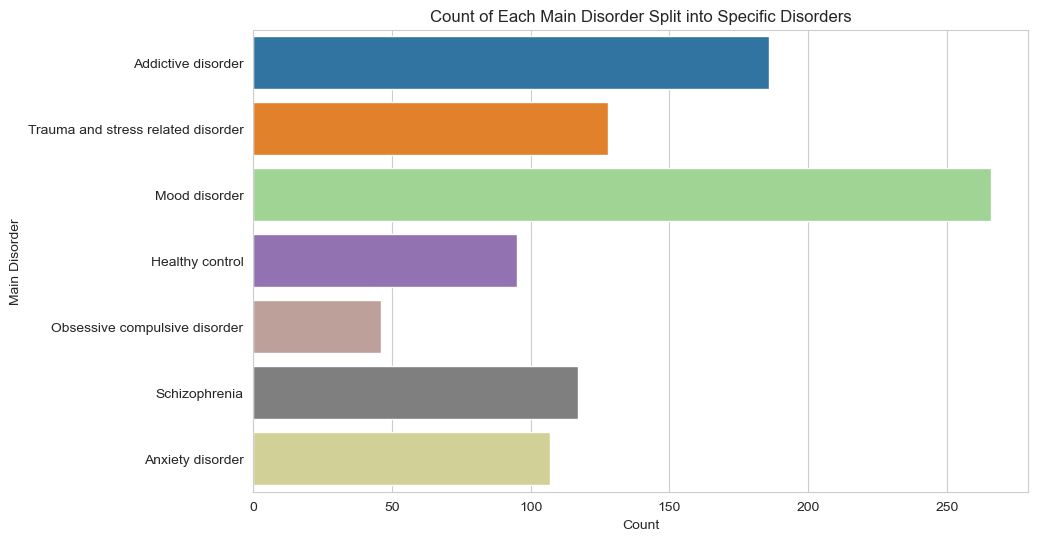

In [11]:
# find all unique disorders
unique_disorders = eegData['main.disorder'].nunique()

# set up our colour map
colormap = plt.colormaps.get_cmap('tab20')
distinct_colors = [colormap(i / unique_disorders) for i in range(unique_disorders)]

# plot the graph
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='main.disorder', data=eegData, hue='main.disorder', legend=False, palette=distinct_colors)

# label the graph
plt.xlabel("Count")
plt.ylabel("Main Disorder")
plt.title("Count of Each Main Disorder Split into Specific Disorders")
plt.show()

main.disorder                       specific.disorder            
Trauma and stress related disorder  Acute stress disorder             38
                                    Adjustment disorder               38
Obsessive compulsive disorder       Obsessive compulsive disorder     46
Anxiety disorder                    Social anxiety disorder           48
Trauma and stress related disorder  Posttraumatic stress disorder     52
Anxiety disorder                    Panic disorder                    59
Mood disorder                       Bipolar disorder                  67
Addictive disorder                  Alcohol use disorder              93
                                    Behavioral addiction disorder     93
Healthy control                     Healthy control                   95
Schizophrenia                       Schizophrenia                    117
Mood disorder                       Depressive disorder              199
dtype: int64

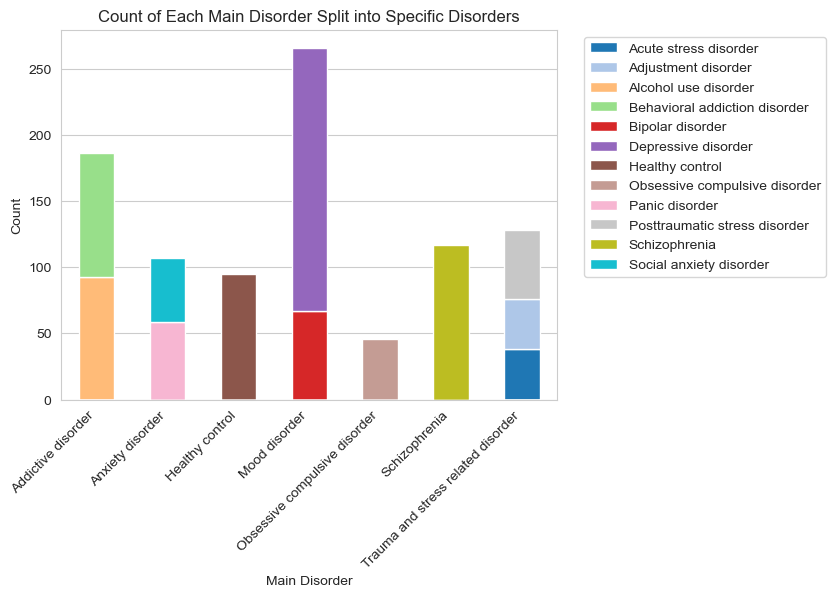

In [12]:
# graph set-up
fig, ax = plt.subplots()

disorder_counts = eegData.groupby(['main.disorder', 'specific.disorder']).size()

display(disorder_counts.sort_values())

num_disorders = len(disorder_counts.unstack('specific.disorder').columns)

# set up colour map
colormap = plt.colormaps.get_cmap('tab20')
distinct_colors = [colormap(i / num_disorders) for i in range(num_disorders)]

# plot graph
disorder_counts.unstack('specific.disorder')\
    .plot(kind='bar', stacked=True, ax=ax, color=distinct_colors)

ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.xaxis.grid(False)

# label the graph
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.xlabel("Main Disorder")
plt.title("Count of Each Main Disorder Split into Specific Disorders")
plt.show()

There are indeed class imbalances. The most notable are:
* Obsessive Compulsive Disorder
* Depressive Disorder (in Mood Disorder Category)
* PTSD (in Trauma and Stress related Disorder Category)
* Panic disorder (in Anxiety Disorder Category)

#### Sex

How many male and female subjects are there present in the dataset?

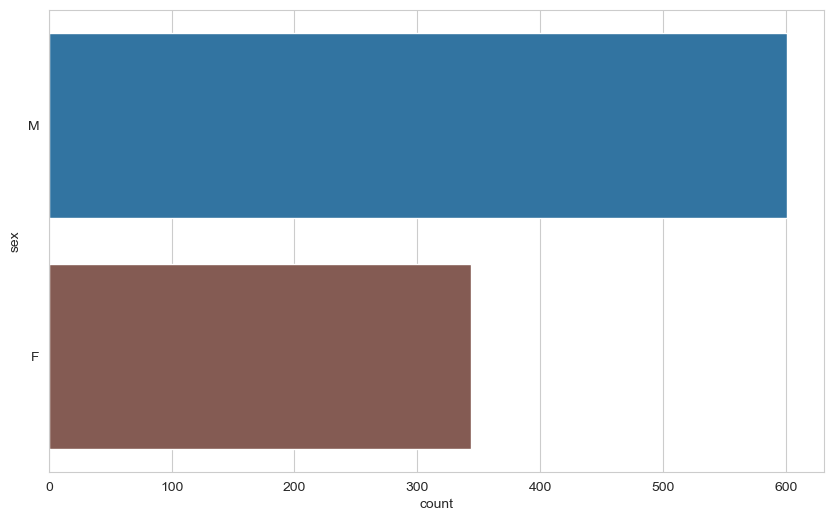

In [13]:
# find unique entries
unique_sexes = eegData['sex'].nunique()

# set up colour map
colormap = plt.colormaps.get_cmap('tab20')
distinct_colors = [colormap(i / unique_sexes) for i in range(unique_sexes)]

# plot graph
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='sex', data=eegData, hue='sex', legend=False, palette=distinct_colors)

plt.show()

Our dataset shows a total of 945 entries, and from the graph we can tell there are 600 males and 345 females.

We now move to examine the different categorical diagnosis separated by sex.

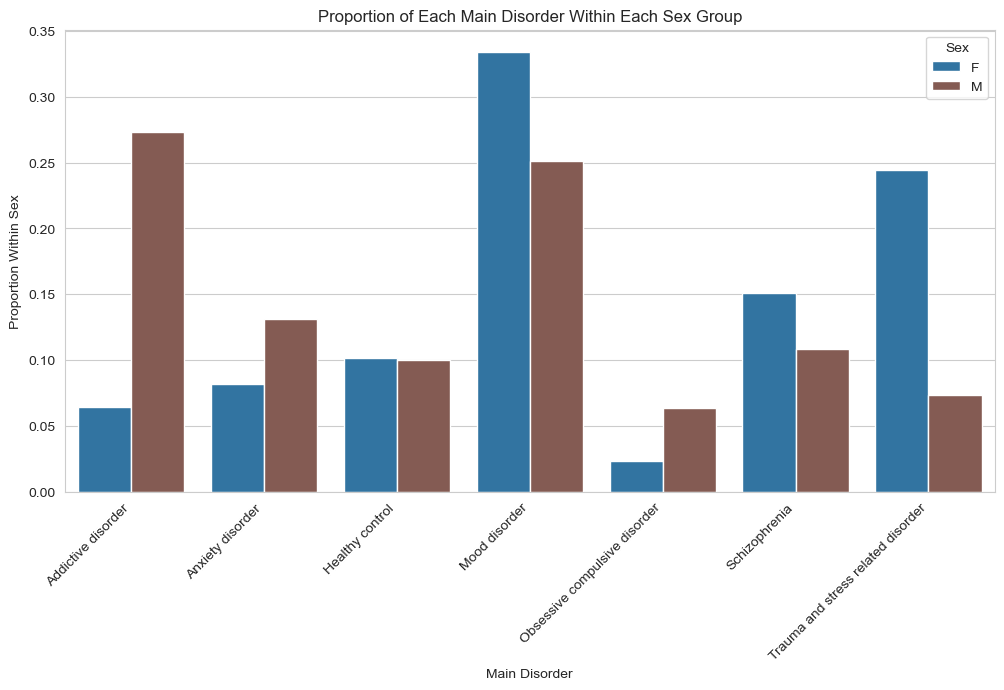

In [14]:
# gather/group our data
sex_totals = eegData.groupby('sex').size()

# compute proportion of each disorder within each sex group
proportion_df = (
    eegData.groupby(['main.disorder', 'sex']).size()
    .div(sex_totals)  # normalize by total count per sex
    .reset_index(name='proportion')
)

# get distinct colors for 'sex' (only 2 categories)
colormap = plt.colormaps.get_cmap('tab10')
distinct_colors = [colormap(i / 2) for i in range(2)]

# create a bar plot for proportions
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='main.disorder', y='proportion', hue='sex', data=proportion_df, palette=distinct_colors)

# label and plot graph
plt.xticks(rotation=45, ha='right')
plt.ylabel("Proportion Within Sex")
plt.xlabel("Main Disorder")
plt.title("Proportion of Each Main Disorder Within Each Sex Group")
plt.legend(title="Sex", loc='upper right')
plt.show()

We see that males seem to struggle with addictive disorders, anxiety disorders, and obsessive compulsive disorders more than their female counterparts, meanwhile females struggle with mood disorders, schizophrenia, and trauma/stress related disorders. 

*Note that this is a generalisation based on a limited sample size, and the proportions here may be skewed on the account of a small number of women in the sample relative to the total number of individuals in the sample.*

What about specific disorders?

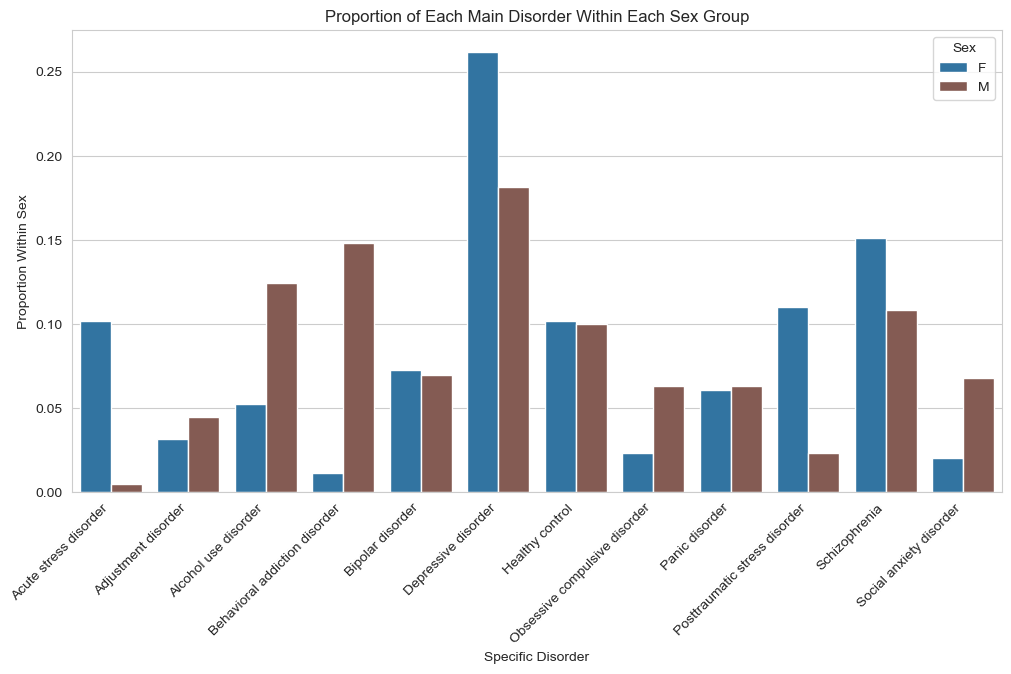

In [15]:
# gather/group our data
sex_totals = eegData.groupby('sex').size()

# compute proportion of each disorder within each sex group
proportion_df = (
    eegData.groupby(['specific.disorder', 'sex']).size()
    .div(sex_totals)  # normalize by total count per sex
    .reset_index(name='proportion')
)

# get distinct colors for 'sex' (only 2 categories)
colormap = plt.colormaps.get_cmap('tab10')
distinct_colors = [colormap(i / 2) for i in range(2)]

# create a bar plot for proportions
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='specific.disorder', y='proportion', hue='sex', data=proportion_df, palette=distinct_colors)

# label and plot graph
plt.xticks(rotation=45, ha='right')
plt.ylabel("Proportion Within Sex")
plt.xlabel("Specific Disorder")
plt.title("Proportion of Each Main Disorder Within Each Sex Group")
plt.legend(title="Sex", loc='upper right')
plt.show()

Like we previously established, males seem to struggle more with disorders like alcohol use, behavioural addiction, and obsessive compulsive, whereas females suffer more from acute stress disorder, depressive disorder, post traumatic stress disorder, and schizophrenia.

### Numerical Variables

In [16]:
# gather our numerical variable data
df_long = patients_info.melt(id_vars = ['sex', 'main.disorder', 'specific.disorder'], value_vars=['age', 'education', 'IQ'])

# preliminary graph set-up
displot = partial(sns.displot, 
                  data=df_long, kind='hist', 
                  x='value', col='variable', 
                  col_wrap=3, common_bins=False, 
                  facet_kws={'sharex': False, 'sharey': False})

displot2 = partial(sns.displot,
                  data=patients_info, kind='hist',  
                  col_wrap=3,facet_kws={'sharey': False})

#### Numeric Distributions

What distributions do the numeric variables have?

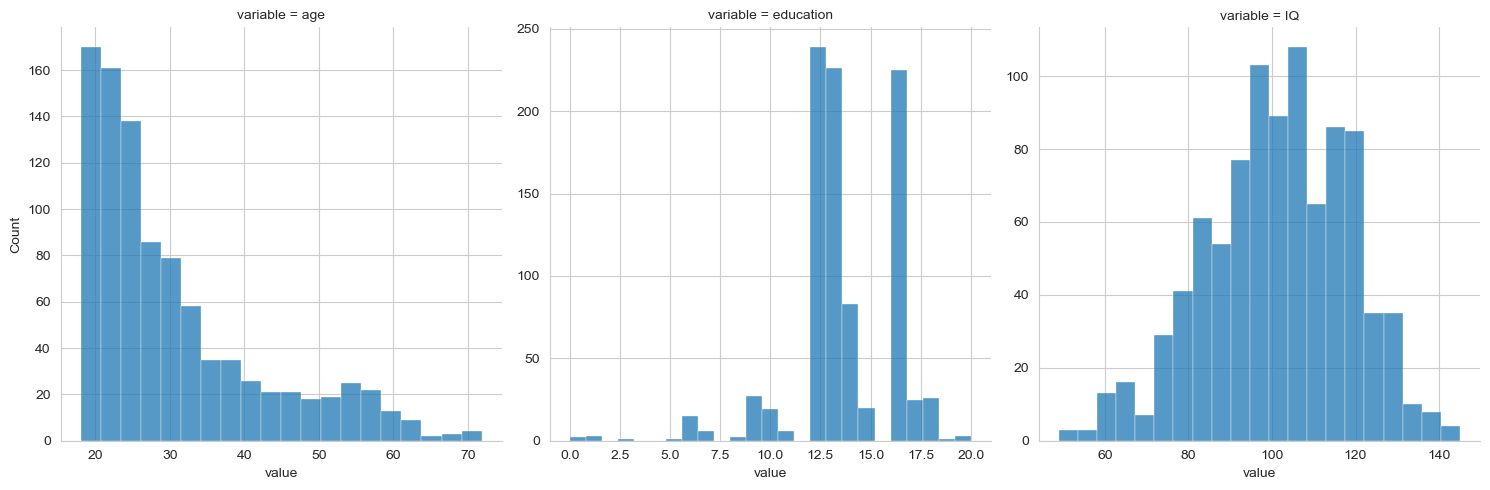

In [17]:
# display distributions
displot()
plt.show()

Does **sex** affect the variable's distribution?

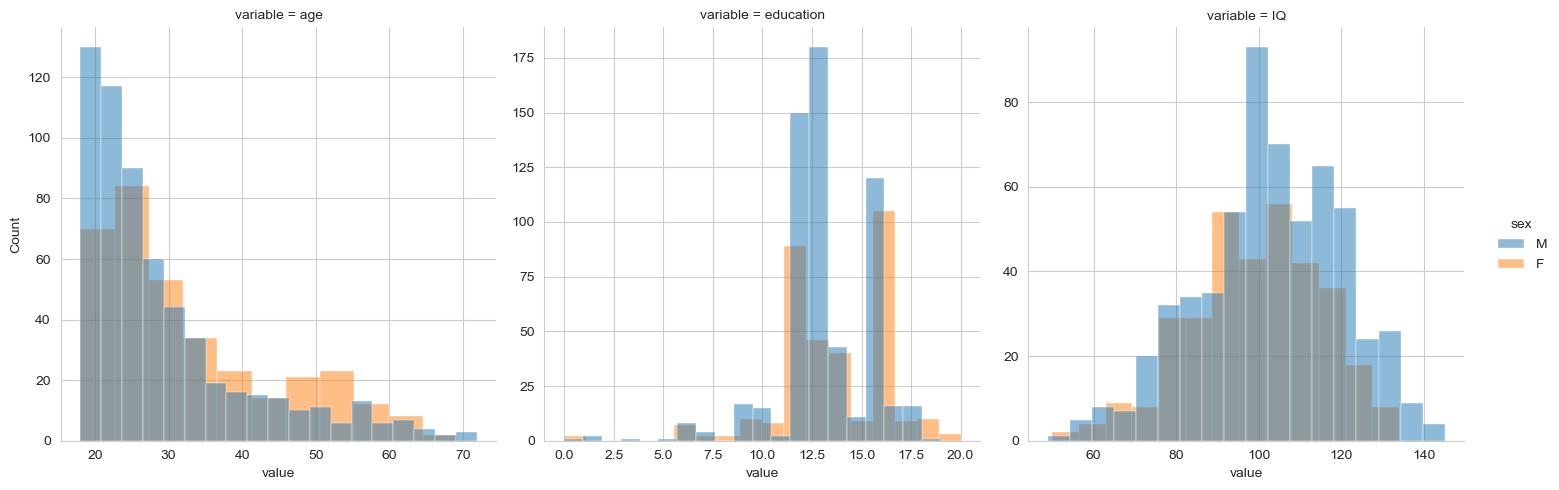

In [18]:
# display distributions accouting for differences in sex
displot(hue='sex', alpha=0.5)
plt.show()

Sex seems to have no major effect on the distributions -- they both have similar distribution shapes.

How does **age** shape the distribution of patients with different disorder types?

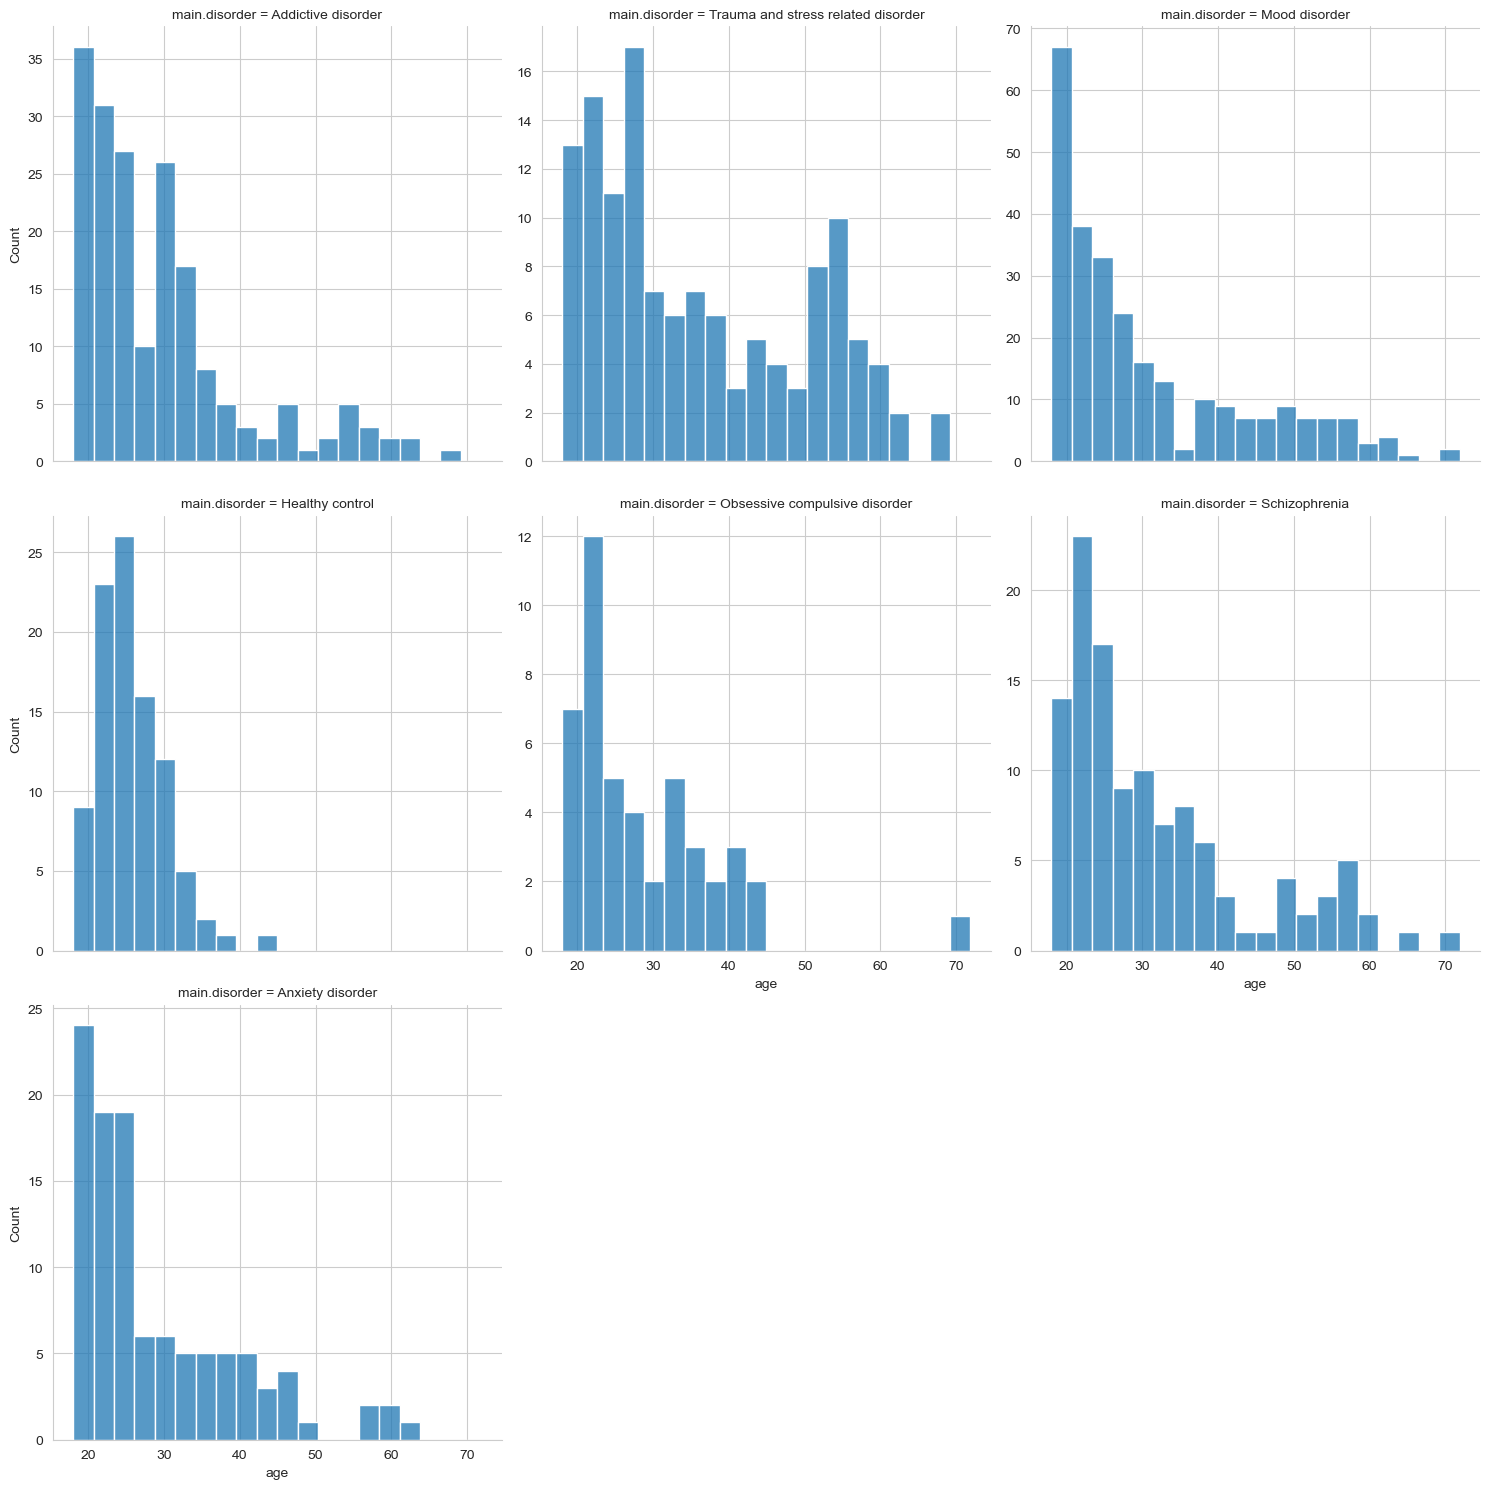

In [19]:
# display distributions
displot2(x='age', col='main.disorder')
plt.show()

Generally speaking, as age increases, the number of people with their categorical disorder type decreases. Note that one limitation of this graph is that is does not account for people who do struggle with mental disorder, but lack the proper diagnosis.

Now we highlight the distributions with respect to sex:

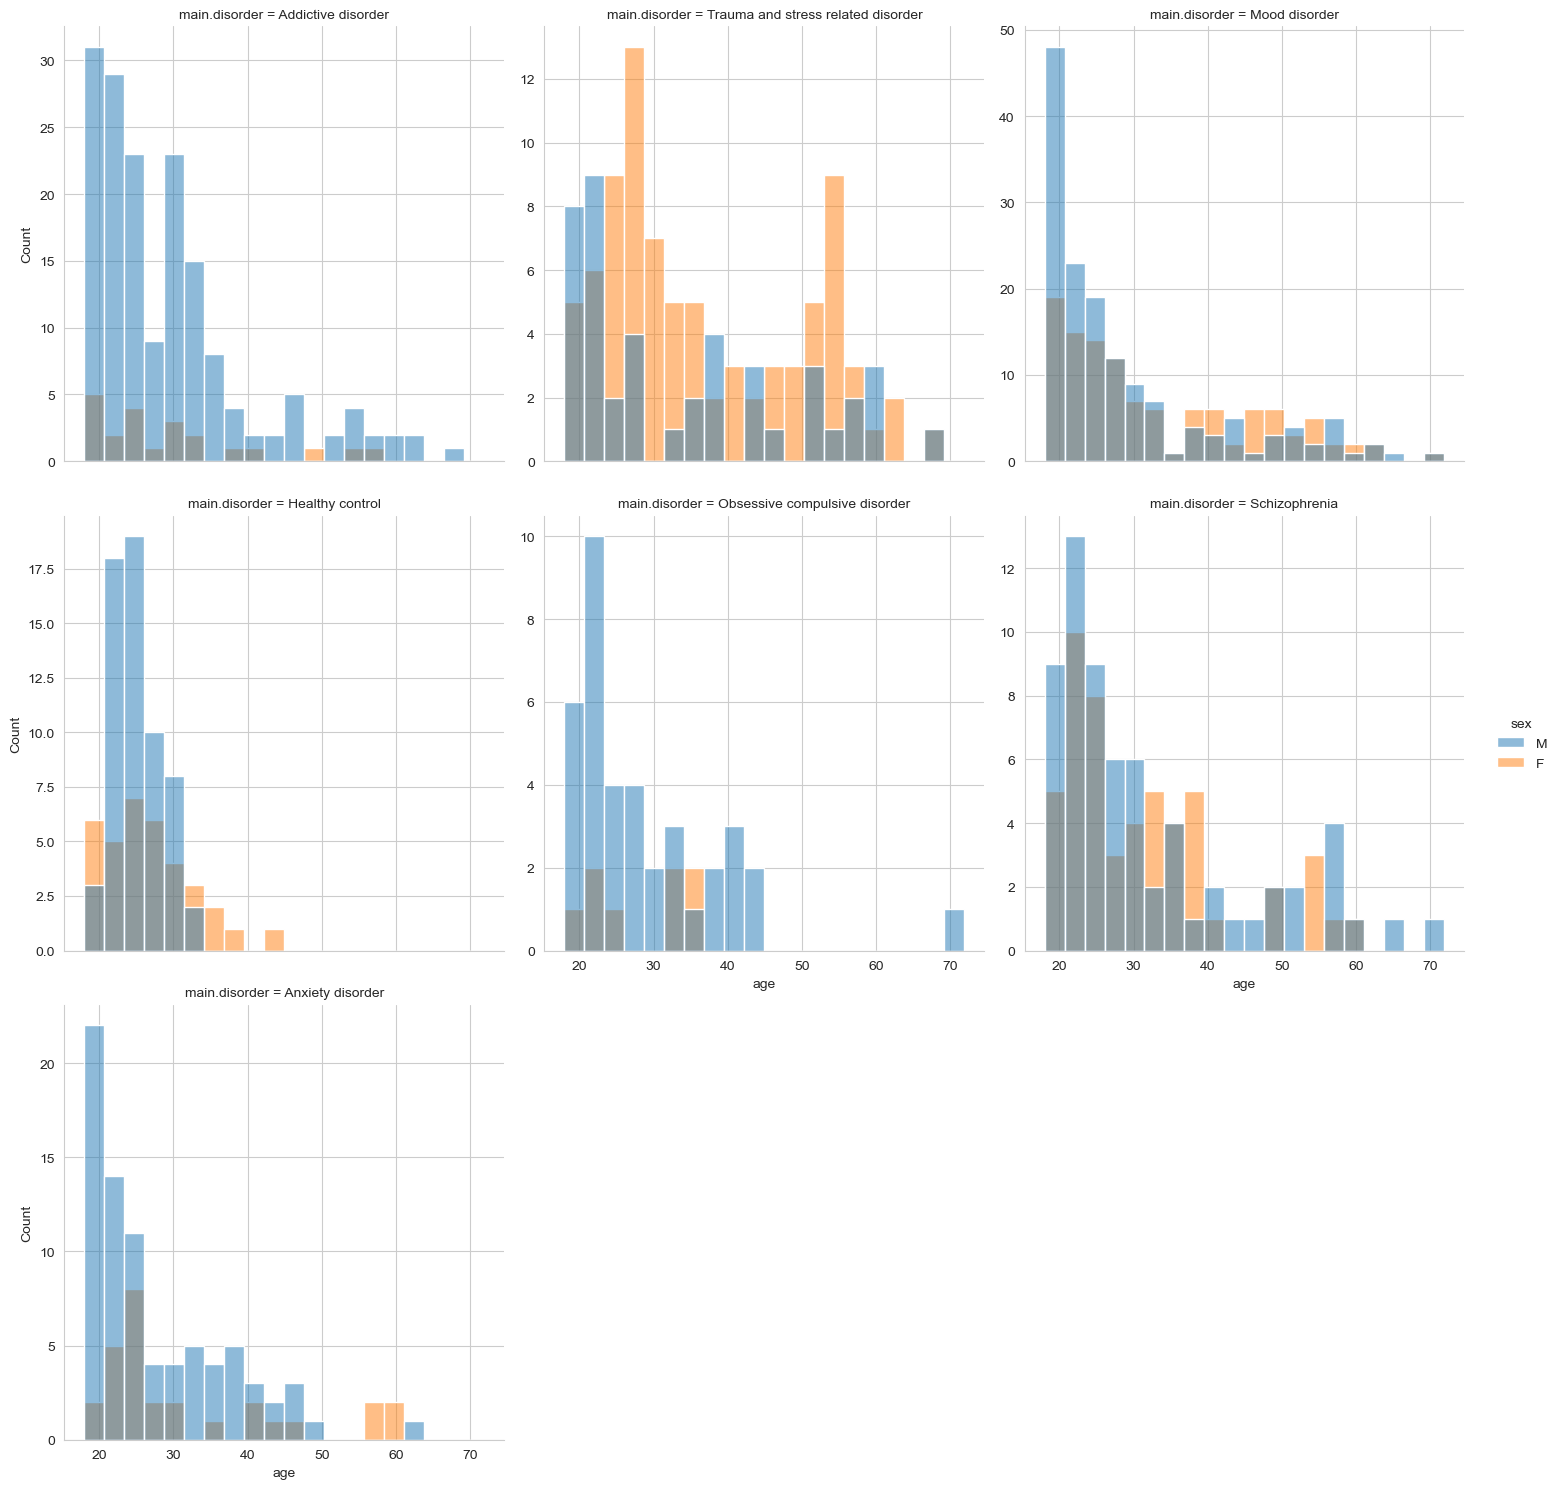

In [20]:
# display distributions with respect to sex
displot2(x='age', col='main.disorder', hue='sex')
plt.show()

Interestingly, in the case of Trauma/Stress related disorders, women are responsible for the shape of the distribution as well as the two peaks near the ages of 30 and 55. Similarly, in the case of Obsessive Compulsive disorders, men are responsible for the shape of the distribution and the peak near the age of 20. 

Now for specific disorders:

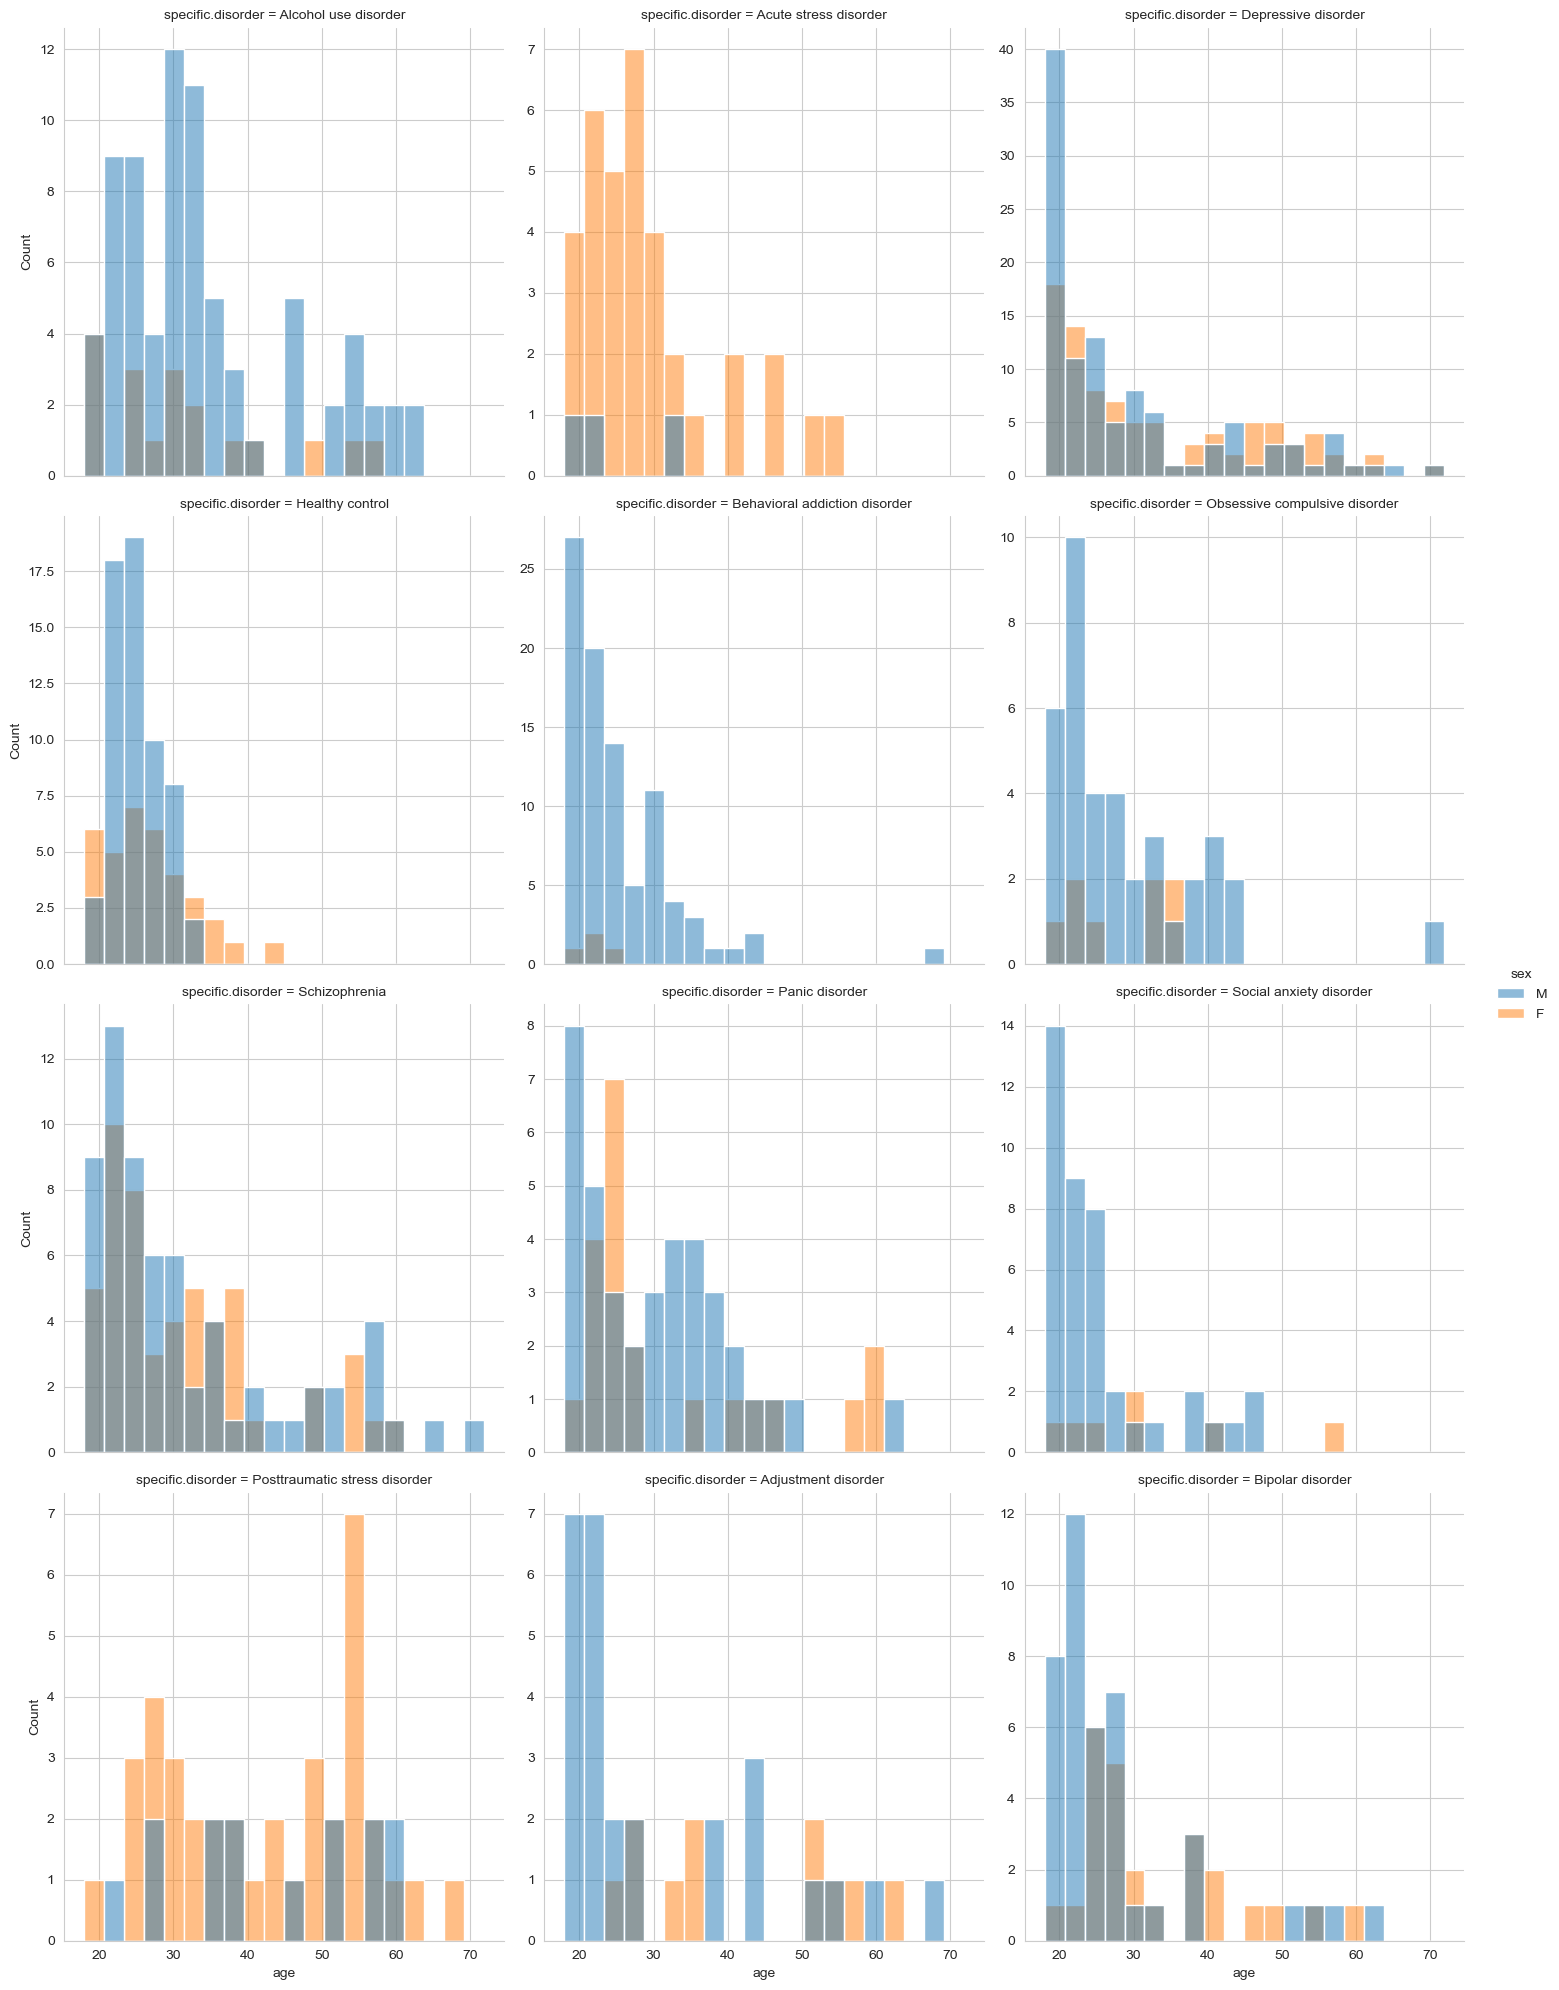

In [21]:
# display distributions with respect to sex
displot2(x='age', col='specific.disorder', hue='sex')
plt.show()

Matching our earlier findings, we see that men shape the distributions for alcohol use, behavioural addiction, obsessive compulsive, and social anxiety disorders, and women shape acute stress disorder and PTSD, most notably. Schizophrenia on the other hand, has a large amount of overlap in the age distribution.

How does **education** shape the distribution of patients with different disorder types? What about **IQ**?

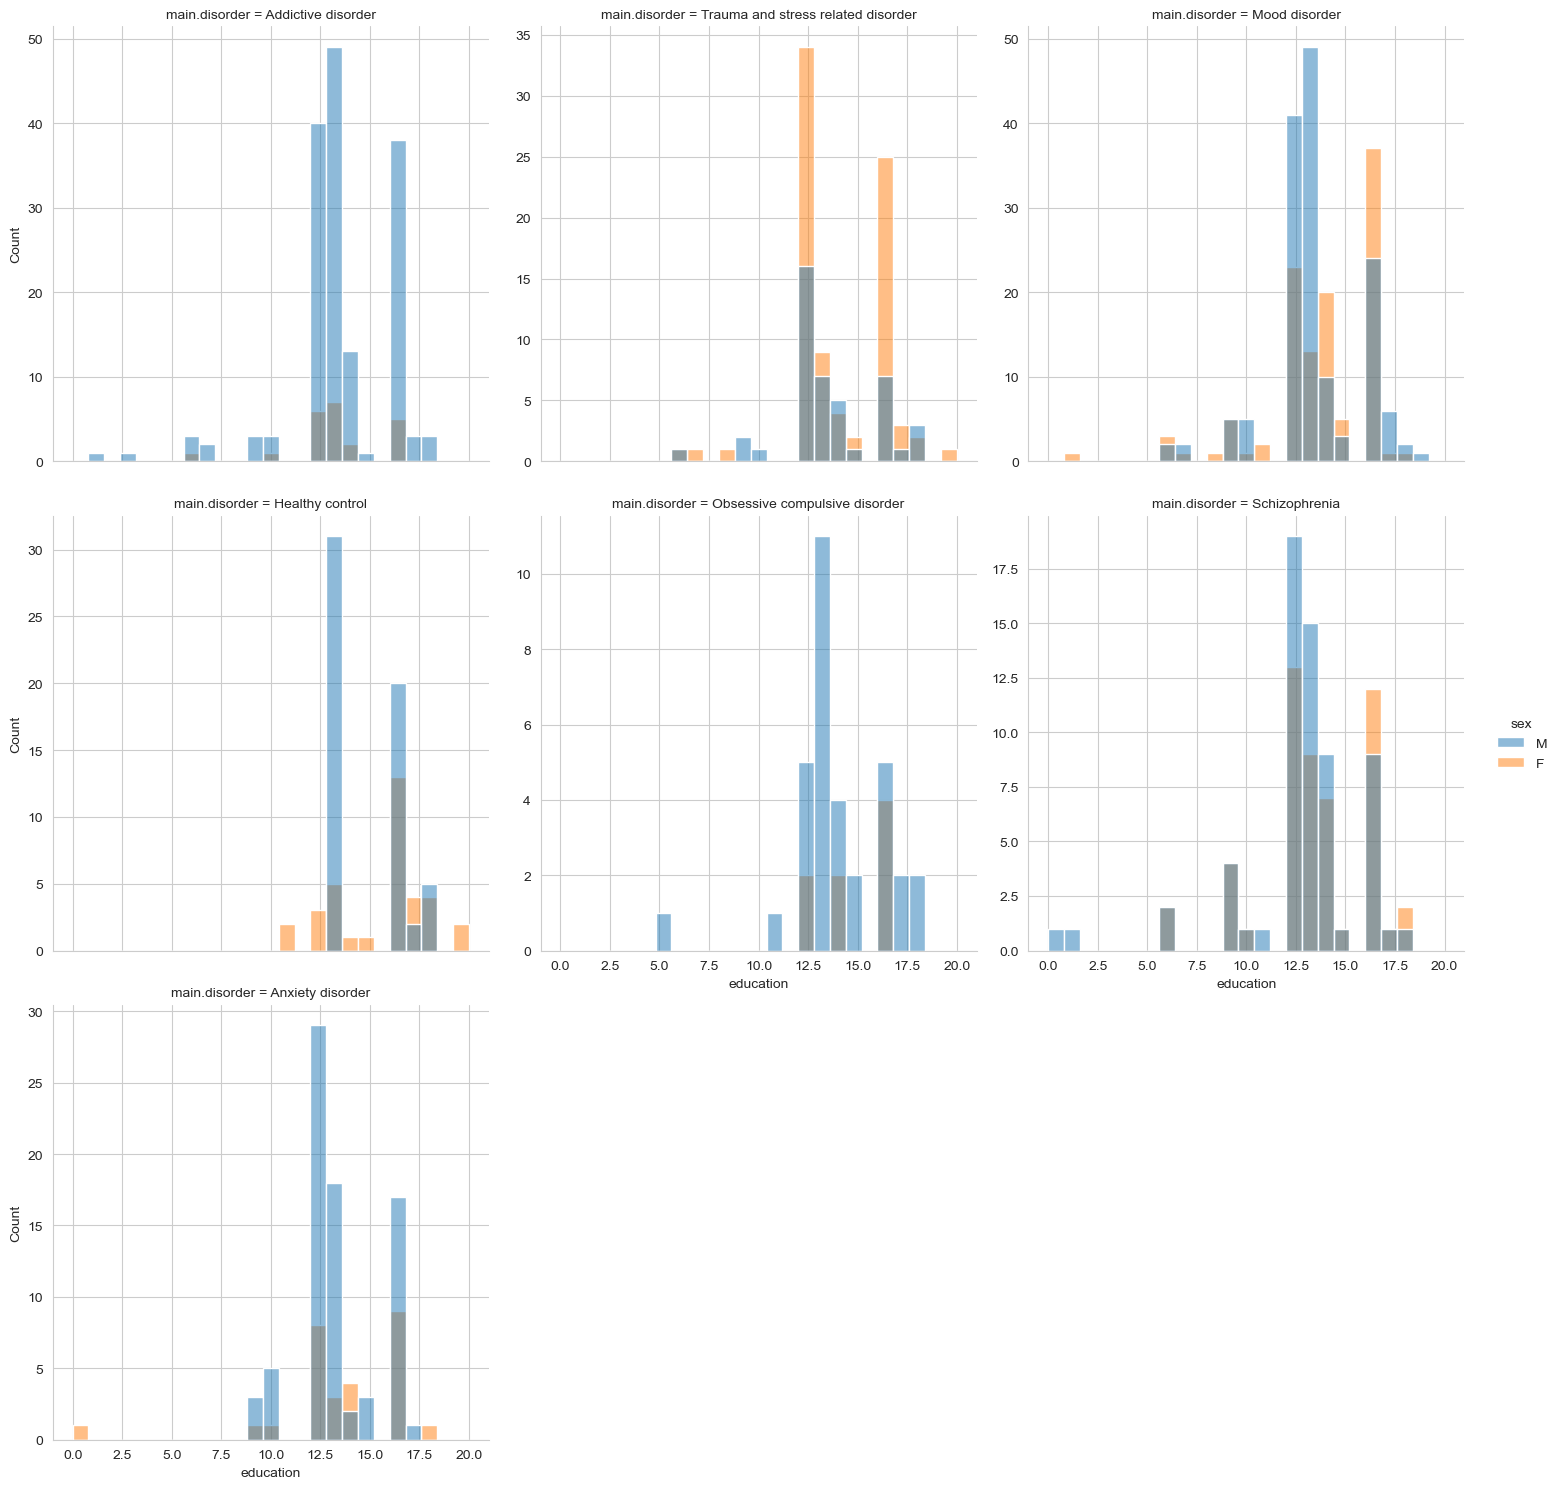

In [22]:
# display distributions with respect to sex
displot2(x='education', col='main.disorder', hue='sex')
plt.show()

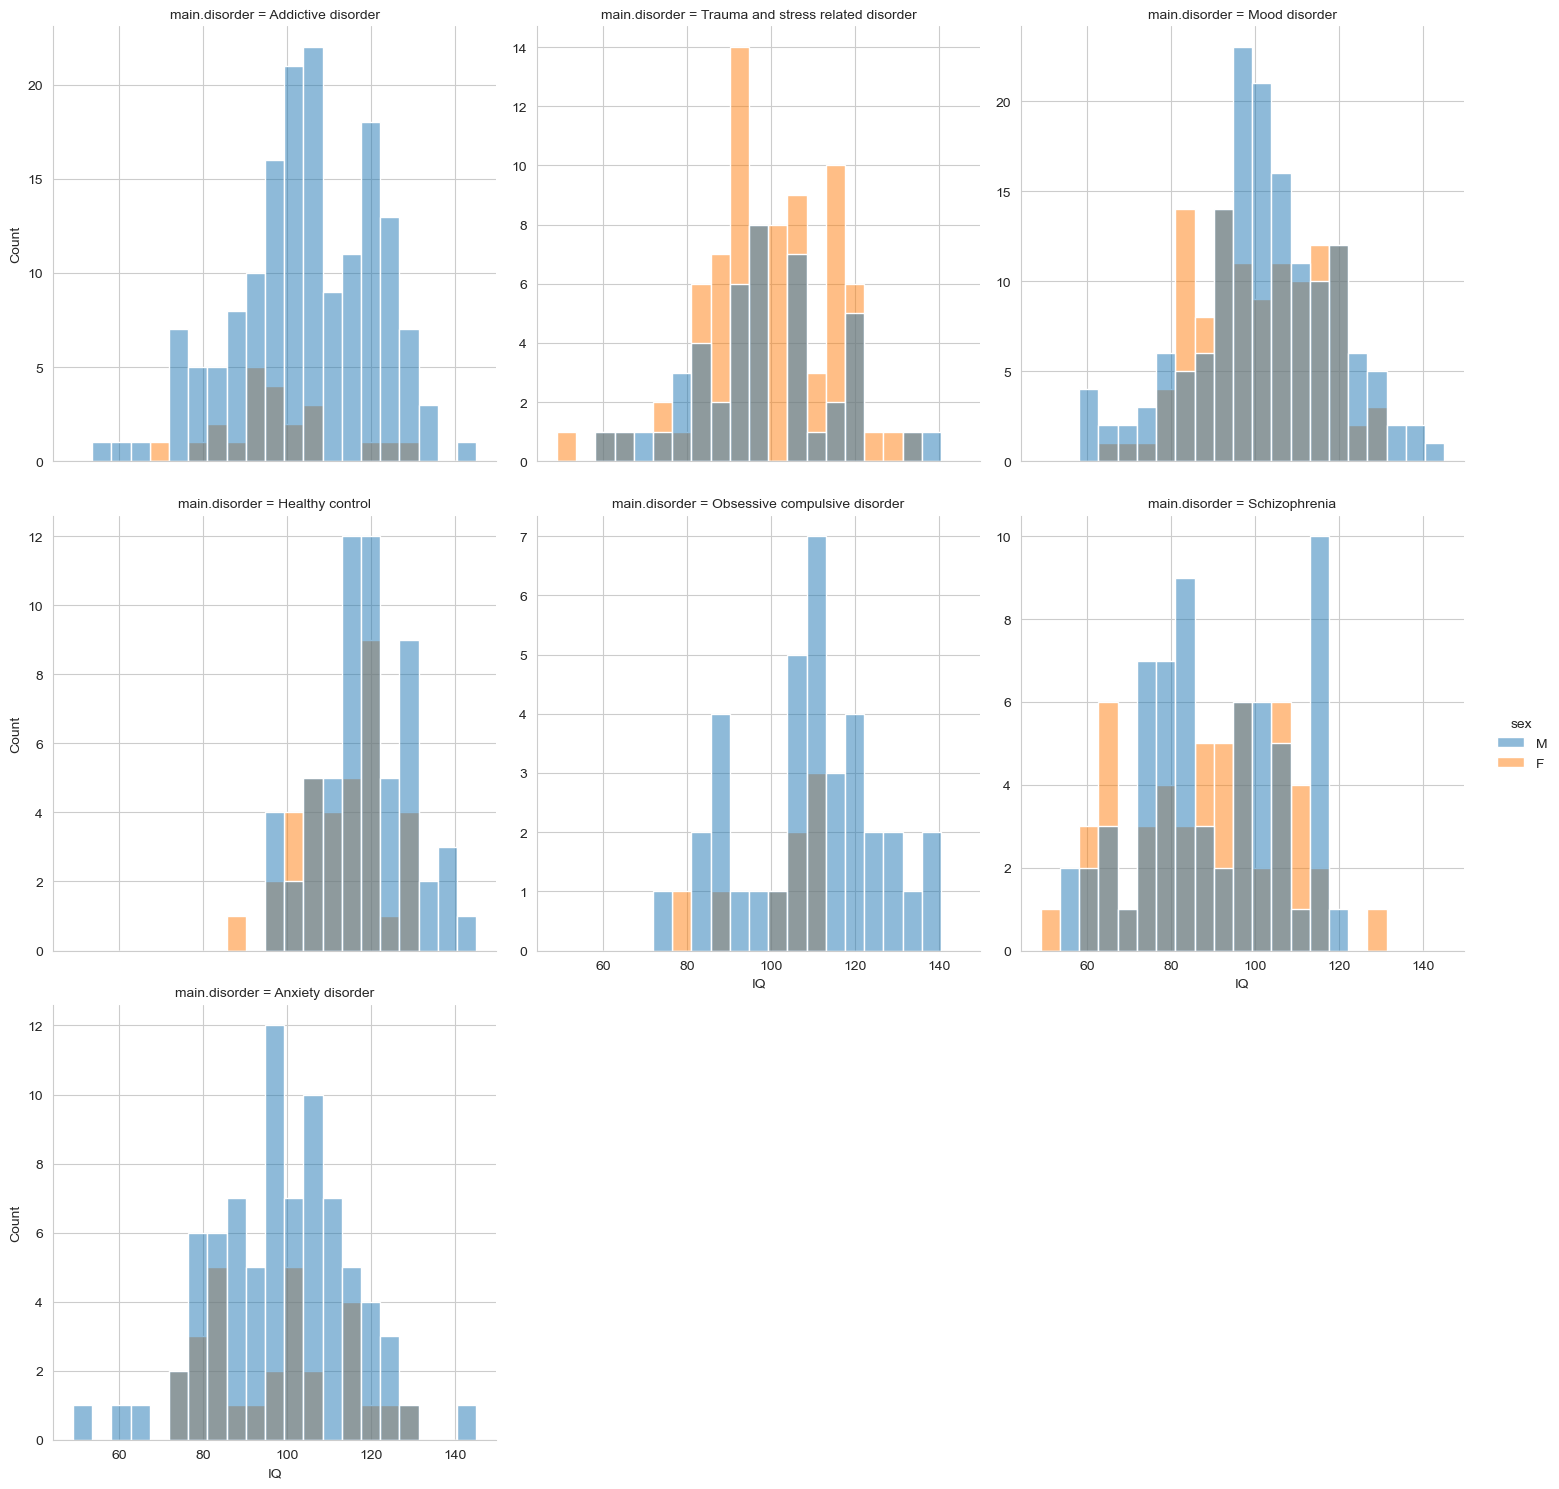

In [23]:
# display distributions with respect to sex
displot2(x='IQ', col='main.disorder', hue='sex')
plt.show()

For the most part, IQ and education distributions seem to resemble a normal distribution shape, so we do not need to consider applying any transformations to them.

We now briefly look to examine the distributions of the **PSD** and **FC** features:

##### Power Spectral Density Graphs

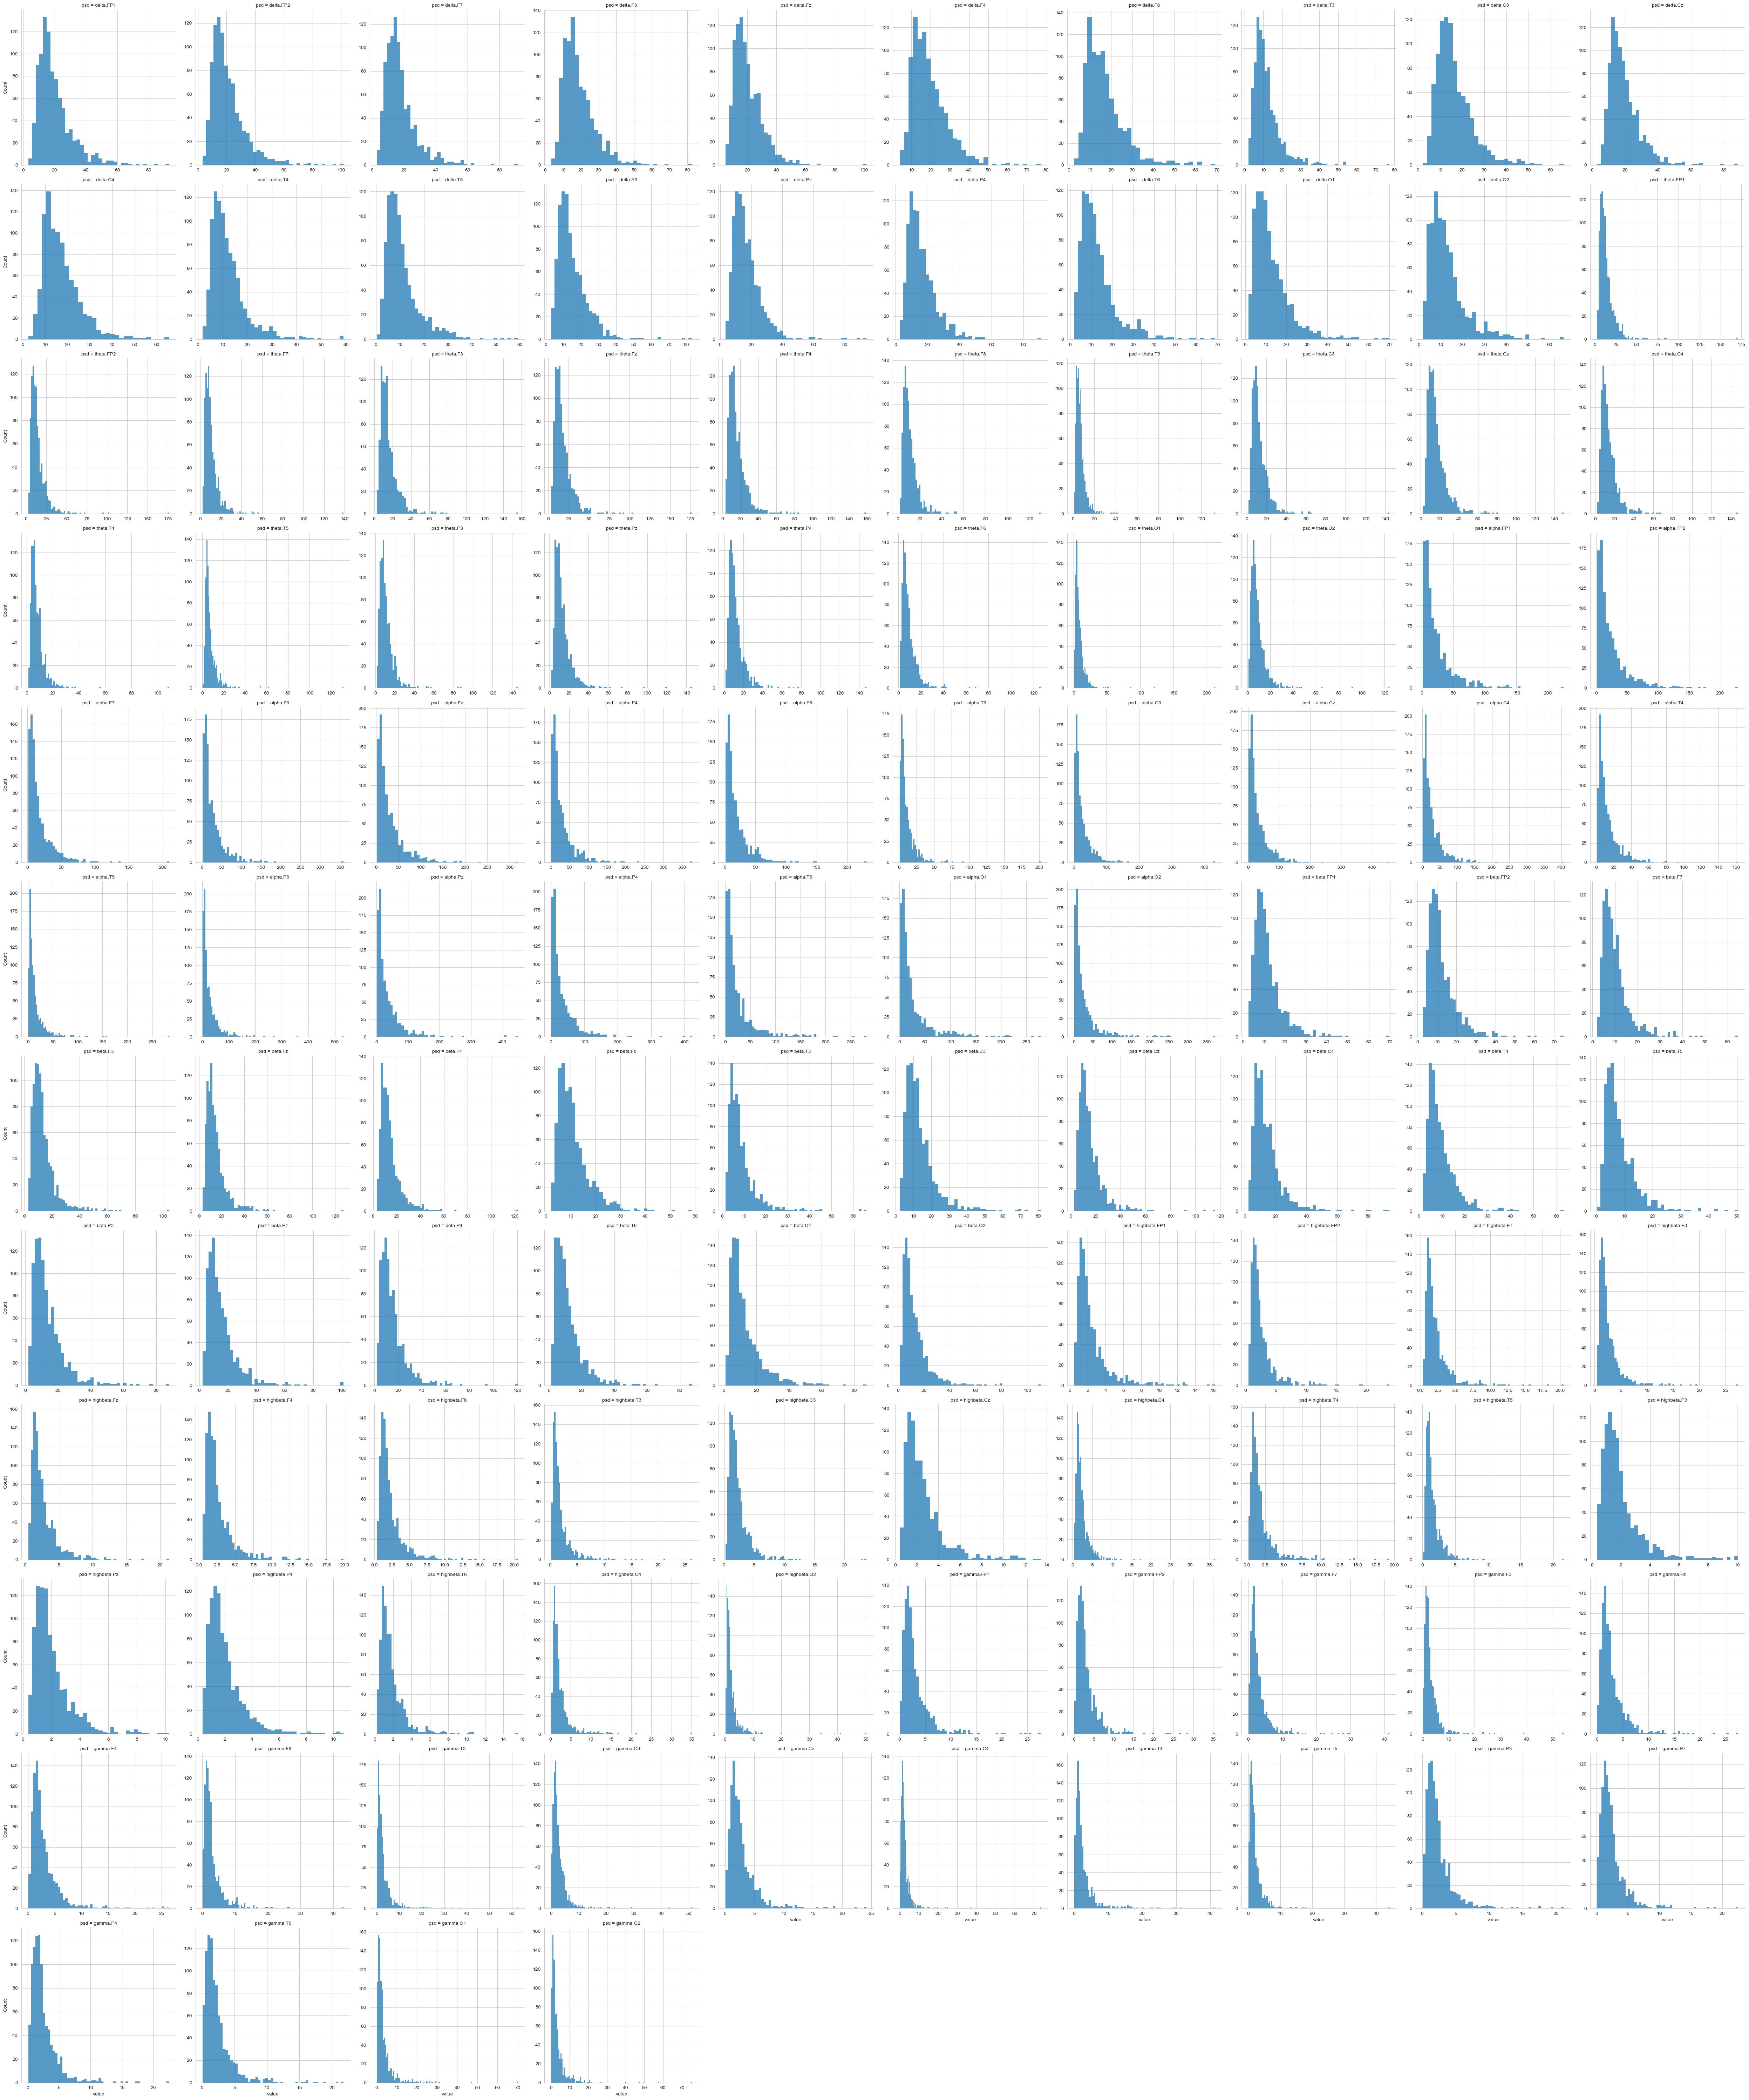

In [24]:
# define our columns from eegData
psd_cols = eegData.loc[:, 'delta.FP1':sepaCol].drop(sepaCol, axis=1).columns

# create dataFrame for visualisation
psd_long = eegData.melt(id_vars='no.', value_vars=psd_cols, var_name='psd')
sns.displot(data=psd_long, kind='hist', x='value', col='psd', col_wrap=10, common_bins=False, facet_kws={'sharey':False, 'sharex': False})
plt.show()

##### Functional Connectivity Graphs

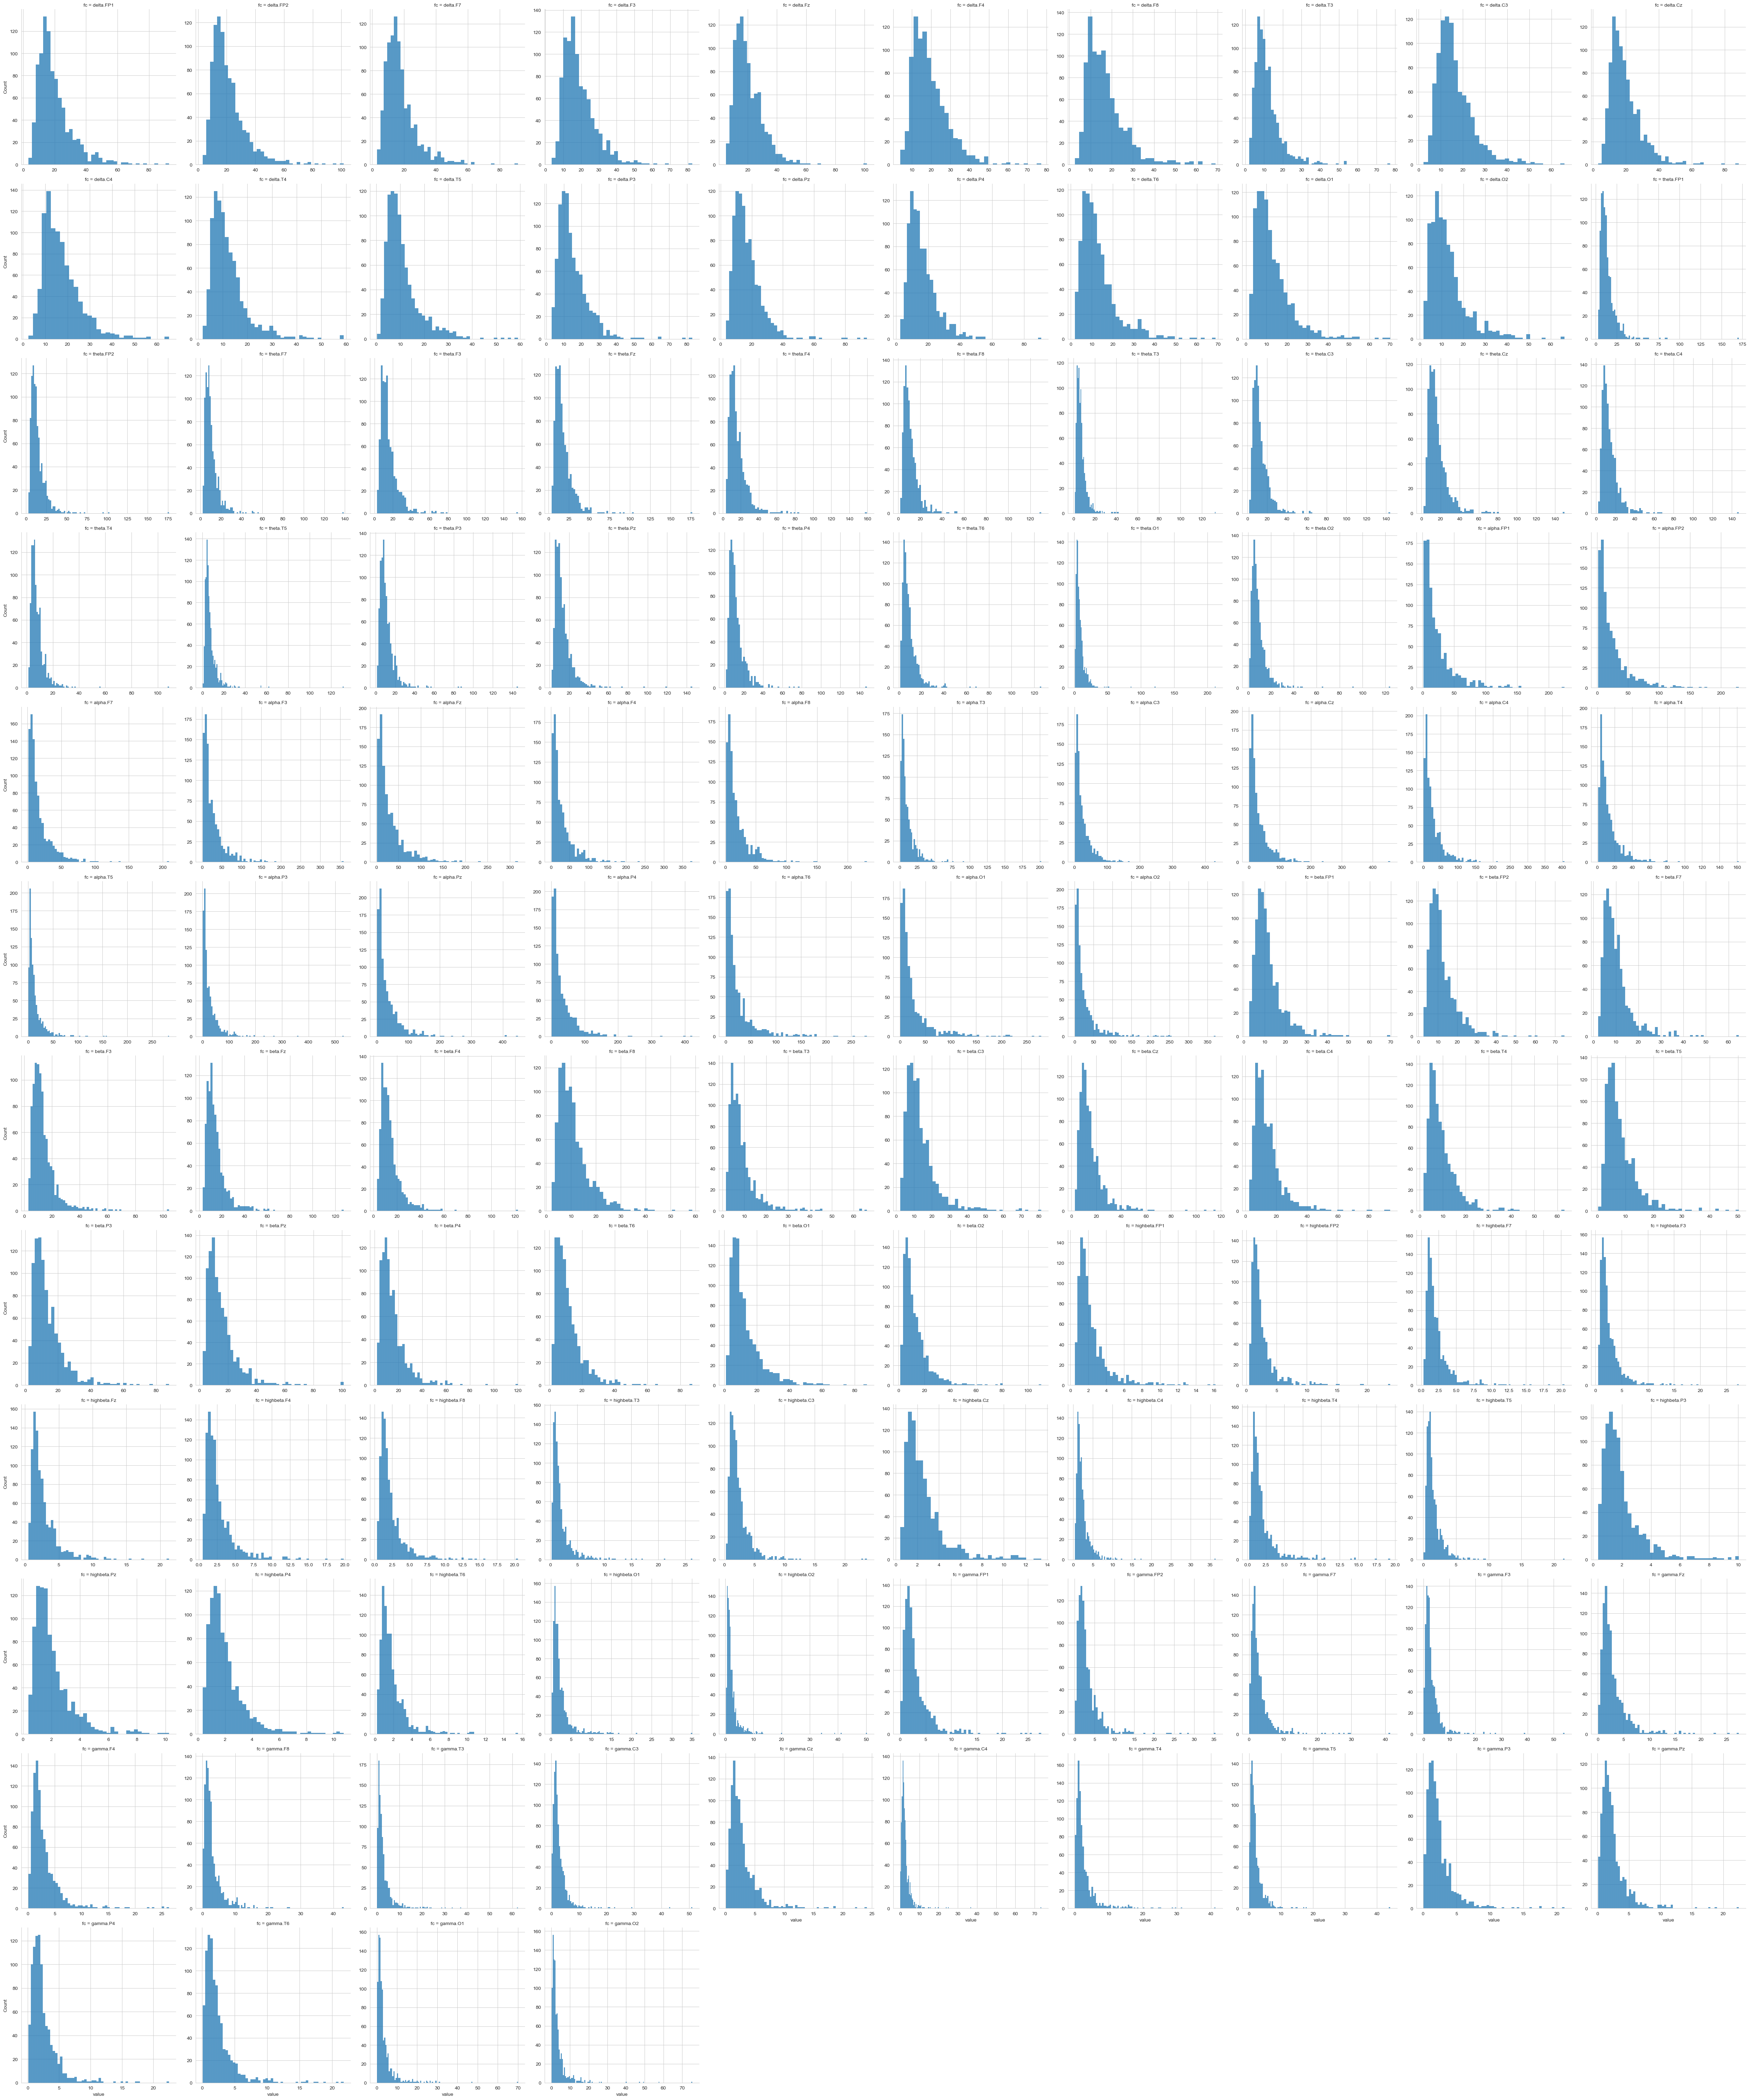

In [25]:
# define our columns from eegData
fc_cols = eegData.loc[:, sepaCol:'COH.gamma.O1.O2'].drop(sepaCol, axis=1).columns

# create dataFrame for visualisation
fc_long = eegData.melt(id_vars='no.', value_vars=psd_cols, var_name='fc')
sns.displot(data=fc_long, kind='hist', x='value', col='fc', col_wrap=10, common_bins=False, facet_kws={'sharey':False, 'sharex': False})
plt.show()

We see that both the PSD and FC graphs seem to have *log-normal distributions*, suggesting that we should consider applying a logarithmic transformation to them later down the road. We will revisit this matter later. This marks the end of our EDA.

### Missing Data

In preparation for the next step in this notebook, our pre-processing, we look to examine our dataset for missing values and to act in accordance with our findings.

In [26]:
# find missing values
missing = eegData.isna().sum()
missing[missing > 0]

education        15
IQ               13
Unnamed: 122    945
dtype: int64

In [27]:
# list our missing values
educ_na = eegData[eegData['education'].isna()]
iq_na = eegData[eegData['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

no. sex    age    eeg.date  education     IQ  \
0      1   M  57.00   2012.8.30        NaN    NaN   
17    18   M  30.00   2013.9.27        NaN   86.0   
21    22   M  20.00  2014.10.23        NaN  116.0   
155  156   M  18.00   2013.12.7        NaN  103.0   
173  174   M  23.00  2015.11.14        NaN  113.0   
269  270   M  25.00   2015.9.23        NaN   85.0   
270  271   M  34.00   2015.9.21        NaN  120.0   
279  280   M  35.00    2016.6.2        NaN    NaN   
280  281   M  37.00   2016.6.27        NaN  110.0   
281  282   M  22.00   2016.6.30        NaN  107.0   
384  385   F  51.38  2011.12.27        NaN   97.0   
417  418   F  53.67   2013.4.18        NaN  101.0   
433  434   M  34.16   2013.4.11        NaN  142.0   
845  846   M  21.29   2013.3.25        NaN   82.0   
920  921   M  24.00    2013.2.1        NaN  114.0   
33    34   F  19.26    2013.8.5       12.0    NaN   
38    39   F  19.47   2014.5.26       12.0    NaN   
42    43   F  32.94  2014.10.16       16.0    NaN   
43    44   F  22.65   2014.11.8       13.0    NaN   
60    61   M  34.00   2016.3.10       12.0    NaN   
92    93   F  39.18    2017.3.3       16.0    NaN   
93    94   F  28.42   2017.3.20        9.0    NaN   
223  224   M  19.00   2016.7.12       12.0    NaN   
225  226   M  20.00   2016.9.13       13.0    NaN   
234  235   M  20.00  2017.11.22       13.0    NaN   
278  279   M  21.00   2016.5.13       15.0    NaN   

                          main.disorder              specific.disorder  \
0                    Addictive disorder           Alcohol use disorder   
17                   Addictive disorder           Alcohol use disorder   
21                   Addictive disorder           Alcohol use disorder   
155                  Addictive disorder  Behavioral addiction disorder   
173                     Healthy control                Healthy control   
269       Obsessive compulsive disorder  Obsessive compulsive disorder   
270       Obsessive compulsive disorder  Obsessive compulsive disorder   
279       Obsessive compulsive disorder  Obsessive compulsive disorder   
280       Obsessive compulsive disorder  Obsessive compulsive disorder   
281       Obsessive compulsive disorder  Obsessive compulsive disorder   
384                       Mood disorder            Depressive disorder   
417  Trauma and stress related disorder  Posttraumatic stress disorder   
433                    Anxiety disorder                 Panic disorder   
845                       Mood disorder               Bipolar disorder   
920                     Healthy control                Healthy control   
33   Trauma and stress related disorder          Acute stress disorder   
38   Trauma and stress related disorder          Acute stress disorder   
42   Trauma and stress related disorder          Acute stress disorder   
43   Trauma and stress related disorder          Acute stress disorder   
60                   Addictive disorder           Alcohol use disorder   
92                        Mood disorder            Depressive disorder   
93                        Mood disorder            Depressive disorder   
223                  Addictive disorder  Behavioral addiction disorder   
225                  Addictive disorder  Behavioral addiction disorder   
234                  Addictive disorder  Behavioral addiction disorder   
278       Obsessive compulsive disorder  Obsessive compulsive disorder   

     delta.FP1  delta.FP2  ...  COH.gamma.Pz.P4  COH.gamma.Pz.T6  \
0    35.998557  21.717375  ...        55.989192        16.739679   
17   12.443237  12.503703  ...        85.080600        53.533875   
21   28.287190  22.412264  ...        33.065475        24.351780   
155  16.548803  19.042179  ...        93.825121        79.091595   
173  19.050158  23.277470  ...        68.005720        54.685472   
269   6.186264   7.112847  ...        72.743284        63.723838   
270  12.784872  15.922964  ...        72.409132        49.265064   
279  21.524573  22.227615  ...

What percentage of data we will lose if we drop rows with missing data (in terms of each main.disorder group)?

In [28]:
# calculate our data loss if we drop NA values
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = eegData['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

all_data  na_percentage
main.disorder                                              
Obsessive compulsive disorder             46      13.043478
Addictive disorder                       186       4.301075
Trauma and stress related disorder       128       3.906250
Healthy control                           95       2.105263
Mood disorder                            266       1.503759
Anxiety disorder                         107       0.934579

Yikes! We will lose a whopping 13% of our data on patients with OCD, which is already one of the smallest groups in the sample anyways. We should consider filling the missing data.

Our options to fill the data are:
* Special Value
* Median Value
* Imputation

We opt to use **median value** since it's robust to outliers unlike special value calculations, prevents data leakage that advanced imputation techniques could inadvertently introduce, and preserves data distribution. Most importantly, it is simple and efficient.

In [29]:
# calculate median values for our data
display(eegData[['education', 'IQ']].agg(['mean', 'median']))
imputer = SimpleImputer(strategy='median')

education          IQ
mean     13.43871  101.580472
median   13.00000  102.000000

In [30]:
# write this new data to a different csv
eegData.to_csv('dataset.csv', index=False)

With that out of the way, let's look to visualise our PSD values before we move onto pre-processing.

## Visualisation of PSD Values

In [31]:
# define electrode positions
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

channels = pd.DataFrame(chs).transpose()

In [32]:
# code block generated partially with chatGPT
def plot_eeg(levels, positions, fig, ch_names=None, cmap='Spectral_r', 
             marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    """
    Function visulises processed EEG data in a simple way. Based on mne.viz.plot_topomap.


    :param levels: numpy.array, shape (n_chan,)
        data values to plot.
    :param positions: numpy.array, shape (n_chan, 2)|instance of mne.Info
        Location information for the data points(/channels). If an array, for each data point,
        the x and y coordinates. If an Info object, it must contain only one data type and exactly
        len(data) data channels, and the x/y coordinates will be inferred from the montage applied
        to the Info object.
    :param fig: matplotlib.figure.Figure
        The figure to create colorbar on.
    :param ch_names: list | None
        List of channel names. If None, channel names are not plotted.
    :param cmap: matplotlib colormap | None
        Colormap to use. If None, ‘Reds’ is used for all positive data, otherwise defaults to ‘RdBu_r’.
        Default value is 'Spectral_r'
    :param marker: numpy.array of bool, shape (n_channels,) | None
        Array indicating channel(s) to highlight with a distinct plotting style.
        Array elements set to True will be plotted with the parameters given in mask_params.
        Defaults to None, equivalent to an array of all False elements.
    :param marker_style: dict | None
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4)
    :param vmin, vmax: float | callable() | None
        Lower and upper bounds of the colormap, in the same units as the data.
        If vmin and vmax are both None, they are set at ± the maximum absolute value
        of the data (yielding a colormap with midpoint at 0). If only one of vmin, vmax is None,
        will use min(data) or max(data), respectively. If callable, should accept a NumPy array
        of data and return a float.
    :param kwargs:
        any other parameter used in mne.viz.plot_topomap
    :return axes: matplotlib.axes.Axes
        axes of the figure
    """
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
    axes = fig.subplots(1, 2, gridspec_kw={'width_ratios': [12, 1]})
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes[0], names=ch_names, vlim=(vmin, vmax),
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)    
    #axes[1].set_position([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = fig.colorbar(im, cax=axes[1])
    return axes

def plot_eeg_dataset(dataset, channels, gwidth=2, gheight=1.5, wspace=0, char_space=2,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    """
    Visualisation of pre-processed EEG dataset.
    See example of usage on Kaggle (https://www.kaggle.com/code/lazygene/visualising-pre-processed-eeg-data)
    :param dataset: pandas.DataFrame
        Data set to visualise. See format of the dataset on Kaggle (url above).
    :param channels: pandas.DataFrame
        Channel (index) names and positions (columns: x and y).
    :param gwidth: float
        Width of single topology map.
    :param gheight: float
        Height of single topology map.
    :param wspace: float
        Space between subplots
    :param marker_style:
        marker_style: dict
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='black', markeredgecolor='k', linewidth=0, markersize=2)
    :param band_ordered: list | None
        List of EEG bands (e.g. delta, gamma, etc.), they must be one or more columns of dataset DataFrame.
        Provides a way to control the order (form top to bottom) of bands in the resulted complex figure.
        If None, all columns of dataset are used in orfer of columns.
    :param conditions_ordered: list | None
        List of conditions, they must be one or more level 0 indecies of dataset DataFrame.
        Provides a way to control the order (from left to right) of conditions in the resulted complex figure.
        If None, all unique 0 level indecies of dataset are used in order they are in the dataset.
    :param band_labels: list | None
        List of custom labels for EEG bands, it must be the same length as band_ordered.
        If None, column names of dataset DataFrame are used.
    :param condition_labels:
        List of custom labels for conditions, it must be the same length as conditions_ordered.
        If None, original indecies' names of dataset DataFrame are used.
    :param kwargs:
        any other parameter used in plot_eeg
    :return: fig: matplotlib.figure.Figure
    :return: subfigs: np.array of matplotlib.figure.Figure elements
    """
    if band_ordered is None:
        band_ordered = dataset.columns
    if conditions_ordered is None:
        conditions_ordered = dataset.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth*ncols, gheight*nrows))
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # determine the absolute max 
    absmax = ceil(dataset.max().max())
    # length of label in # of characters
    len_lab = len(str(absmax))
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = dataset.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(dataset[band]))
        # plot eeg
        ax =  plot_eeg(levels, channels.to_numpy(), subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # adjust labels
        lendiff = len_lab - len(str(vmax))
        if lendiff != 0:
            ticks = ax[1].get_yticks()
            labs = [str(round(x)).ljust(len_lab+lendiff*(char_space-1), ' ') for x in ticks]
            ax[1].yaxis.set_major_locator(mticker.FixedLocator(ticks))
            ax[1].set_yticklabels(labs)
        # annotate band (if needed)
        if j == 0:
            ax[0].set_ylabel(band_labels[i])
        else:
            ax[0].set_ylabel(" ")
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

In [33]:
mis = eegData.isna().sum()
sepaCol = mis[mis == eegData.shape[0]].index[0]
qeeg = eegData.loc[:, 'main.disorder':sepaCol].drop(sepaCol, axis=1)

In [34]:
numeric_cols = qeeg.select_dtypes(include=['number']).columns

# compute mean powers per main disorder
main_mean = qeeg.groupby('main.disorder')[numeric_cols].mean().reset_index()

# compute mean powers per specific disorder
spec_mean = qeeg.groupby('specific.disorder')[numeric_cols].mean().reset_index()

# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']

# convert from wide to long
main_mean = pd.wide_to_long(main_mean, bands, ['main.disorder'], 'channel', sep='.', suffix=r'\w+')
spec_mean = pd.wide_to_long(spec_mean, bands, ['specific.disorder'], 'channel', sep='.', suffix=r'\w+')

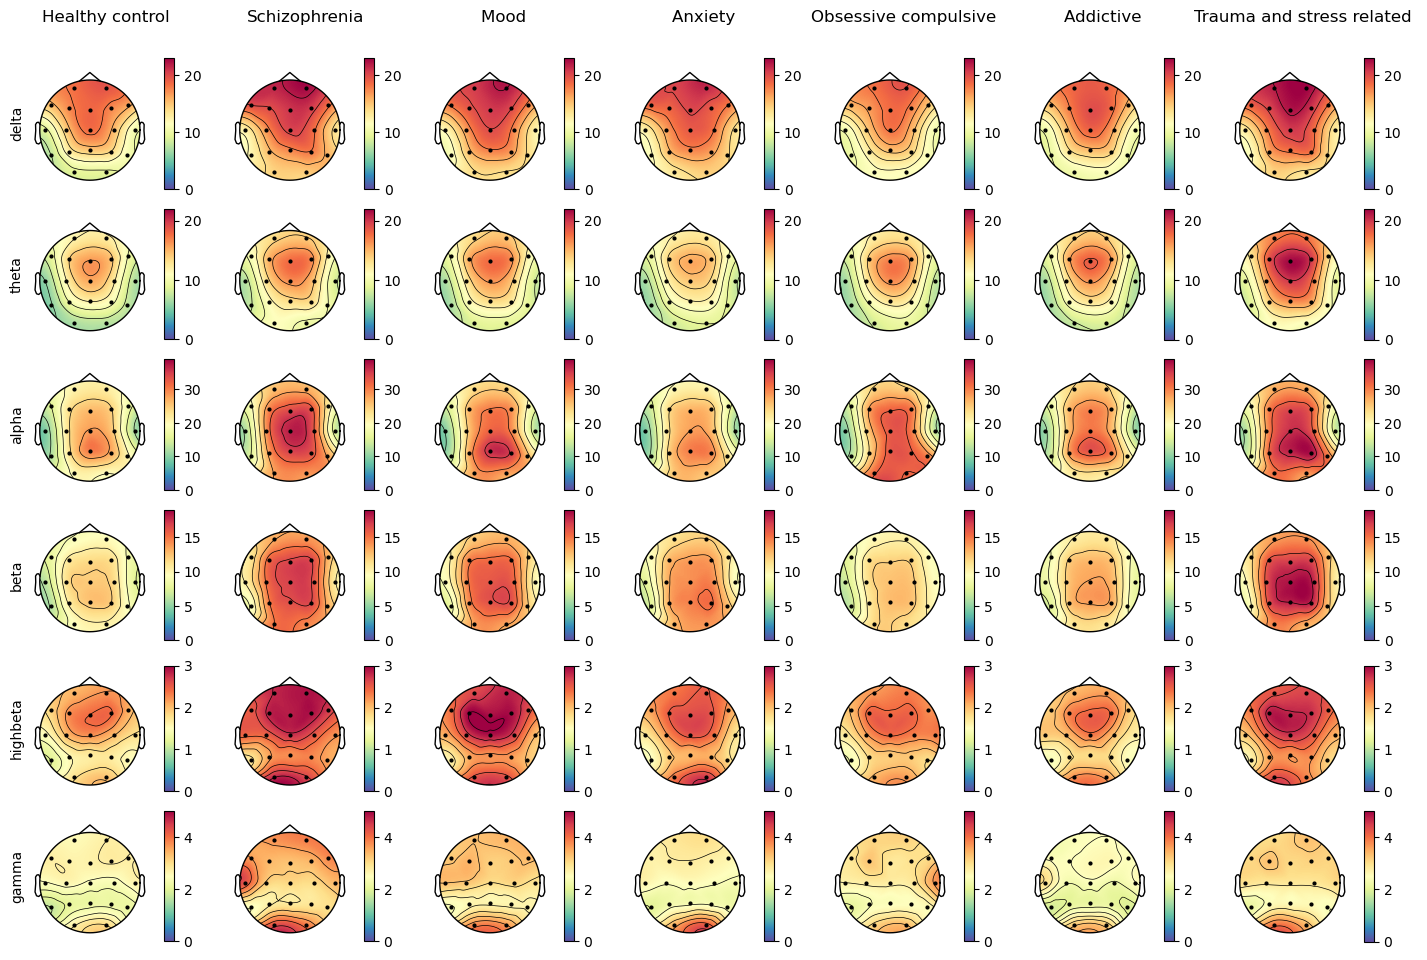

In [35]:
matplotlib.style.use('default')
# order conditions (main.disorder)
conds = ['Healthy control',
         'Schizophrenia', 
         'Mood disorder', 
         'Anxiety disorder',  
         'Obsessive compulsive disorder', 
         'Addictive disorder',
         'Trauma and stress related disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(main_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

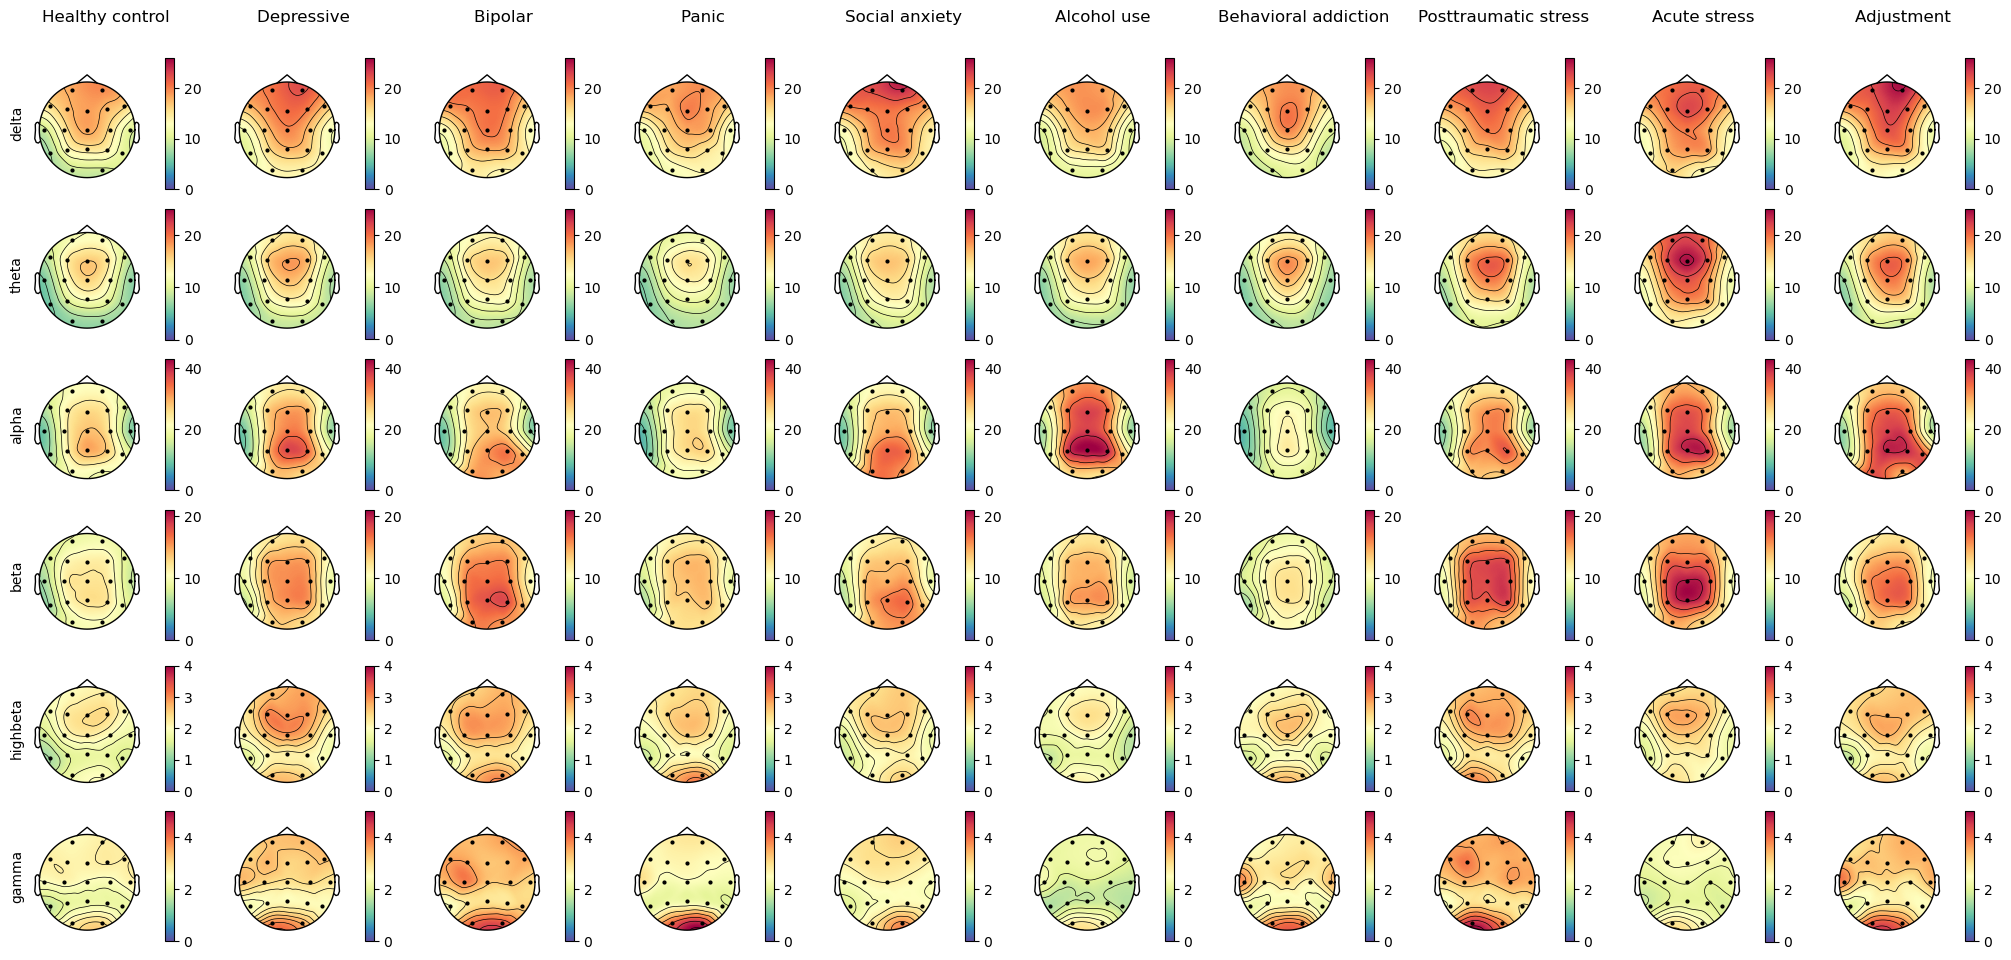

In [36]:
# order conditions (specific.disorder)
conds = ['Healthy control', 
         'Depressive disorder', 
         'Bipolar disorder',
         'Panic disorder',
         'Social anxiety disorder',
         'Alcohol use disorder',
         'Behavioral addiction disorder',
         'Posttraumatic stress disorder',
         'Acute stress disorder', 
         'Adjustment disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(spec_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

A lot of information to process here, but one key takeaway is that there are **readily apparent differences** in averaged QEEG PSD between people with different disorders.

Now, we prepare to pre-process our data for model testing and evaluation.

## Pre-Processing

To prepare our data for classification, we need to:
1. Drop the separation column and ID columns ('no.' and 'eeg.date')
2. Encode our target and categorical variables
3. Drop target variables from features
4. Fill missing data in education and IQ columns
5. Apply log transformation to Age, PSD, and FC features
6. Separate features and targets into a separate subset for binary classification (Disorder vs. Healthy Control)
7. Scale our features

In [37]:
X = eegData.drop([sepaCol, 'no.', 'eeg.date'], axis=1).copy(deep=True)
# target and categorical columns
target_col = ['main.disorder', 'specific.disorder']
cat_col = ['sex', 'main.disorder','specific.disorder']
# unique disorders
md_unique = eegData['main.disorder'].unique()
sd_unique = eegData['specific.disorder'].unique()
# make sure that healthy control is encoded as zero
hc = 'Healthy control'
# lists of disorders without healthy control
md = md_unique[md_unique != hc]
sd = sd_unique[sd_unique != hc]
md_ord = np.insert(md, 0, hc)
sd_ord = np.insert(sd, 0, hc)
sex_ord = eegData['sex'].unique()
# encoder for targets and sex
enc = OrdinalEncoder(categories=[sex_ord, md_ord, sd_ord])
X[cat_col] = enc.fit_transform(X[cat_col])
# save targets
md_target = X['main.disorder']
sd_target = X['specific.disorder']
# drop targets
X.drop(target_col, axis=1, inplace=True)
# fill missing data
mv_cols = ['education', 'IQ']
X[mv_cols] = imputer.fit_transform(X[mv_cols])
# numerical columns for log-transformation
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = np.log(X[logtrans_cols])

In [38]:
def sep_to_bin(features, target, target_ord, disorders, hc_id=0):
    assert len(features) == len(target)
    X = dict()
    Y = dict()
    for disorder in disorders:
        # find how target was coded
        disorder_id = np.where(target_ord == disorder)[0][0]
        # extract targets
        y = target[target.isin([hc_id, disorder_id])]
        y[y != hc_id] = 1
        # features
        x = features.loc[y.index]
        # save
        X[disorder] = x
        Y[disorder] = y
    return X, Y

def min_validation(features, target_name, disorders, hc_name='Healthy control'):
    # count number of rows per each target value
    counts = eegData[target_name].value_counts()
    # initialise result
    result = np.zeros(len(disorders), dtype='bool')
    for i, disorder in enumerate(disorders):
        # calculate size of dataset: disorder + healthy control
        hc_disorder_count = counts[hc_name] + counts[disorder]
        # update result
        result[i] = len(features[disorder]) == hc_disorder_count
    return result

# separate to binary classification subsets
Xmd, Ymd = sep_to_bin(X, md_target, md_ord, md)
Xsd, Ysd = sep_to_bin(X, sd_target, sd_ord, sd)

# validate length of subsets
assert min_validation(Xmd, 'main.disorder', md).all()
assert min_validation(Xsd, 'specific.disorder', sd).all()

## Model Selection

We now ask ourselves which algorithm will work the best with our dataset? To answer this, we will use cross-validation with 10 folds to choose the best algorithm for classification of each disorder.

Our consideration pool includes:
* Logistic Regression / ElasticNet
* SVM, Linear Kernel (for feature importance)
* Random Forest
* XGBoost

In [39]:
def lists_to_dict (keys, items):
    return {key: item for key,item in zip(keys, items)}

# models names
model_names = ['EN', 'SVM', 'RF', 'XGB']
# param grids for gridsearch
param_grids = [
    {
        'l1_ratio': np.linspace(0, 1, 5),
        'C': [0.5, 1, 5, 10]
    },
    {
        'C': [0.5, 1, 5, 10]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None], 
        
    }  
]
param_grids = lists_to_dict(model_names, param_grids)

# models for gridsearch
models = [
    LogisticRegression(penalty='elasticnet', solver='saga'),
    SVC(kernel='linear', random_state=77),
    RandomForestClassifier(random_state=77),
    XGBClassifier()
]
models = lists_to_dict(model_names, models)

In [40]:
def n_best (gs_res, n=1):
    """Returns nth best estimator parameters, mean score and std of it"""
    ind = np.where(gs_res['rank_test_score'] == n)[0][0]
    mu = gs_res["mean_test_score"][ind]
    std = gs_res["std_test_score"][ind]
    params = gs_res["params"][ind]
    return params, mu, std

def cache_mkdir(cache, directory, root_dir='.'):
    """Create directory and return path to it"""
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False):
    """Read from cache file"""
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    """Write to cache"""
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file)
    
def grid_search(disorders, models, params, Xs, Ys, random_seed=None, cache=True, cache_dir='grid_search', feature_list=None, silent=False):
    # result dict
    result = []
    # set feature list if None
    if feature_list is None:
        feature_list = X.columns
    # create cache directory if needed
    cache_mkdir(cache, cache_dir)
    for disorder in disorders:
        # get and create (if needed) a disorder cache directory
        disorder_folder = cache_mkdir(cache, disorder, cache_dir)
        for key in models.keys():
            print(disorder, key)
            # get cache file path
            cache_file = os.path.join(disorder_folder, key)
           # read file from cache
            res = read_cache(cache, cache_file, silent)
            if res is None:
                res = {}
                res['disorder'] = disorder
                res['algorithm'] = key
                # set seed
                if random_seed is not None:
                    np.random.seed(random_seed)
                # scale
                scaler = StandardScaler()
                x = scaler.fit_transform(Xs[disorder][feature_list])
                # gridsearch
                gs = GridSearchCV(models[key], params[key], cv=10, scoring='roc_auc', n_jobs=-1, verbose=1).fit(x, Ys[disorder])
                # best estimator parameters, cross validation mean score and score std
                res['params'], res['mean_score'], res['std_score'] = n_best(gs.cv_results_)
                # save cv_results_
                res['cv_result'] = deepcopy(gs.cv_results_)
                # cache results
                write_cache(cache, res, cache_file)
            result.append(res)
    return result

In [41]:
import warnings
warnings.filterwarnings('ignore')

### Main Disorders

We run our models on the main disorders:

In [ ]:
# run our models on disorder type
md_res_dict = grid_search(md, models, param_grids, Xmd, Ymd, 77)

In [43]:
# print out results
md_results = pd.DataFrame(md_res_dict)
md_results

disorder algorithm  \
0                   Addictive disorder        EN   
1                   Addictive disorder       SVM   
2                   Addictive disorder        RF   
3                   Addictive disorder       XGB   
4   Trauma and stress related disorder        EN   
5   Trauma and stress related disorder       SVM   
6   Trauma and stress related disorder        RF   
7   Trauma and stress related disorder       XGB   
8                        Mood disorder        EN   
9                        Mood disorder       SVM   
10                       Mood disorder        RF   
11                       Mood disorder       XGB   
12       Obsessive compulsive disorder        EN   
13       Obsessive compulsive disorder       SVM   
14       Obsessive compulsive disorder        RF   
15       Obsessive compulsive disorder       XGB   
16                       Schizophrenia        EN   
17                       Schizophrenia       SVM   
18                       Schizophrenia        RF   
19                       Schizophrenia       XGB   
20                    Anxiety disorder        EN   
21                    Anxiety disorder       SVM   
22                    Anxiety disorder        RF   
23                    Anxiety disorder       XGB   

                                               params  mean_score  std_score  \
0                         {'C': 0.5, 'l1_ratio': 1.0}    0.821696   0.134632   
1                                          {'C': 0.5}    0.767310   0.093457   
2            {'max_depth': None, 'n_estimators': 500}    0.788509   0.086534   
3   {'max_depth': 1, 'n_estimators': 100, 'subsamp...    0.824795   0.097353   
4                         {'C': 0.5, 'l1_ratio': 1.0}    0.827585   0.094401   
5                                          {'C': 0.5}    0.812115   0.068949   
6            {'max_depth': None, 'n_estimators': 500}    0.826282   0.109268   
7   {'max_depth': 6, 'n_estimators': 100, 'subsamp...    0.871923   0.120562   
8                         {'C': 0.5, 'l1_ratio': 1.0}    0.801877   0.166963   
9                                          {'C': 0.5}    0.778105   0.157415   
10           {'max_depth': None, 'n_estimators': 500}    0.792669   0.152891   
11  {'max_depth': 1, 'n_estimators': 300, 'subsamp...    0.813167   0.138147   
12                        {'C': 0.5, 'l1_ratio': 1.0}    0.588111   0.165280   
13                                         {'C': 0.5}    0.590944   0.164633   
14              {'max_depth': 6, 'n_estimators': 100}    0.633889   0.189414   
15  {'max_depth': 3, 'n_estimators': 300, 'subsamp...    0.670000   0.099193   
16                        {'C': 0.5, 'l1_ratio': 1.0}    0.869512   0.159847   
17                                         {'C': 0.5}    0.832593   0.153286   
18              {'max_depth': 3, 'n_estimators': 500}    0.808232   0.130762   
19  {'max_depth': 1, 'n_estimators': 100, 'subsamp...    0.924747   0.081403   
20                        {'C': 0.5, 'l1_ratio': 1.0}    0.842465   0.149481   
21                                         {'C': 0.5}    0.760495   0.135160   
22           {'max_depth': None, 'n_estimators': 500}    0.759566   0.202616   
23  {'max_depth': 1, 'n_estimators': 100, 'subsamp...    0.823545   0.176795   

                                            cv_result  
0   {'mean_fit_time': [0.3251760482788086, 0.52024...  
1   {'mean_fit_time': [0.050906133651733396, 0.063...  
2   {'mean_fit_time': [0.348442006111145, 1.044234...  
3   {'mean_fit_time': [42.31964719295502, 11.60573...  
4   {'mean_fit_time': [0.2562758207321167, 0.40427...  
5   {'mean_fit_time': [0.005011129379272461, 0.010...  
6   {'mean_fit_time': [0.17449288368225097, 0.5225...  
7   {'mean_fit_time': [58.53325395584106, 21.95749...  
8   {'mean_fit_time': [0.414448881149292, 7.941038...  
9   {'mean_fit_time': [0.05820119380950928, 0.1127...  
10  {'mean_fit_time': [2.318838286399841, 6.482262...  
11  {'mean_fit_time': [48.33131105899811, 86.40606...  


### Specific Disorders

Now we run them on our specific disorders:

In [ ]:
# run our models on specific disorder
sd_res_dict = grid_search(sd, models, param_grids, Xsd, Ysd, 77)

In [45]:
# print our results
sd_results = pd.DataFrame(sd_res_dict)
sd_results

disorder algorithm  \
0            Alcohol use disorder        EN   
1            Alcohol use disorder       SVM   
2            Alcohol use disorder        RF   
3            Alcohol use disorder       XGB   
4           Acute stress disorder        EN   
5           Acute stress disorder       SVM   
6           Acute stress disorder        RF   
7           Acute stress disorder       XGB   
8             Depressive disorder        EN   
9             Depressive disorder       SVM   
10            Depressive disorder        RF   
11            Depressive disorder       XGB   
12  Behavioral addiction disorder        EN   
13  Behavioral addiction disorder       SVM   
14  Behavioral addiction disorder        RF   
15  Behavioral addiction disorder       XGB   
16  Obsessive compulsive disorder        EN   
17  Obsessive compulsive disorder       SVM   
18  Obsessive compulsive disorder        RF   
19  Obsessive compulsive disorder       XGB   
20                  Schizophrenia        EN   
21                  Schizophrenia       SVM   
22                  Schizophrenia        RF   
23                  Schizophrenia       XGB   
24                 Panic disorder        EN   
25                 Panic disorder       SVM   
26                 Panic disorder        RF   
27                 Panic disorder       XGB   
28        Social anxiety disorder        EN   
29        Social anxiety disorder       SVM   
30        Social anxiety disorder        RF   
31        Social anxiety disorder       XGB   
32  Posttraumatic stress disorder        EN   
33  Posttraumatic stress disorder       SVM   
34  Posttraumatic stress disorder        RF   
35  Posttraumatic stress disorder       XGB   
36            Adjustment disorder        EN   
37            Adjustment disorder       SVM   
38            Adjustment disorder        RF   
39            Adjustment disorder       XGB   
40               Bipolar disorder        EN   
41               Bipolar disorder       SVM   
42               Bipolar disorder        RF   
43               Bipolar disorder       XGB   

                                               params  mean_score  std_score  \
0                         {'C': 0.5, 'l1_ratio': 1.0}    0.878642   0.091731   
1                                          {'C': 0.5}    0.839877   0.111033   
2            {'max_depth': None, 'n_estimators': 500}    0.795185   0.140373   
3   {'max_depth': 6, 'n_estimators': 100, 'subsamp...    0.836420   0.129505   
4                         {'C': 0.5, 'l1_ratio': 1.0}    0.790833   0.157655   
5                                          {'C': 0.5}    0.793333   0.150114   
6               {'max_depth': 1, 'n_estimators': 100}    0.819444   0.124238   
7   {'max_depth': 3, 'n_estimators': 100, 'subsamp...    0.866389   0.144756   
8                         {'C': 0.5, 'l1_ratio': 1.0}    0.808591   0.144052   
9                                          {'C': 0.5}    0.764728   0.149785   
10           {'max_depth': None, 'n_estimators': 300}    0.785284   0.140311   
11  {'max_depth': 3, 'n_estimators': 100, 'subsamp...    0.828012   0.116551   
12                        {'C': 0.5, 'l1_ratio': 1.0}    0.820988   0.099523   
13                                         {'C': 0.5}    0.733951   0.089006   
14           {'max_depth': None, 'n_estimators': 300}    0.721111   0.096736   
15  {'max_depth': 1, 'n_estimators': 100, 'subsamp...    0.790000   0.114564   
16                        {'C': 0.5, 'l1_ratio': 1.0}    0.588111   0.165280   
17                                         {'C': 0.5}    0.590944   0.164633   
18              {'max_depth': 6, 'n_estimators': 100}    0.633889   0.189414   
19  {'max_depth': 3, 'n_estimators': 300, 'subsamp...    0.670000   0.099193   
20                        {'C': 0.5, 'l1_ratio': 1.0}    0.869512   0.159847   
21                                         {'C': 0.5}    0.832593   0.153286   
22              {'max_depth': 3, 'n_estimators': 500}    0.808232   0

In [46]:
# summarise and evaluate model performance
def combine (x, y):
    return x.astype(str) + ' (' + y.astype(str) + ')'
    
def report_scores (df, index='disorder', columns='algorithm'):
    df['mean_std'] = combine(df['mean_score'].round(2), df['std_score'].round(2))
    return df.pivot_table(values=['mean_std'], columns=columns, index=index, aggfunc=lambda x: ' '.join(x))

In [47]:
# report scores for disorder type
report_scores(md_results)

mean_std                            \
algorithm                                    EN           RF          SVM   
disorder                                                                    
Addictive disorder                  0.82 (0.13)  0.79 (0.09)  0.77 (0.09)   
Anxiety disorder                    0.84 (0.15)   0.76 (0.2)  0.76 (0.14)   
Mood disorder                        0.8 (0.17)  0.79 (0.15)  0.78 (0.16)   
Obsessive compulsive disorder       0.59 (0.17)  0.63 (0.19)  0.59 (0.16)   
Schizophrenia                       0.87 (0.16)  0.81 (0.13)  0.83 (0.15)   
Trauma and stress related disorder  0.83 (0.09)  0.83 (0.11)  0.81 (0.07)   

                                                 
algorithm                                   XGB  
disorder                                         
Addictive disorder                   0.82 (0.1)  
Anxiety disorder                    0.82 (0.18)  
Mood disorder                       0.81 (0.14)  
Obsessive compulsive disorder        0.67 (0.1)  
Schizophrenia                       0.92 (0.08)  
Trauma and stress related disorder  0.87 (0.12)

In [48]:
# report scores for specific disorder
report_scores(sd_results)

mean_std                            \
algorithm                               EN           RF          SVM   
disorder                                                               
Acute stress disorder          0.79 (0.16)  0.82 (0.12)  0.79 (0.15)   
Adjustment disorder              0.8 (0.2)  0.81 (0.17)  0.75 (0.21)   
Alcohol use disorder           0.88 (0.09)   0.8 (0.14)  0.84 (0.11)   
Behavioral addiction disorder   0.82 (0.1)   0.72 (0.1)  0.73 (0.09)   
Bipolar disorder               0.75 (0.18)  0.77 (0.18)  0.74 (0.17)   
Depressive disorder            0.81 (0.14)  0.79 (0.14)  0.76 (0.15)   
Obsessive compulsive disorder  0.59 (0.17)  0.63 (0.19)  0.59 (0.16)   
Panic disorder                 0.83 (0.17)  0.75 (0.21)  0.73 (0.18)   
Posttraumatic stress disorder  0.87 (0.17)  0.82 (0.15)  0.77 (0.12)   
Schizophrenia                  0.87 (0.16)  0.81 (0.13)  0.83 (0.15)   
Social anxiety disorder        0.82 (0.11)  0.76 (0.14)   0.8 (0.13)   

                                            
algorithm                              XGB  
disorder                                    
Acute stress disorder          0.87 (0.14)  
Adjustment disorder            0.92 (0.11)  
Alcohol use disorder           0.84 (0.13)  
Behavioral addiction disorder  0.79 (0.11)  
Bipolar disorder                0.82 (0.1)  
Depressive disorder            0.83 (0.12)  
Obsessive compulsive disorder   0.67 (0.1)  
Panic disorder                  0.79 (0.2)  
Posttraumatic stress disorder  0.88 (0.14)  
Schizophrenia                  0.92 (0.08)  
Social anxiety disorder        0.86 (0.12)

### Conclusions

We see from the score reports that each algorithm showed good performance above simple chance (>0.5) across all disorders. The worst result of this batch is Obsessive compulsive disorder, which can be explained by the high percentage of missing values and small sample size.

We now look into PSD and FC feature importance for the best performing estimator within each disorder:
* **Acute stress disorder**: XGBoost, score of 0.87
* **Adjustment disorder**: XGBoost, score of 0.92
* **Alcohol use disorder**: Logistic Regression (ElasticNet), score of 0.88
* **Behavioral addiction disorder**: Logistic Regression (ElasticNet), score of 0.82
* **Bipolar disorder**: XGBoost, score of 0.82
* **Depressive disorder**: XGBoost, score of 0.83
* **Obsessive compulsive disorder**: XGBoost, score of 0.67
* **Panic disorder**: Logistic Regression (ElasticNet), score of 0.83
* **Posttraumatic stress disorder**: XGBoost, score of 0.88
* **Schizophrenia**: XGBoost, score of 0.92
* **Social anxiety disorder**: XGBoost, score of 0.86

In [49]:
# define our chosen models for each disorder / category type
chosen_models = {
    'Acute stress disorder': 'XGB',
    'Adjustment disorder': 'XGB',
    'Alcohol use disorder': 'EN',
    'Behavioral addiction disorder': 'EN',
    'Bipolar disorder': 'XGB',
    'Depressive disorder': 'XGB',
    'Obsessive compulsive disorder': 'XGB',
    'Panic disorder': 'EN',
    'Posttraumatic stress disorder': 'XGB',
    'Schizophrenia': 'XGB',
    'Social anxiety disorder': 'XGB',
    'Addictive disorder': 'EN',
    'Anxiety disorder': 'EN',
    'Mood disorder': 'XGB',
    'Trauma and stress related disorder': 'XGB'
}

## Feature Importance

To report feature importance, we will use our best performing models and some hyper-parameters, performing 10-fold cross-validation and recording feature importance for each run. We will calculate three main statistics: sum, mean, and survival rate[1]. 

[1]: *Survival rate* is the percentage of times a specific feature had values above threshold, which in our case, is 0.

In [50]:
# code block generated partially by chatGPT
def extract_fi(model):
    """Extract feature importance from different algorithms"""
    if isinstance(model, LogisticRegression) or isinstance(model, SVC):
        fi = model.coef_[0]
    else:
        fi = model.feature_importances_
    return fi

def get_row(result, disorder, algorithm):
    return result[(result['disorder'] == disorder) & (result['algorithm'] == algorithm)].squeeze()

def get_model(row, models=models):
    model = deepcopy(models[row['algorithm']])
    model.set_params(**row['params'])
    return model

def cv_fi(x, y, model, random_state=None, n=10, debug=False):
    feature_names = x.columns
    cv_results = dict()
    # split counter
    i = 1
    # KFold splitting
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=random_state)
    for train_index, test_index in skf.split(x, y):
        # get train x and y
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        # scale features
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        # fit model
        model.fit(x_train, y_train)
        # save feature importance
        cv_results[f'split{i}_fi'] = extract_fi(model)
        # debug
        if debug:
            # get test x and y
            x_test, y_test = x.iloc[test_index], y.iloc[test_index]
            # scale
            x_test = scaler.transform(x_test)
            # predict
            y_pred = model.predict(x_test)
            # show results
            print(f'Split {i} report')
            print(classification_report(y_test, y_pred))
        # iterate split counter
        i += 1
    result = pd.DataFrame(cv_results, index=feature_names)
    return(result)

def psd_coh(name, sep='.'):
    splt = name.split(sep=sep)
    if len(splt) < 3:
        if len(splt) == 1:
            result = name
        else:
            result = f'{splt[0]} PSD'
    else:
        result = f'{splt[1]} FC'
    return result

def summary_fi_table(table, threshold=0):
    # rename index
    table.index.name = 'feature'
    # reset index and convert to long format
    table = table.reset_index().melt(id_vars='feature', var_name='split_id', value_name='importance')
    # negative importance?
    n_imp = (table['importance'] < 0).any()
    # if importance is above the threshold than survived=1, 0 othervise
    table['survived'] = (table['importance'].abs() > threshold)
    # feature category
    table['feature_cat'] = table['feature'].apply(psd_coh)
    # summary table
    result = table.groupby(['feature_cat', 'feature']).agg({
        'importance': ['sum', 'mean', 'median'],
        'survived': 'mean'
    })
    return result

def flatten_columns(table):
    """Flatten column indices"""
    table.columns = ['_'.join(col) for col in table.columns.values]
    return table

def top_n(table, n=15, col='importance_sum', survival_thres=0.7, abs_based=True):
    """Report n top important features"""
    if abs_based:
        table['abs_col'] = table[col].abs()
        col='abs_col'
    result = table[table['survived_mean'] >= survival_thres].sort_values(col, ascending=False).iloc[:n]
    return result

def do_cv_fi(disorders, results, Xs, Ys, n=15, survival_thres=0.7, disorder_model=chosen_models, random_state=None, 
               cache=True, cache_dir='cv_fi', exclude=['sex', 'age', 'education', 'IQ']):
    # create cache directory
    cache_mkdir(cache, cache_dir)
    result = dict()
    for disorder in disorders:
        # cache file path
        cache_file = os.path.join(cache_dir, disorder.replace(' ', '_'))
        # read from cache
        fi = read_cache(cache, cache_file)
        if fi is None:
            # get model
            model_name = disorder_model[disorder]
            row = get_row(results, disorder, model_name)
            model = get_model(row)
            # get feature importance of all cv folds
            fi = cv_fi(Xs[disorder], Ys[disorder], model, random_state)
            # write cache
            write_cache(cache, fi, cache_file)
        # exclude features
        fi = fi[~fi.index.isin(exclude)]
        result[disorder] = fi
    return result 

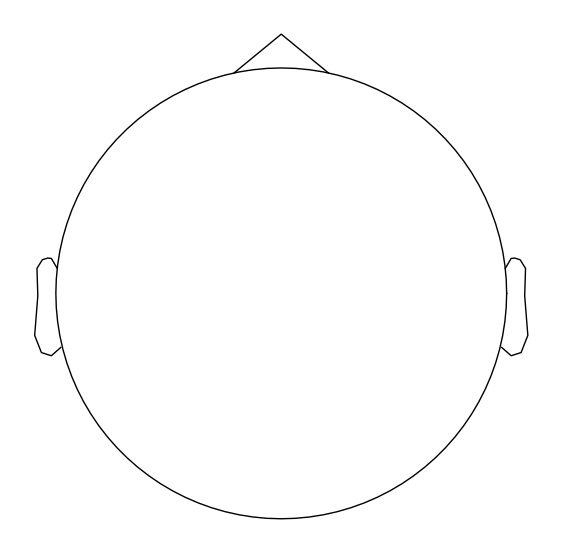

In [51]:
# code block generated partially by chatGPT
# generate head picture for visualisations
mtg_chan = {'FP1': [-0.03, 0.08, 0],
 'FP2': [0.03, 0.08, 0],
 'F7': [-0.073, 0.047, 0],
 'F3': [-0.04, 0.041, 0],
 'Fz': [0, 0.038, 0],
 'F4': [0.04, 0.041, 0],
 'F8': [0.073, 0.047, 0],
 'T3': [-0.085, 0, 0],
 'C3': [-0.045, 0, 0],
 'Cz': [0, 0, 0],
 'C4': [0.045, 0, 0],
 'T4': [0.085, 0, 0],
 'T5': [-0.073, -0.047, 0],
 'P3': [-0.04, -0.041, 0],
 'Pz': [0, -0.038, 0],
 'P4': [0.04, -0.041, 0],
 'T6': [0.07, -0.047, 0],
 'O1': [-0.03, -0.08, 0],
 'O2': [0.03, -0.08, 0]}

info = mne.create_info(list(mtg_chan.keys()), 500, ch_types='eeg')
montage = mne.channels.make_dig_montage(mtg_chan)
info.set_montage(montage)
fig, ax = plt.subplots(figsize=(7,7))
mne.viz.plot_sensors(info, ch_type='eeg', pointsize=0, axes=ax)
fig.savefig('head.png', bbox_inches='tight', transparent=True)
plt.style.use('default')

In [52]:
# code block generated partially by chatGPT
def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(x)
        ax.set_ylabel(heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.invert_yaxis()
        ax.set_ylabel(x)
        ax.set_xlabel(heights)
    if xlab is not None:
        ax.set_xlabel(xlab)
    if ylab is not None:
        ax.set_ylabel(ylab)
    if color is not None:
        colors = [palette[cat] for cat in table.feature_cat]
        patches = [mpatches.Patch(color=c, label=ftr_cat) for ftr_cat, c in palette.items()]
        ax.legend(patches, palette.keys())
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)        
    return ax

# Ensure consistent coloration
feature_category = [
    'delta PSD',
    'delta FC',
    'theta PSD',
    'theta FC',
    'alpha PSD',
    'alpha FC',
    'beta PSD',
    'beta FC',
    'highbeta PSD',
    'highbeta FC',
    'gamma PSD',
    'gamma FC']
cmap = plt.get_cmap('tab20')
palette = {feature_category[i]: cmap.colors[i] for i in range(len(feature_category))}

# position of channels on EEG map
chs = {
    'FP1': [-0.2625, 0.6300000000000001],
    'FP2': [0.2625, 0.6300000000000001],
    'F7': [-0.6387499999999999, 0.34125],
    'F3': [-0.35000000000000003, 0.28875],
    'Fz': [0.0, 0.2625],
    'F4': [0.35000000000000003, 0.28875],
    'F8': [0.6387499999999999, 0.34125],
    'T3': [-0.74375, -0.07],
    'C3': [-0.39375, -0.07],
    'Cz': [0.0, -0.07],
    'C4': [0.39375, -0.07],
    'T4': [0.74375, -0.07],
    'T5': [-0.6387499999999999, -0.48125],
    'P3': [-0.35000000000000003, -0.42875],
    'Pz': [0.0, -0.4025],
    'P4': [0.35000000000000003, -0.42875],
    'T6': [0.6125, -0.48125],
    'O1': [-0.2625, -0.77],
    'O2': [0.2625, -0.77]}
channels = pd.DataFrame(chs).transpose()

sns.set_style('whitegrid')

def extract_channel(feature):
    """
    Extract channels from QEEG feature names
    Examples:
    delta.T4 -> T4
    COH.delta.Cz.T4 -> [Cz, T4]
    """
    split = feature.split(sep='.')
    if split[0] == 'COH':
        result = split[2:4]
    else:
        result = split[-1]
    return result

def get_channels(features):
    """
    Get channels from comma separated feature names.
    Examples:
    delta.T4, COH.delta.Cz.T4 -> [T4, [Cz, T4]]    
    """
    split = features.split(sep=',')
    result = [extract_channel(ftr) for ftr in split]
    return np.array(result)

def get_coordinates(channels_arr):
    """Extract x and y coordinates by channel names"""
    selected = channels.loc[channels_arr]
    x, y = selected.iloc[:, 0], selected.iloc[:, 1]
    return x,y

def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, feature_cat, axes[1], palette, xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]        
    barchart(table, feature, importance, feature_cat, axes[0], palette, xlab='importance')        
    return figure

def fi_viz_eeg(table,  palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read backgroud image
    im = plt.imread('head.png')
    if ax is not None:
        separate=False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    # Plot 
    ftrcat_channels  = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                if i == 0:
                    lab = ftr_cat
                else:
                    lab = None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)
                
    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',  
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)
    

def report_fi(res_tab, disorder, col='importance_sum', survival_thres=0.7, palette=palette, root_dir=None):  
    # extract top n features
    table = top_n(flatten_columns(summary_fi_table(res_tab)), survival_thres=survival_thres).reset_index()
    # recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}
    # barchart feature and category importance 
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'feature', 'feature_cat', col, palette, fig1)
    fig1.tight_layout()
    # Plot feature importance on EEG map
    fig2 = plt.figure(tight_layout=True, figsize=(15, 7))
    fi_viz_eeg(table, figure=fig2, palette=palette)
    fig2.tight_layout()
    # root directory for saving plots to files
    if root_dir is not None:
        save_dir = cache_mkdir(True, disorder.replace(' ', '_'), root_dir)
        img_path = os.path.join(save_dir, 'fi1.png')
        fig1.savefig(img_path, bbox_inches='tight')
        img_path = os.path.join(save_dir, 'fi2.png')
        fig2.savefig(img_path, bbox_inches='tight')

In [ ]:
# gather our feature importance data
md_cv = do_cv_fi(md, md_results, Xmd, Ymd, random_state=77)

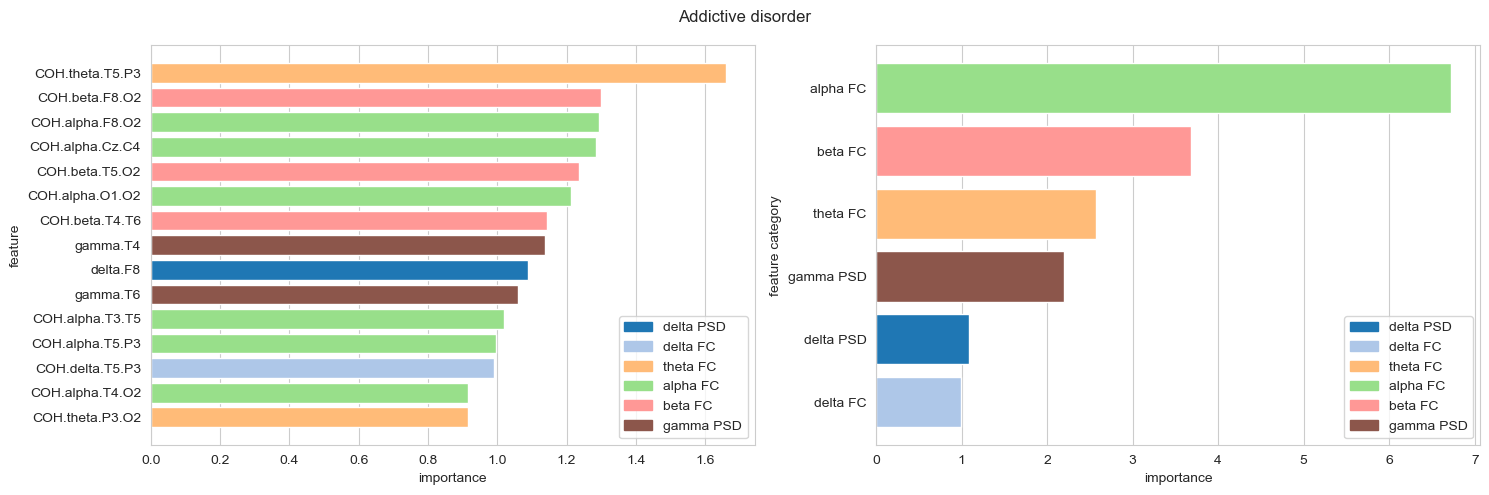

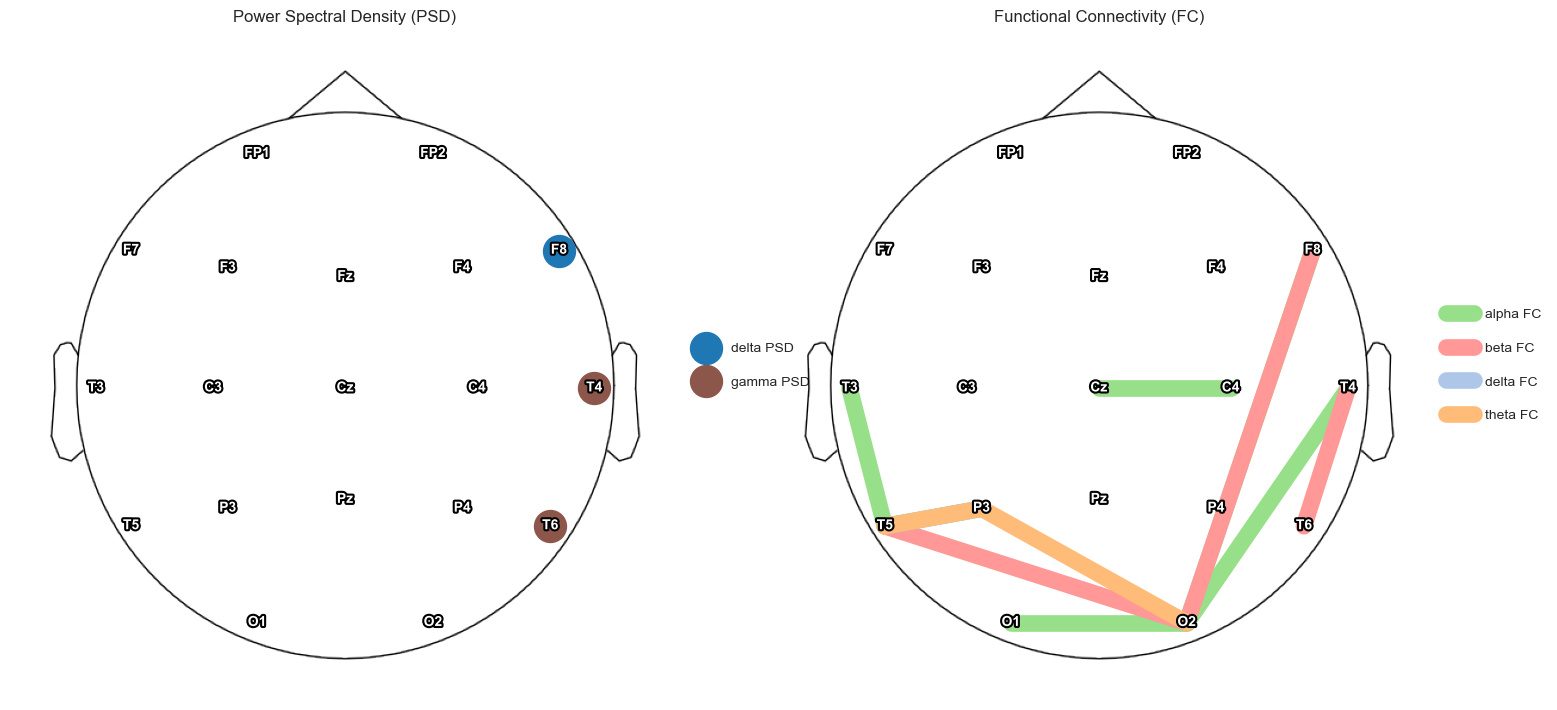

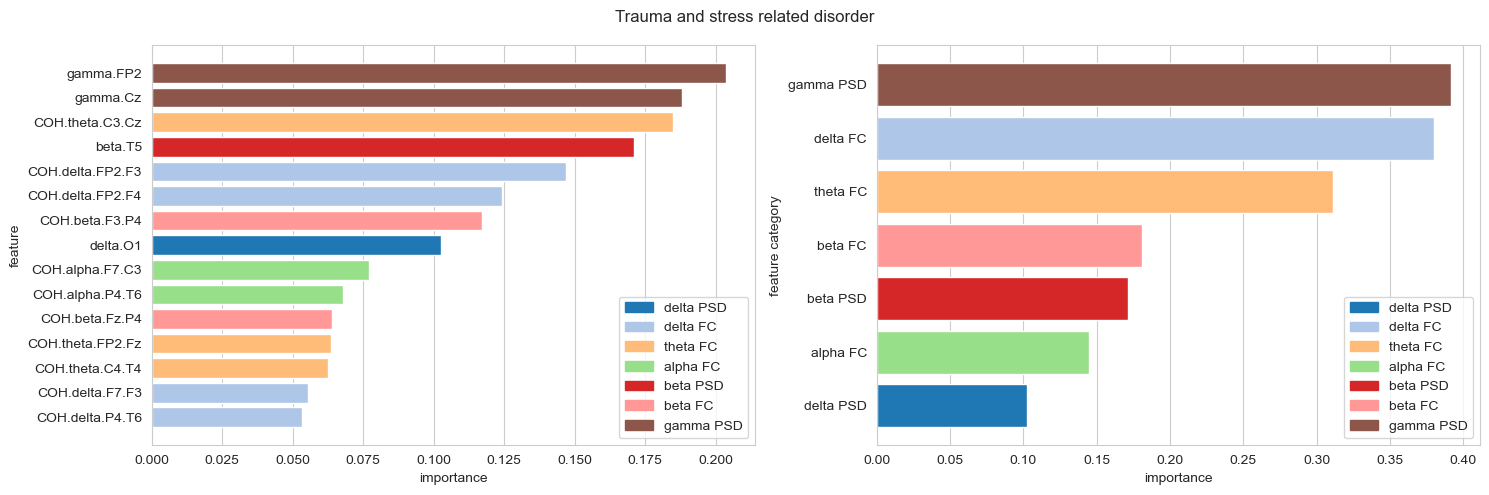

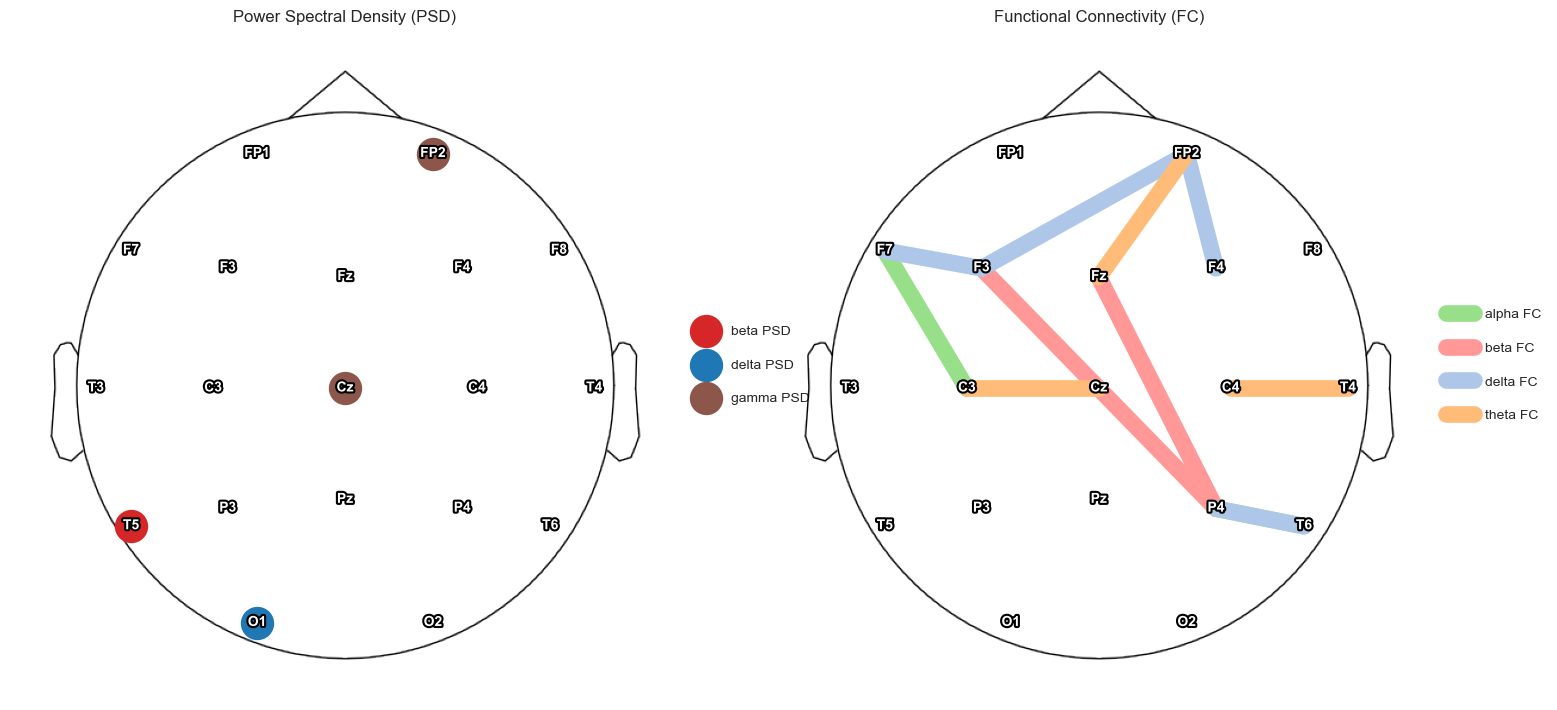

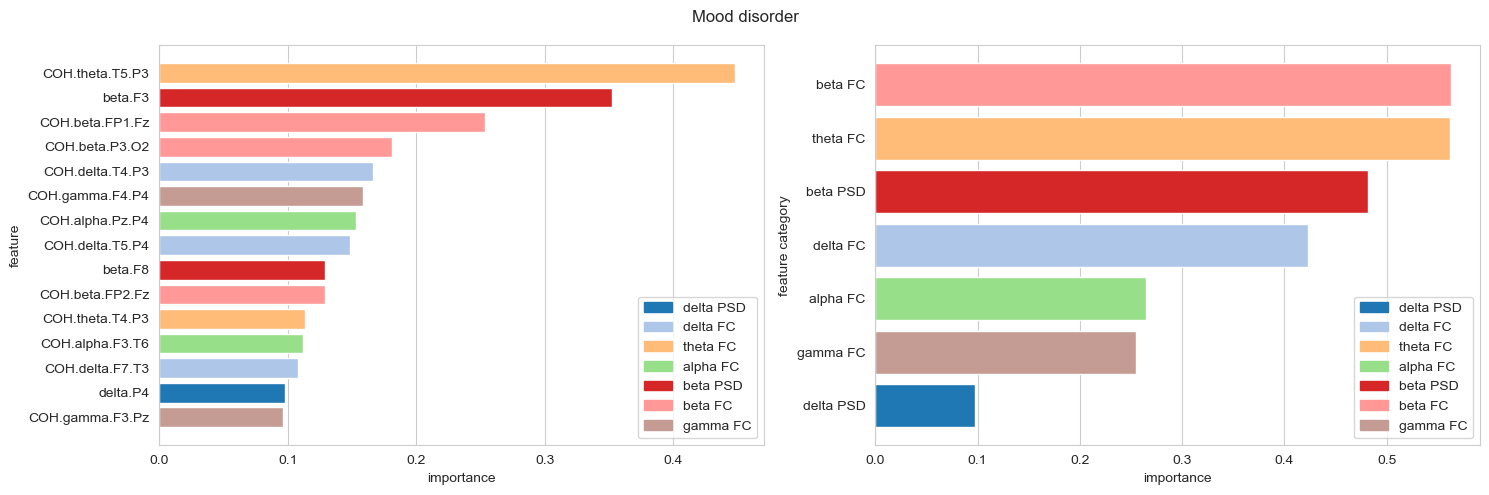

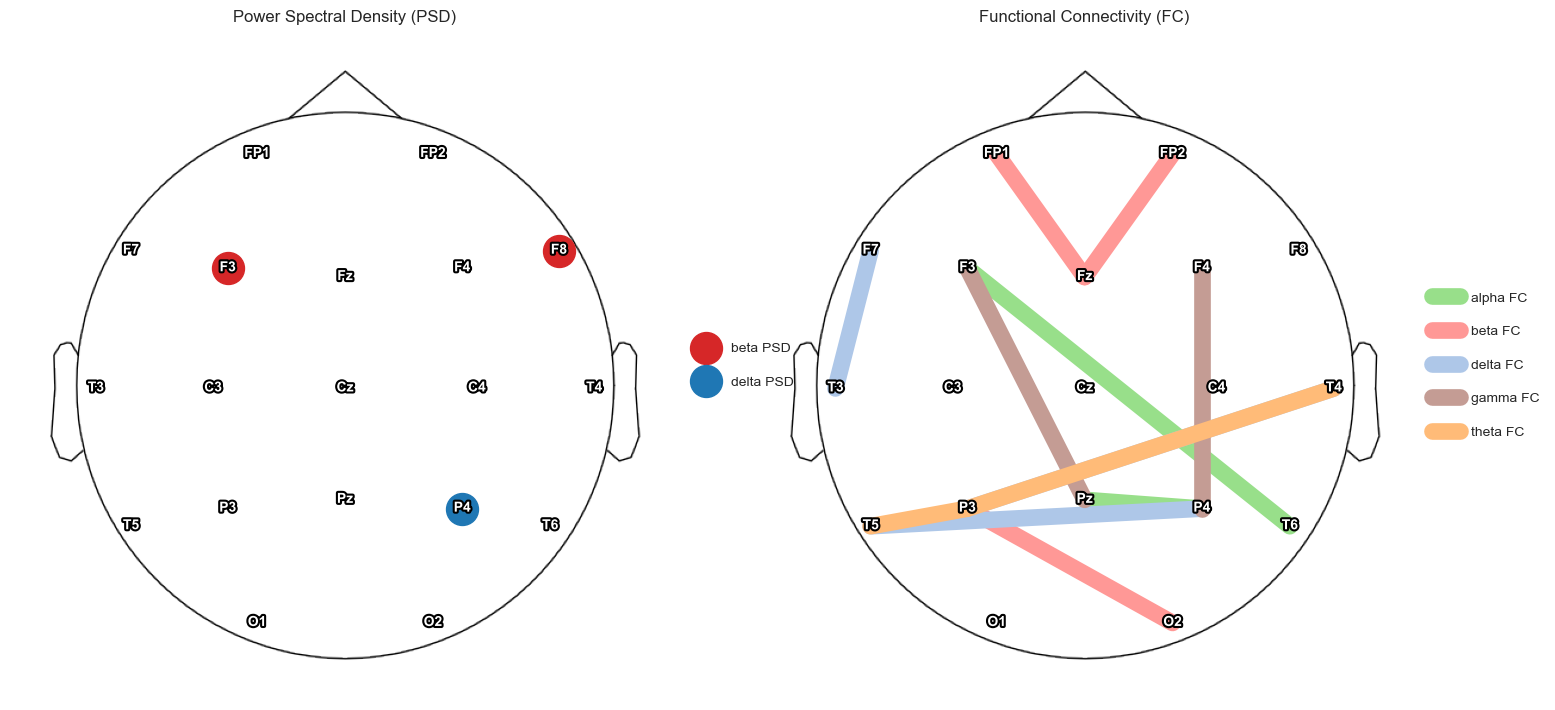

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


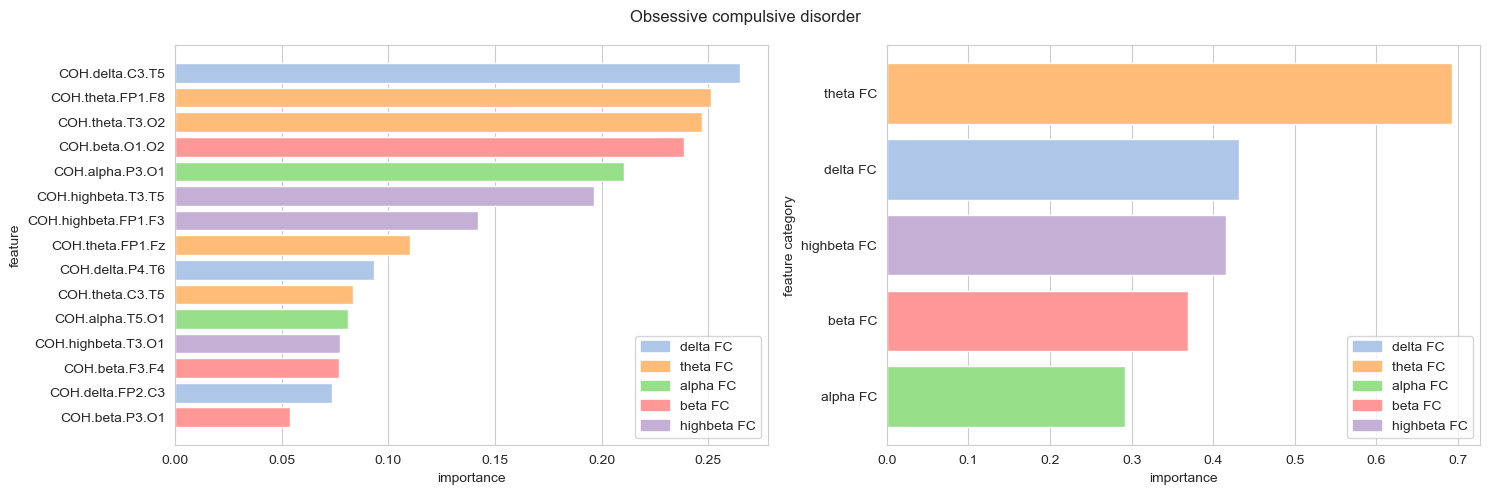

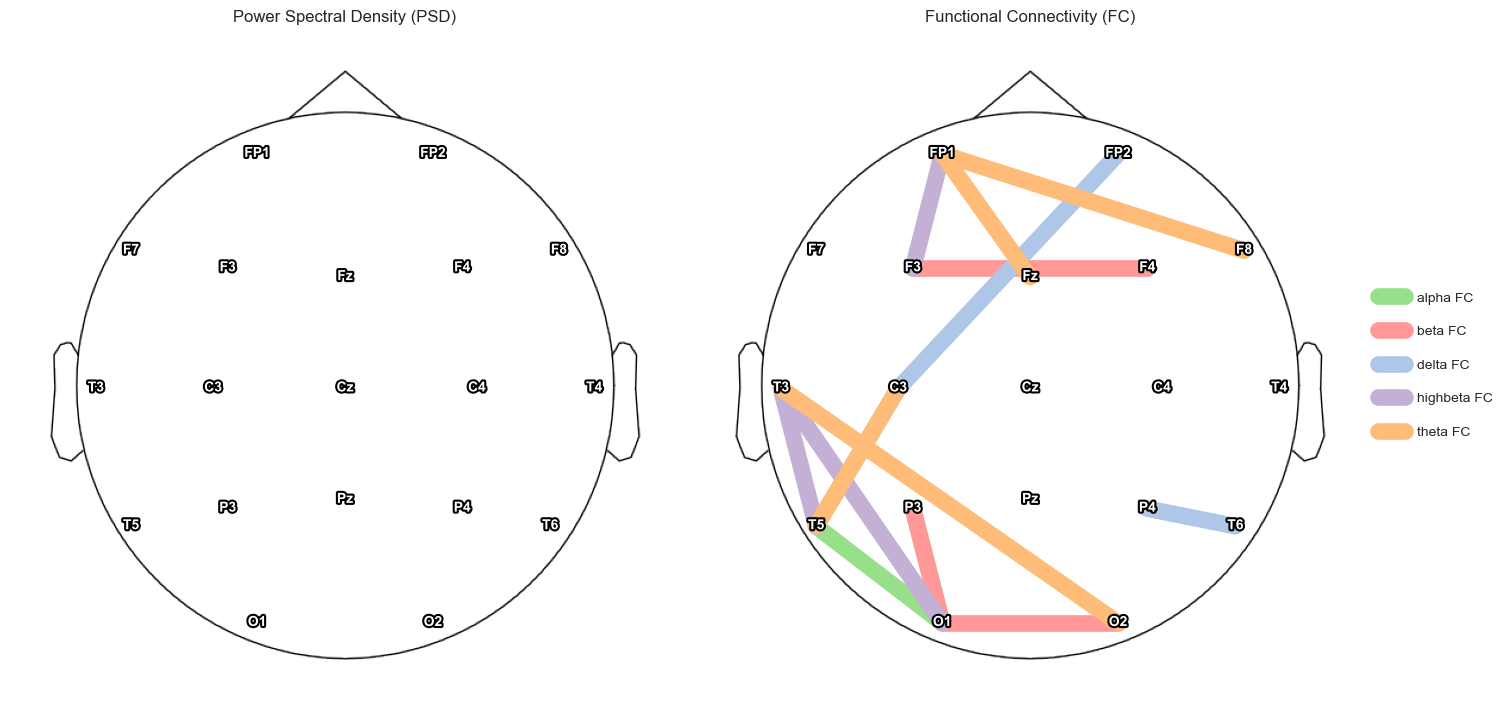

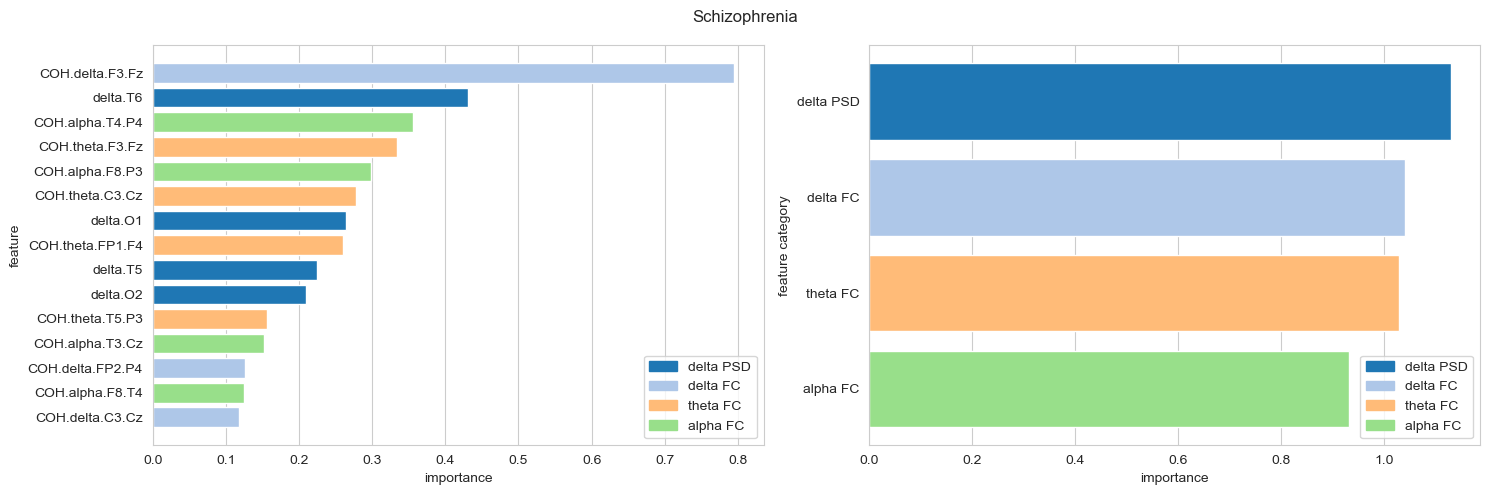

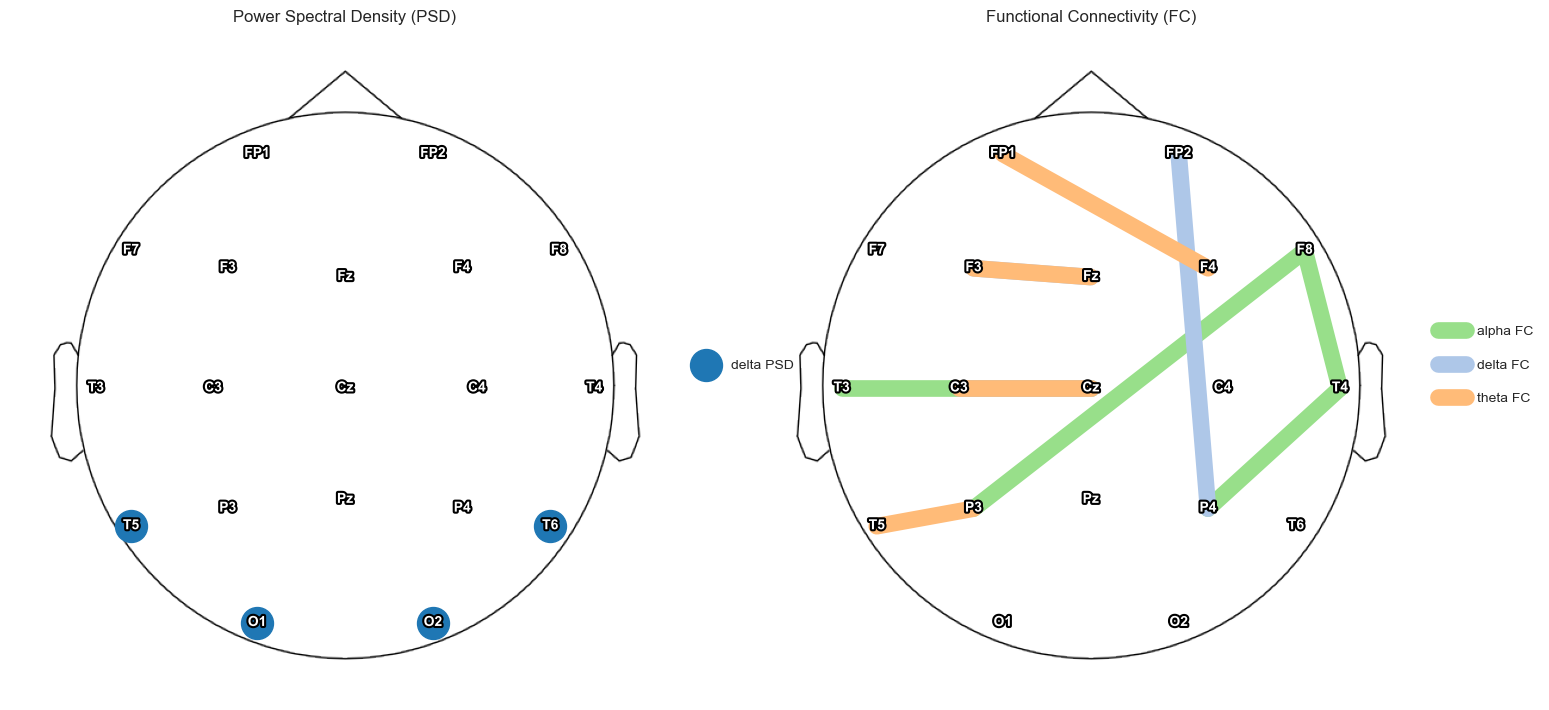

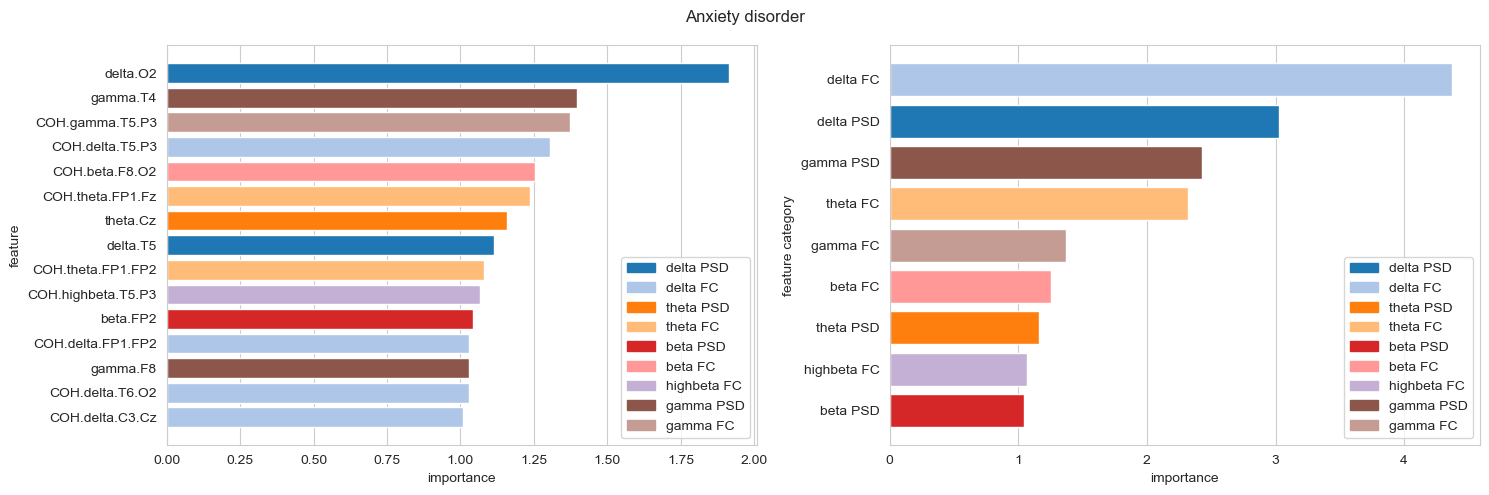

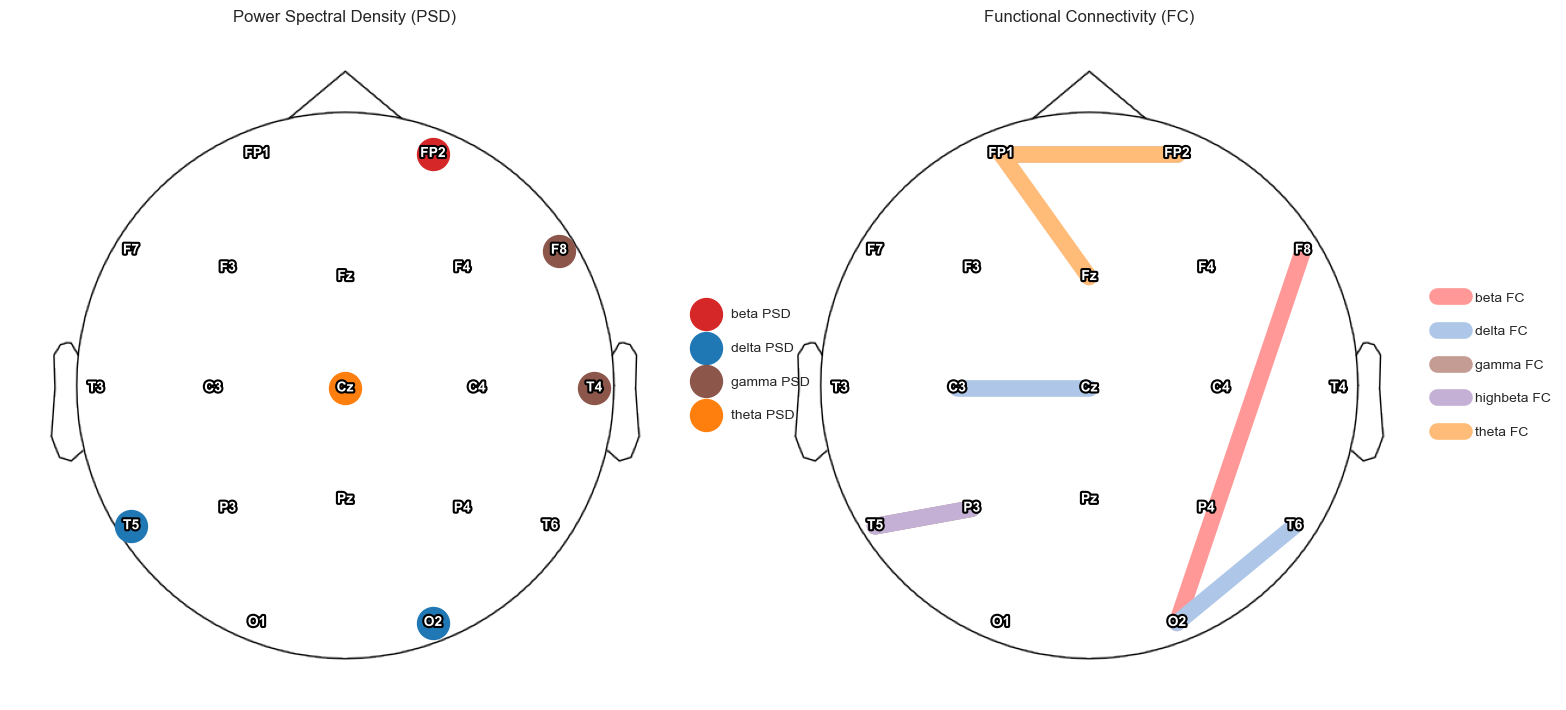

In [54]:
# plot our feature importance
for key, item in md_cv.items():
    fig = report_fi(item, key, 'abs_col', root_dir='viz')
    plt.show()

In [ ]:
# gather our feature importance data
sd_cv = do_cv_fi(sd, sd_results, Xsd, Ysd, random_state=77)

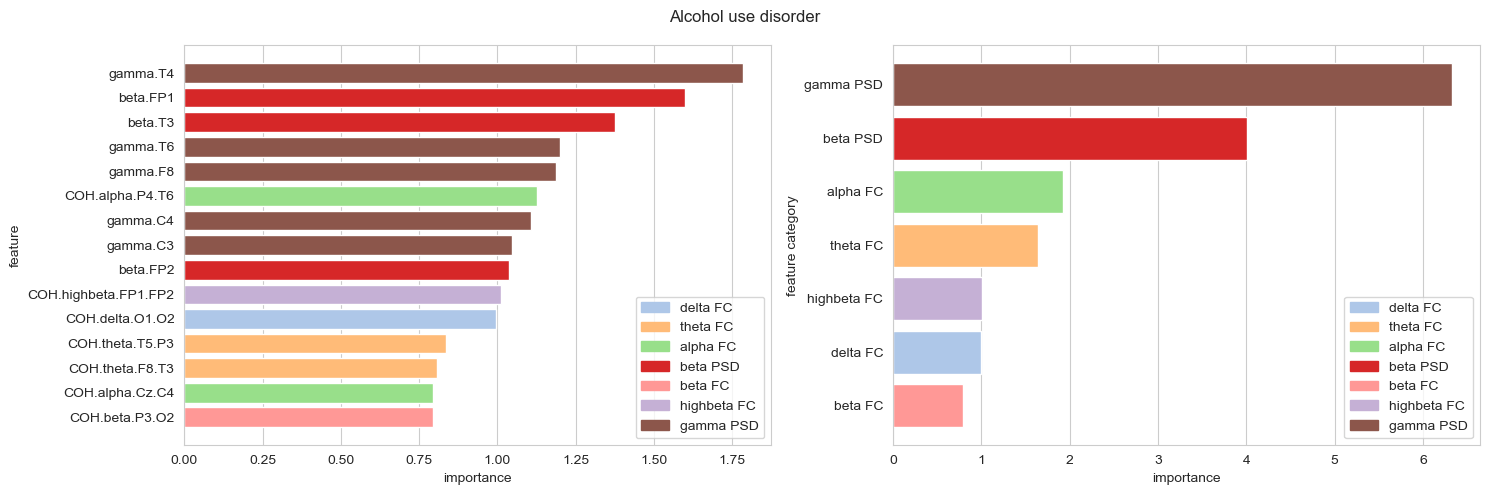

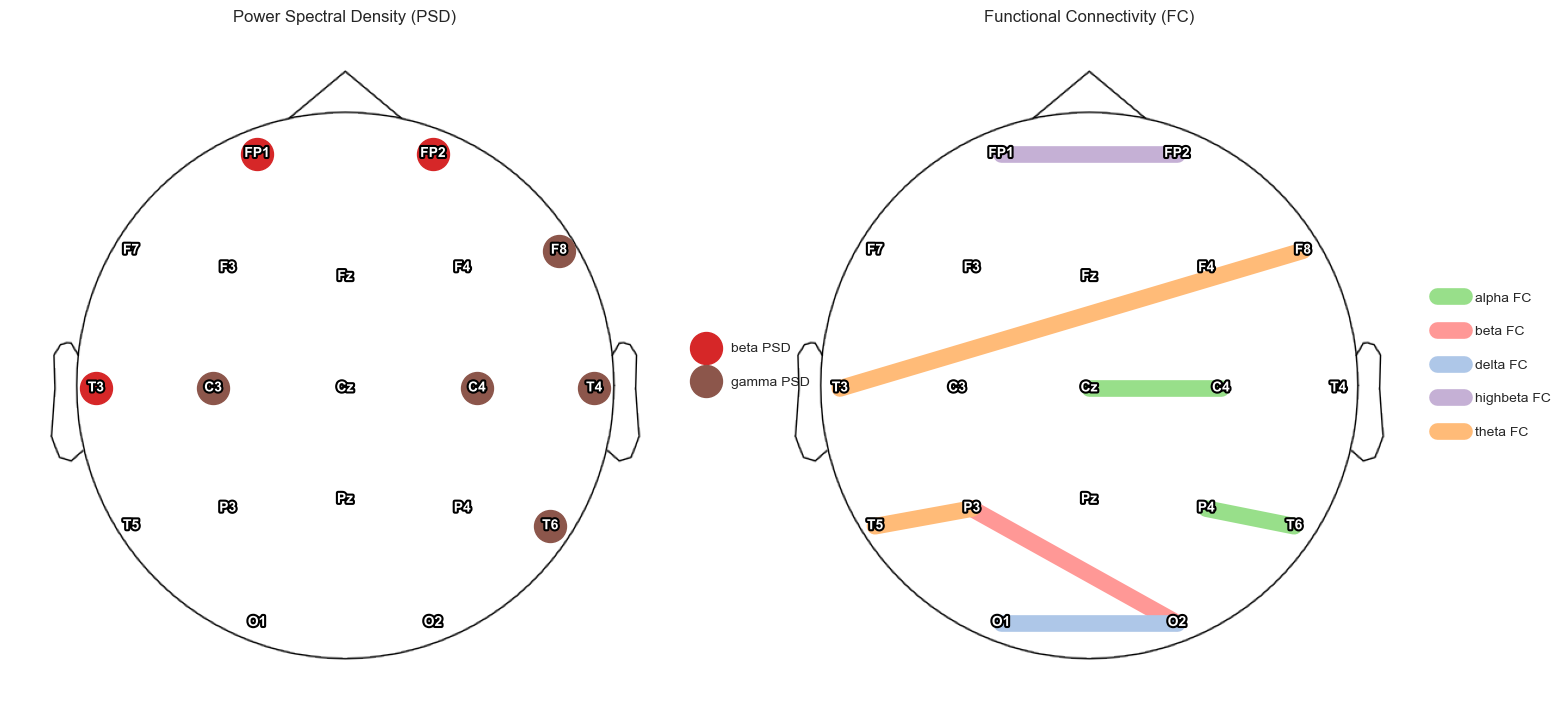

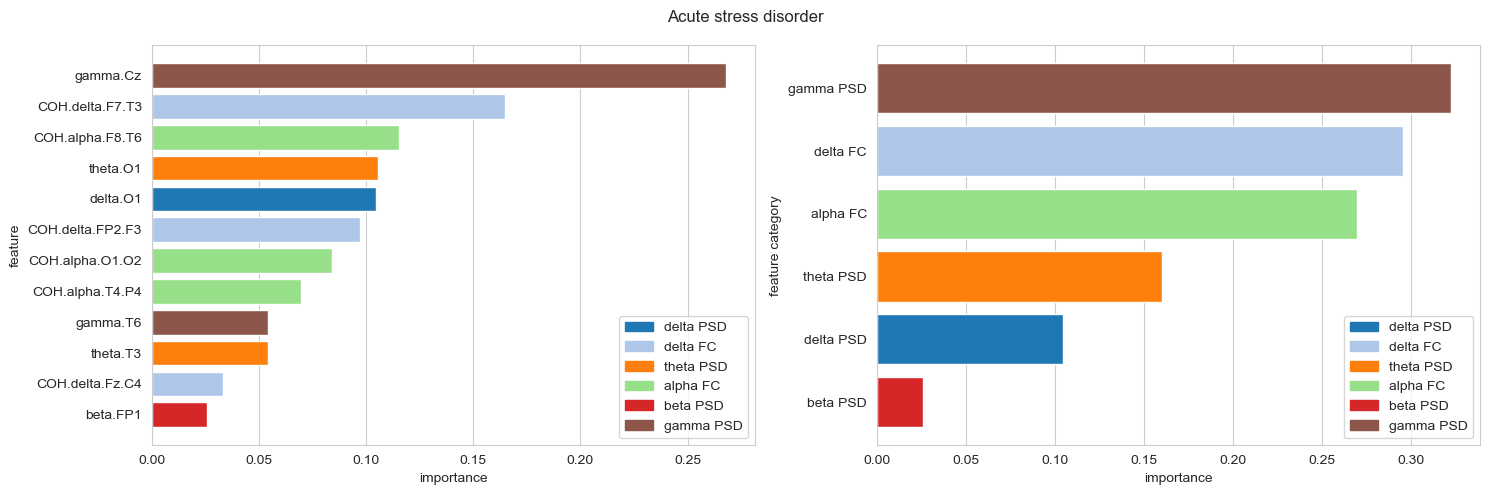

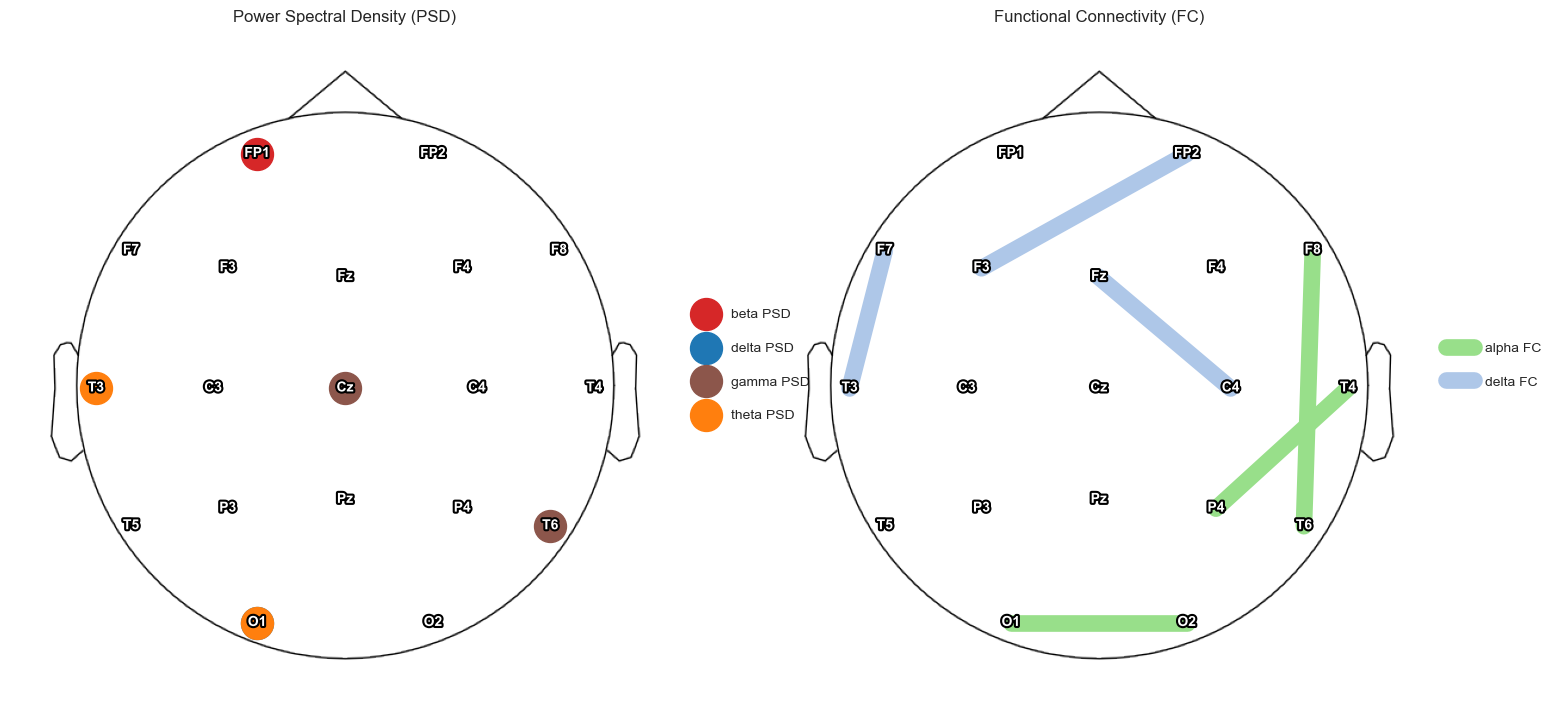

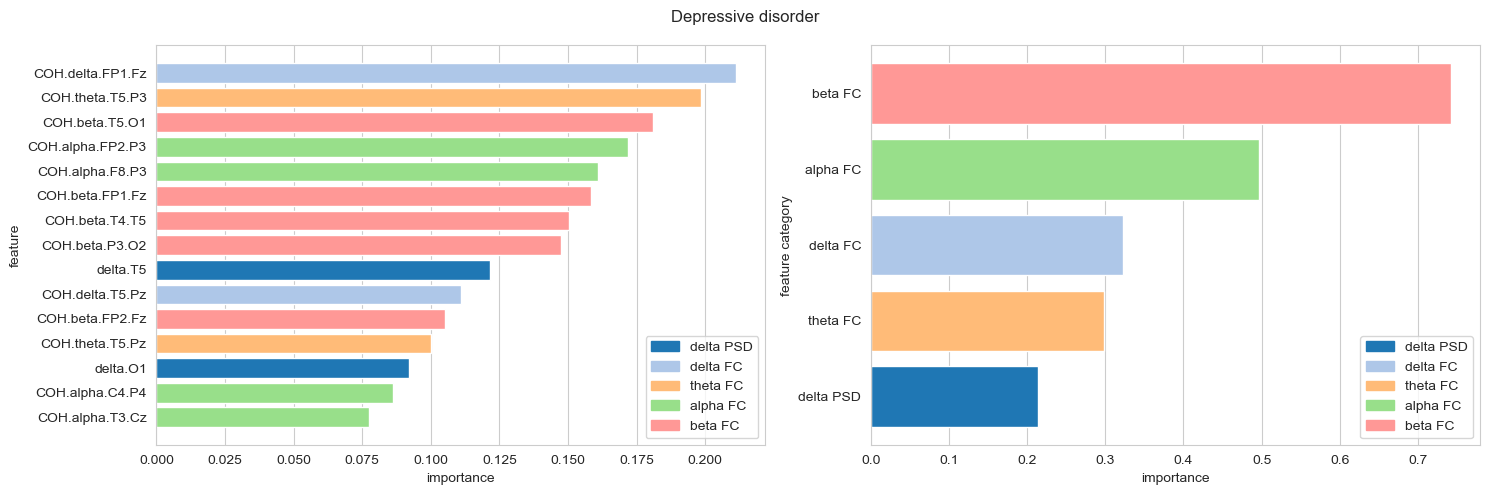

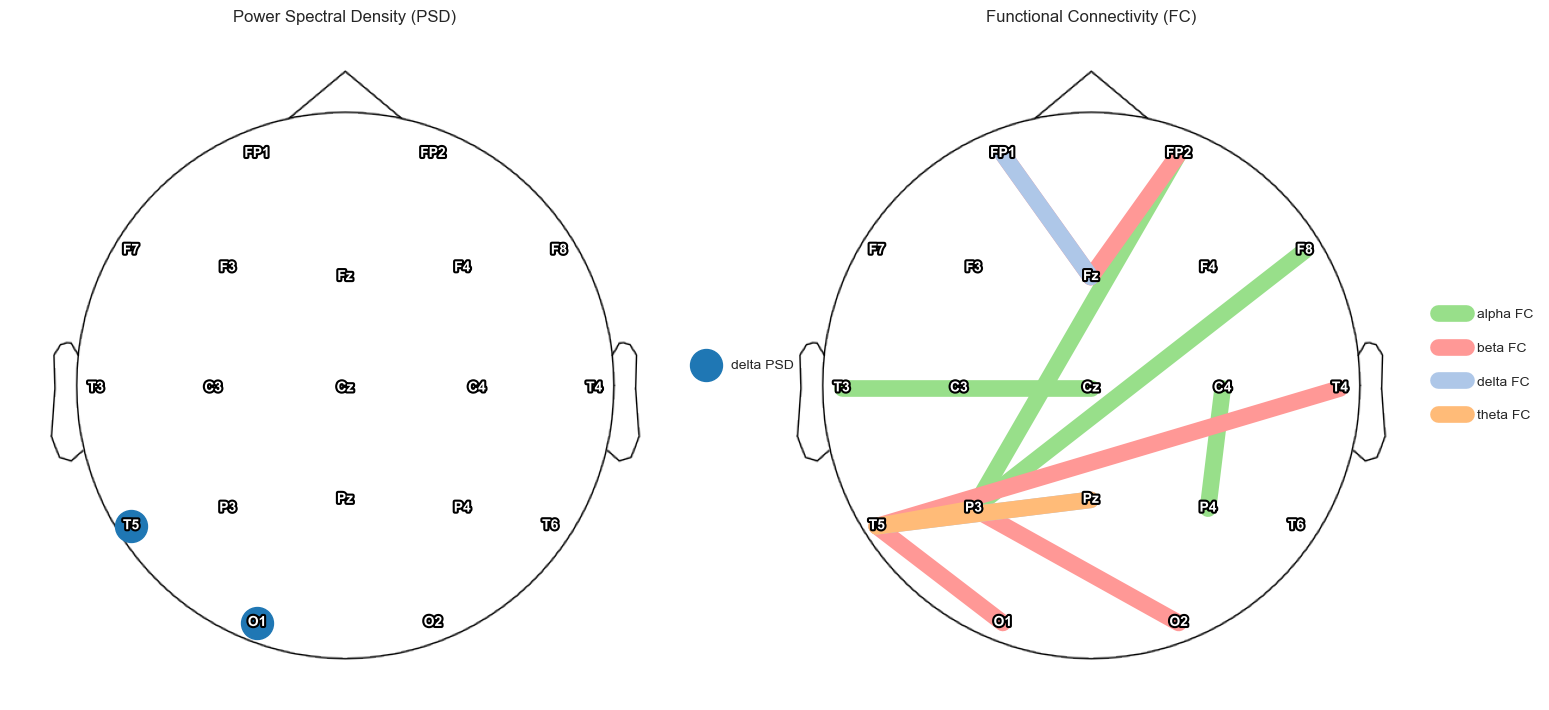

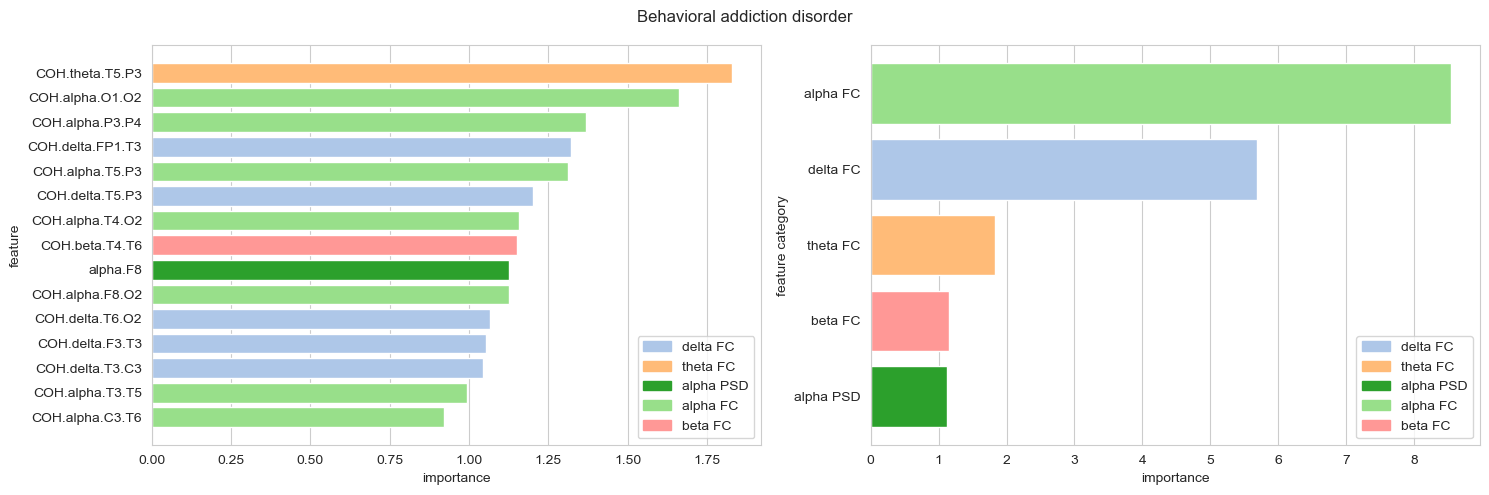

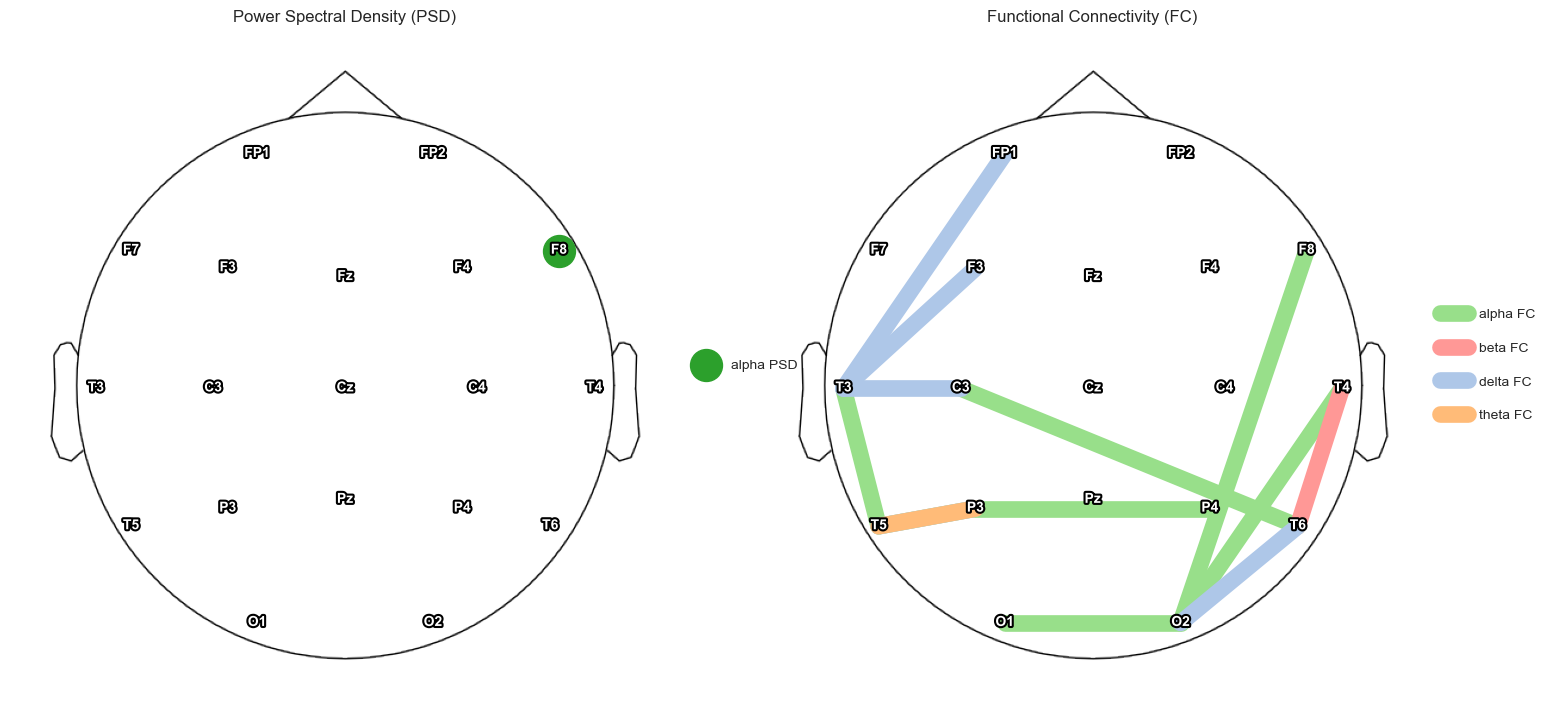

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


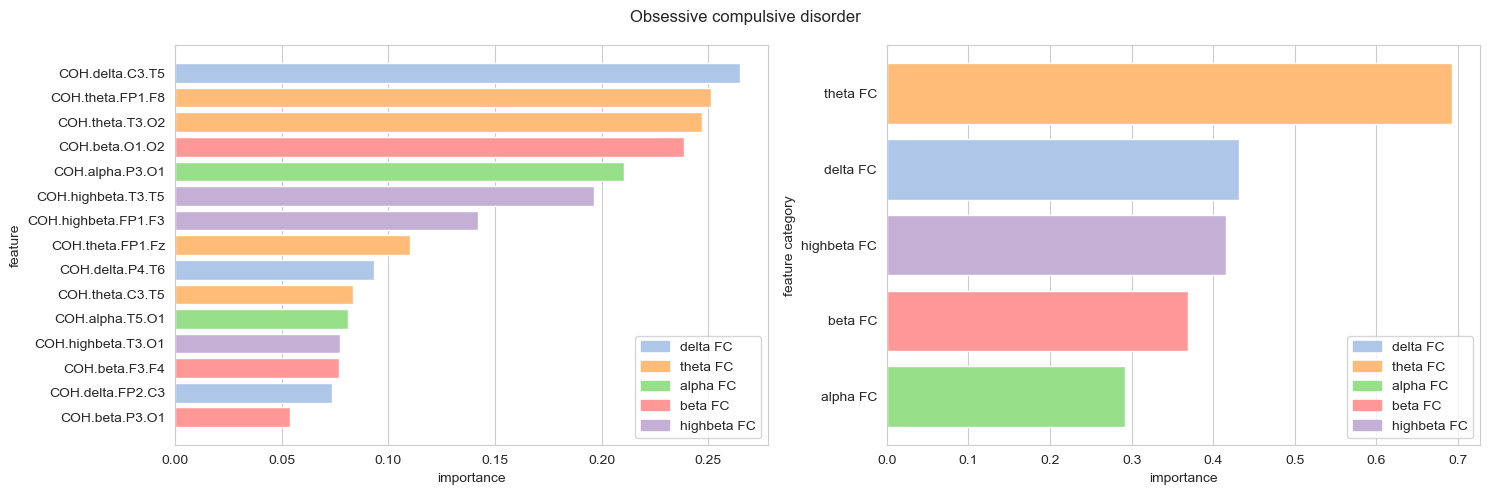

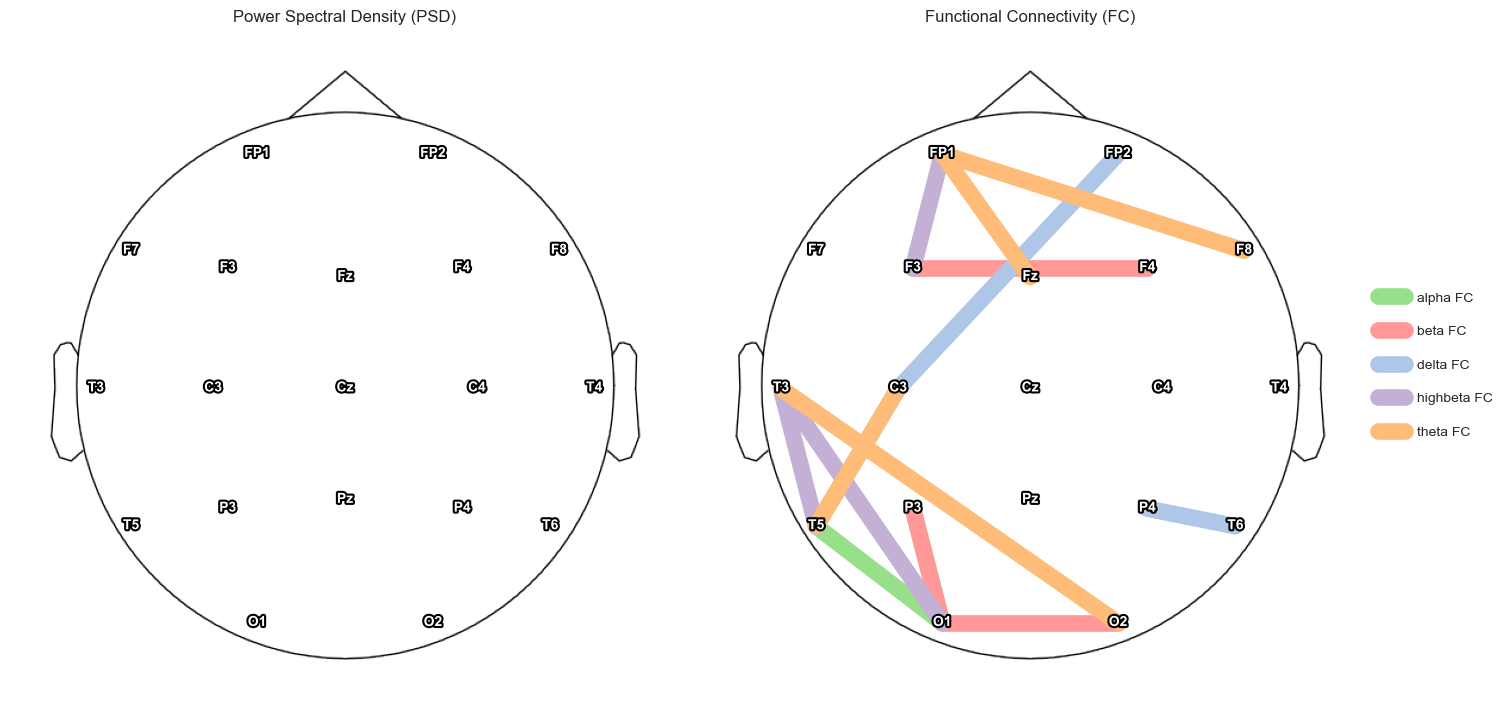

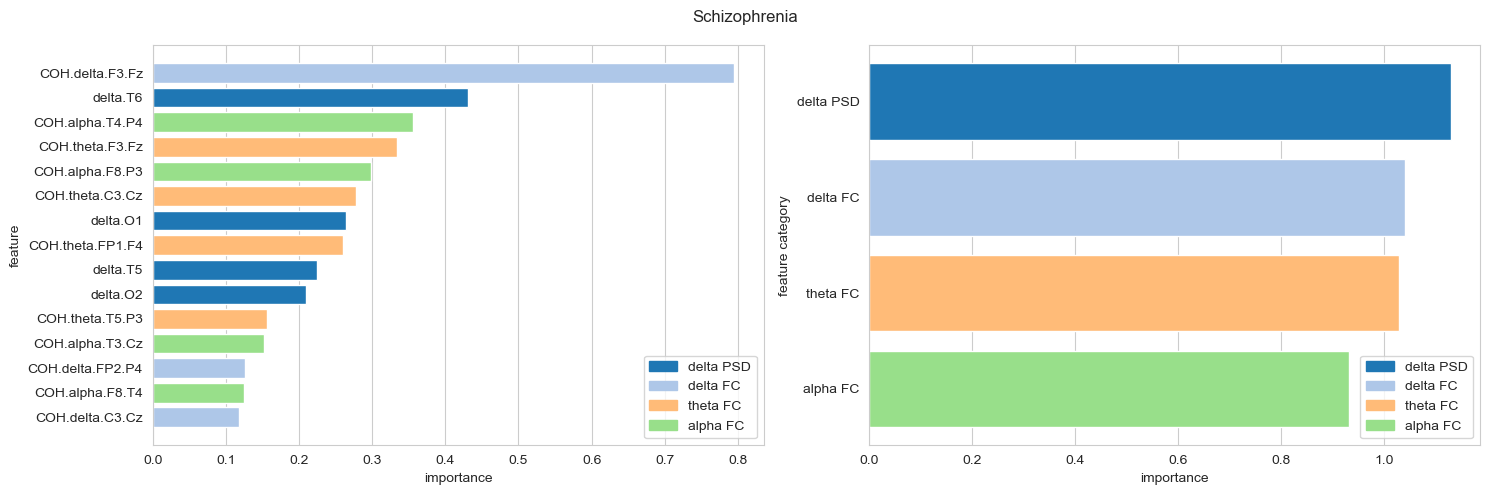

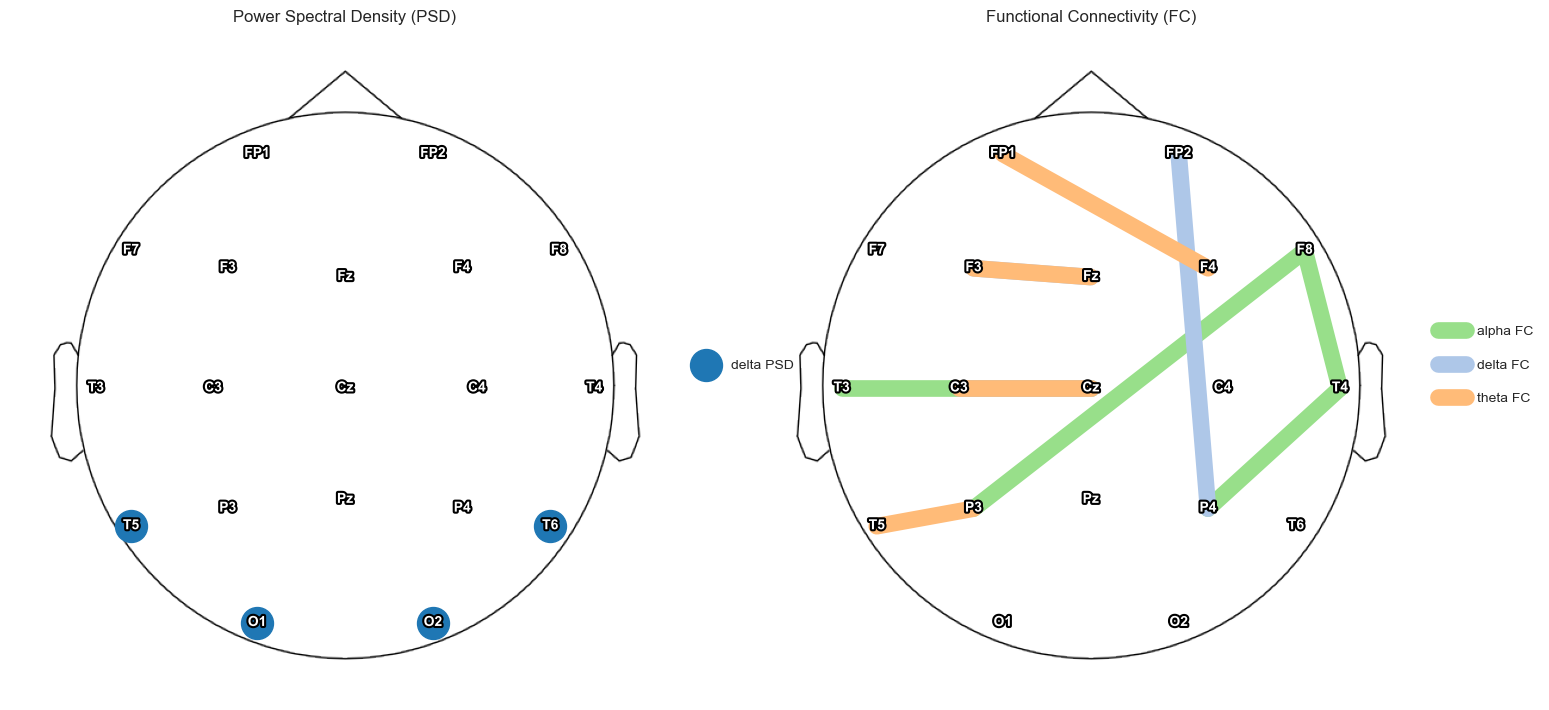

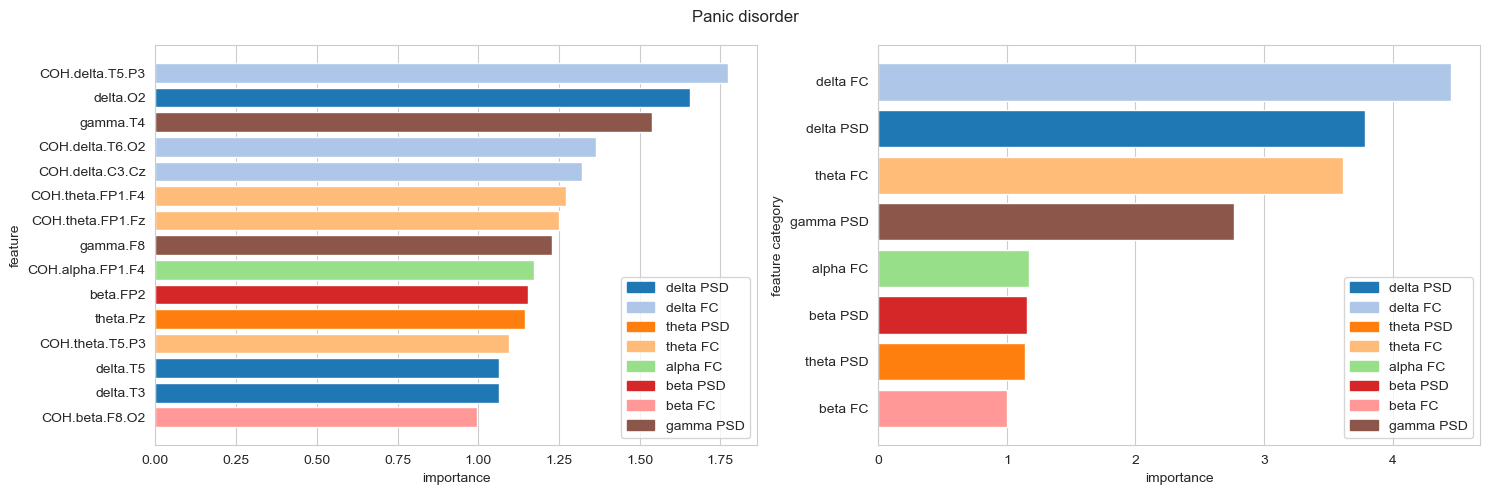

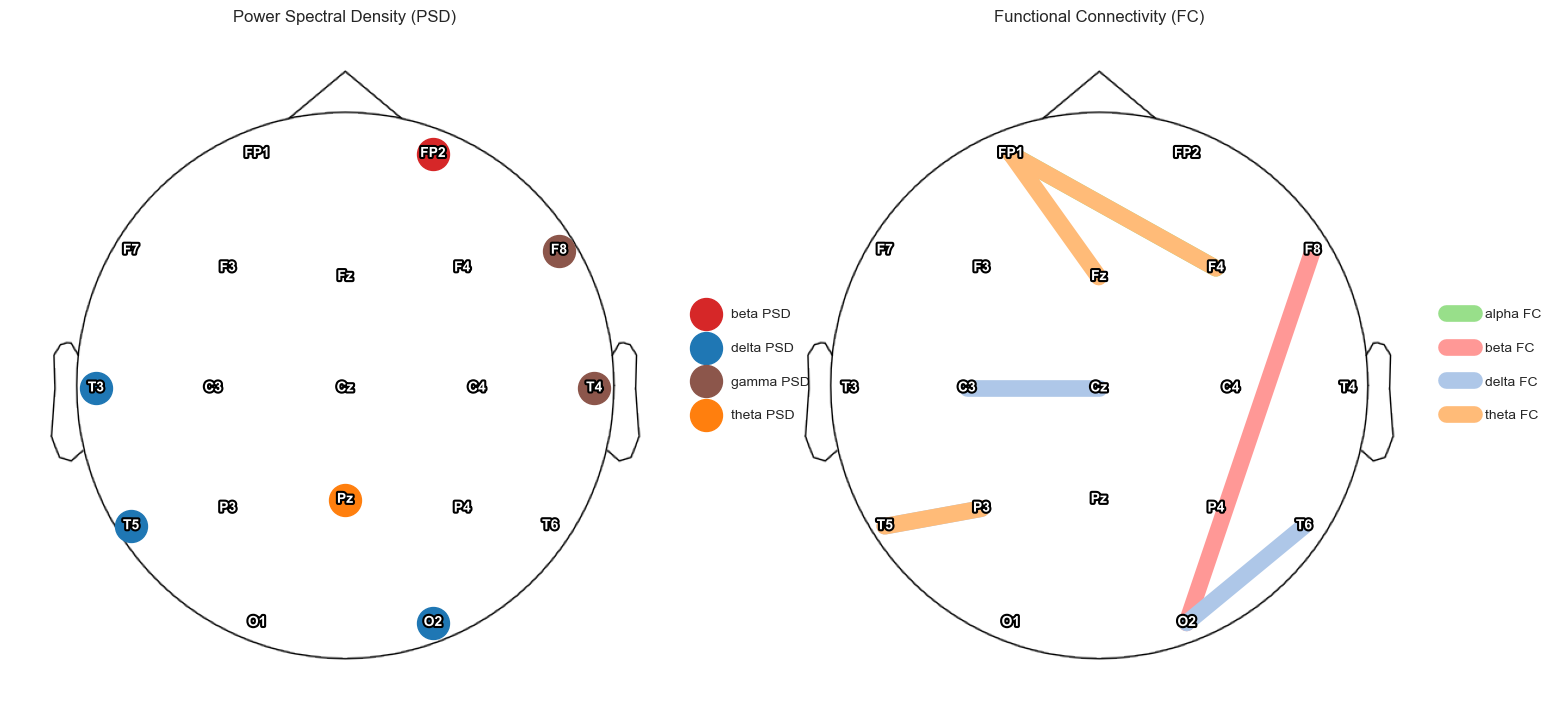

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


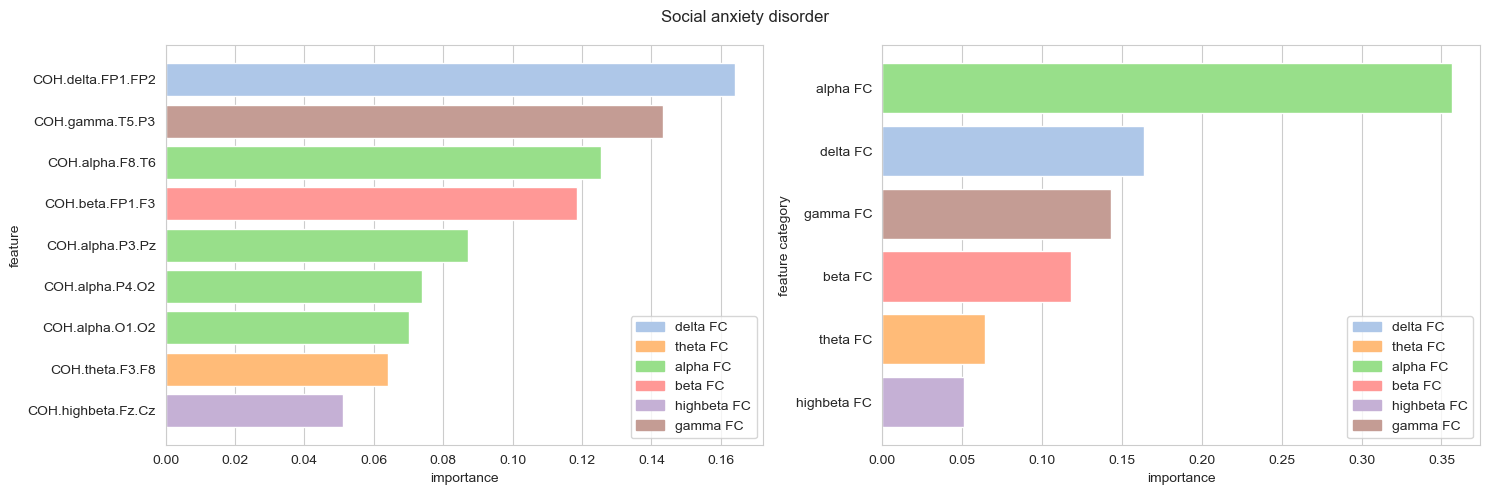

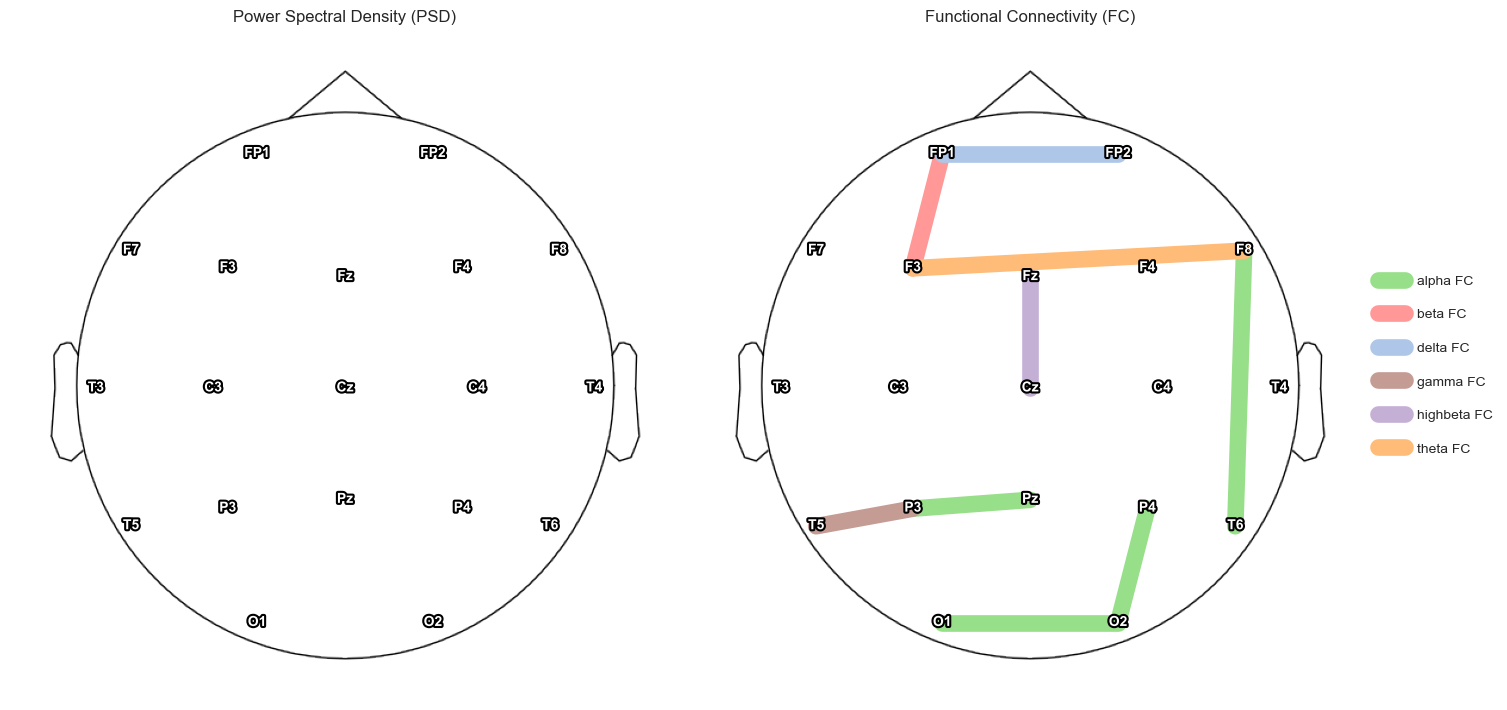

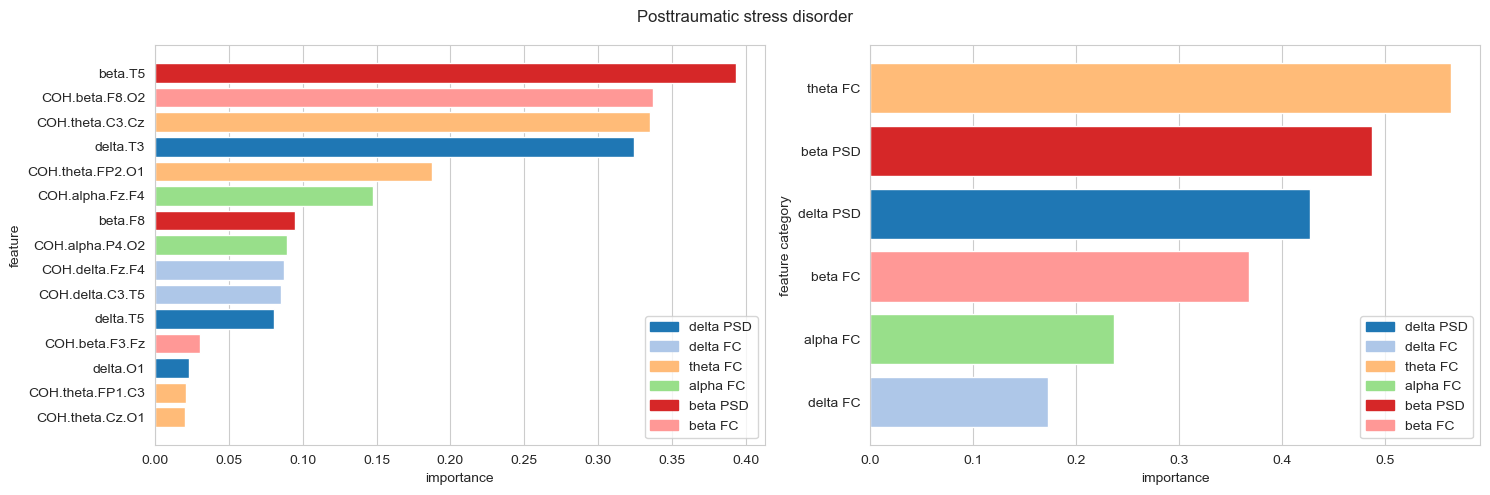

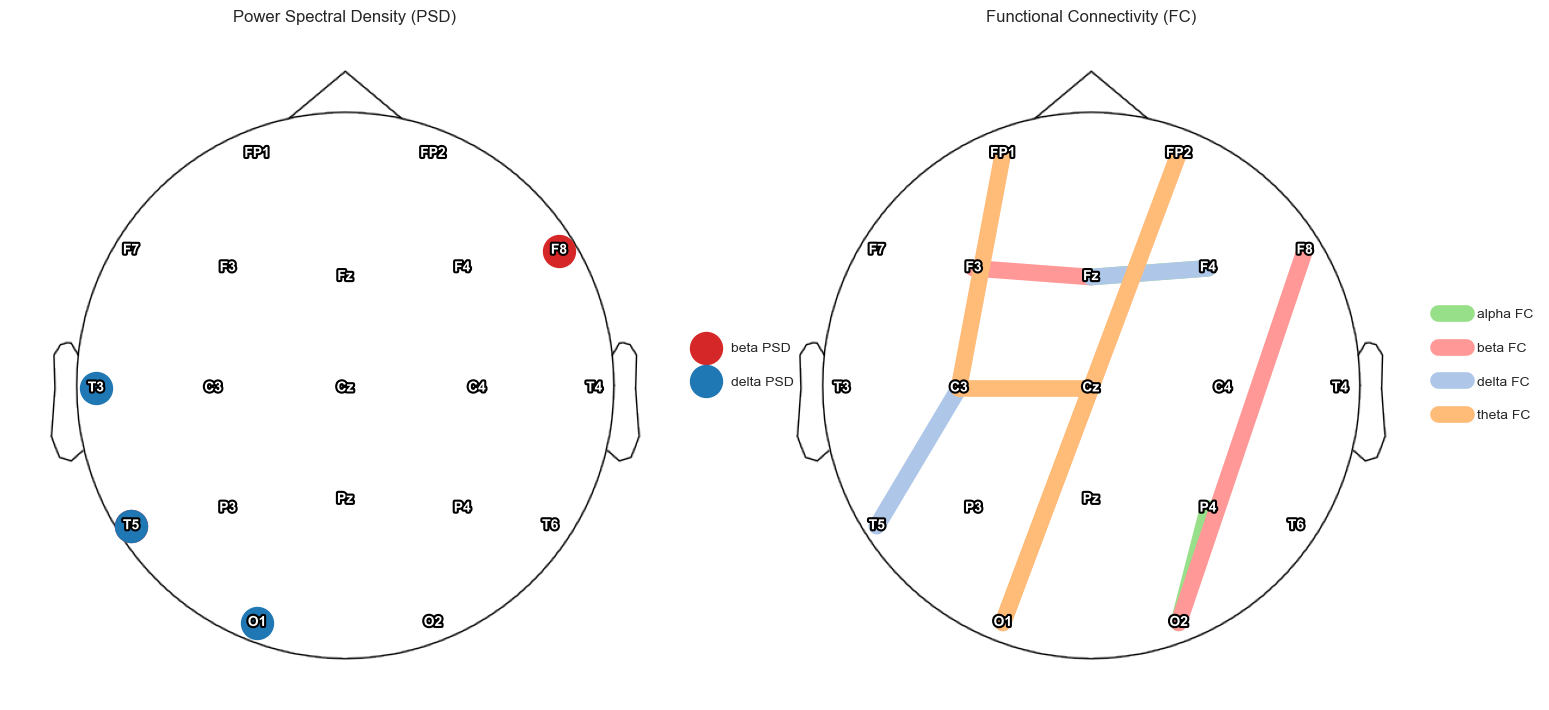

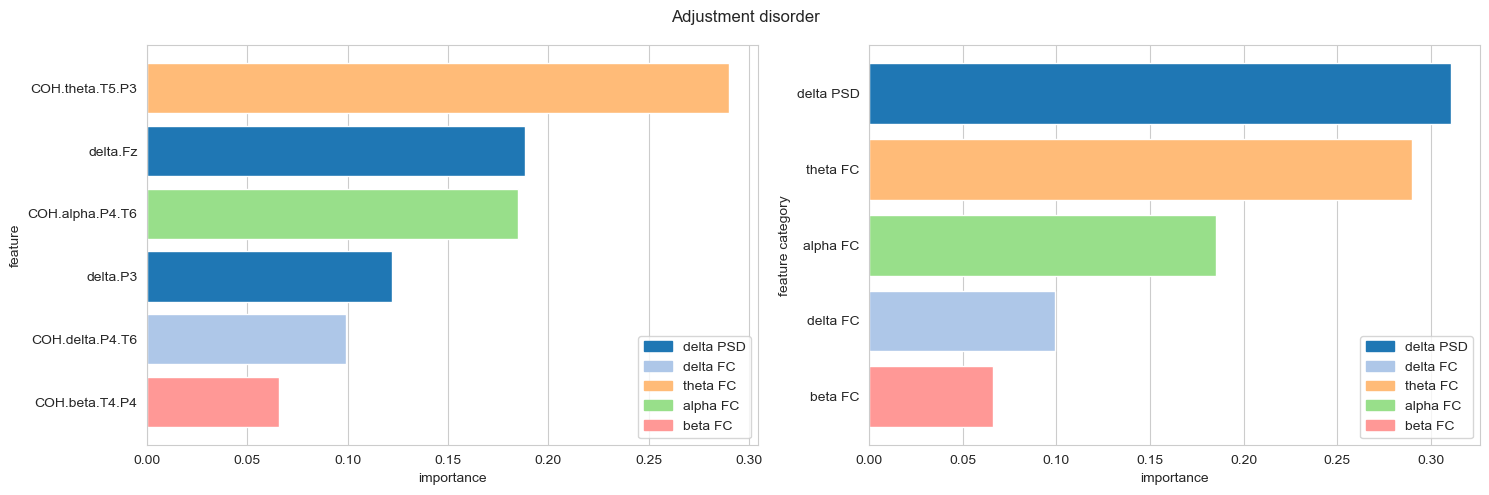

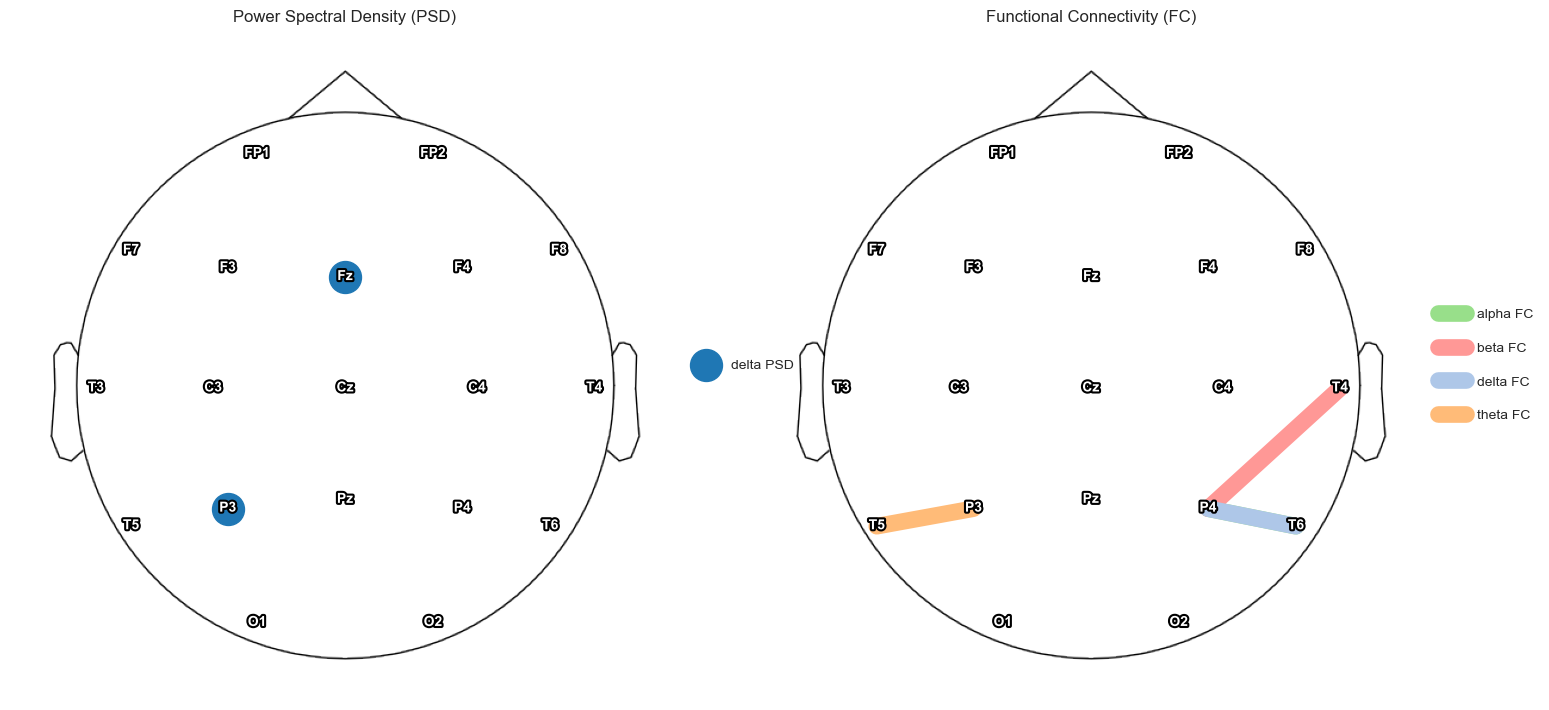

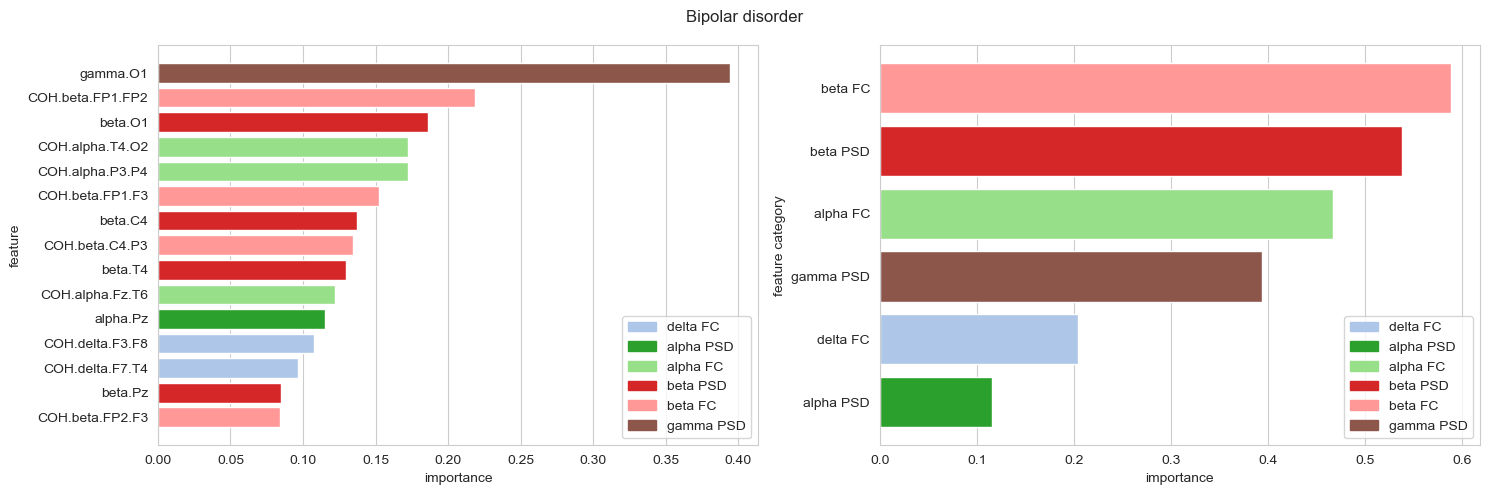

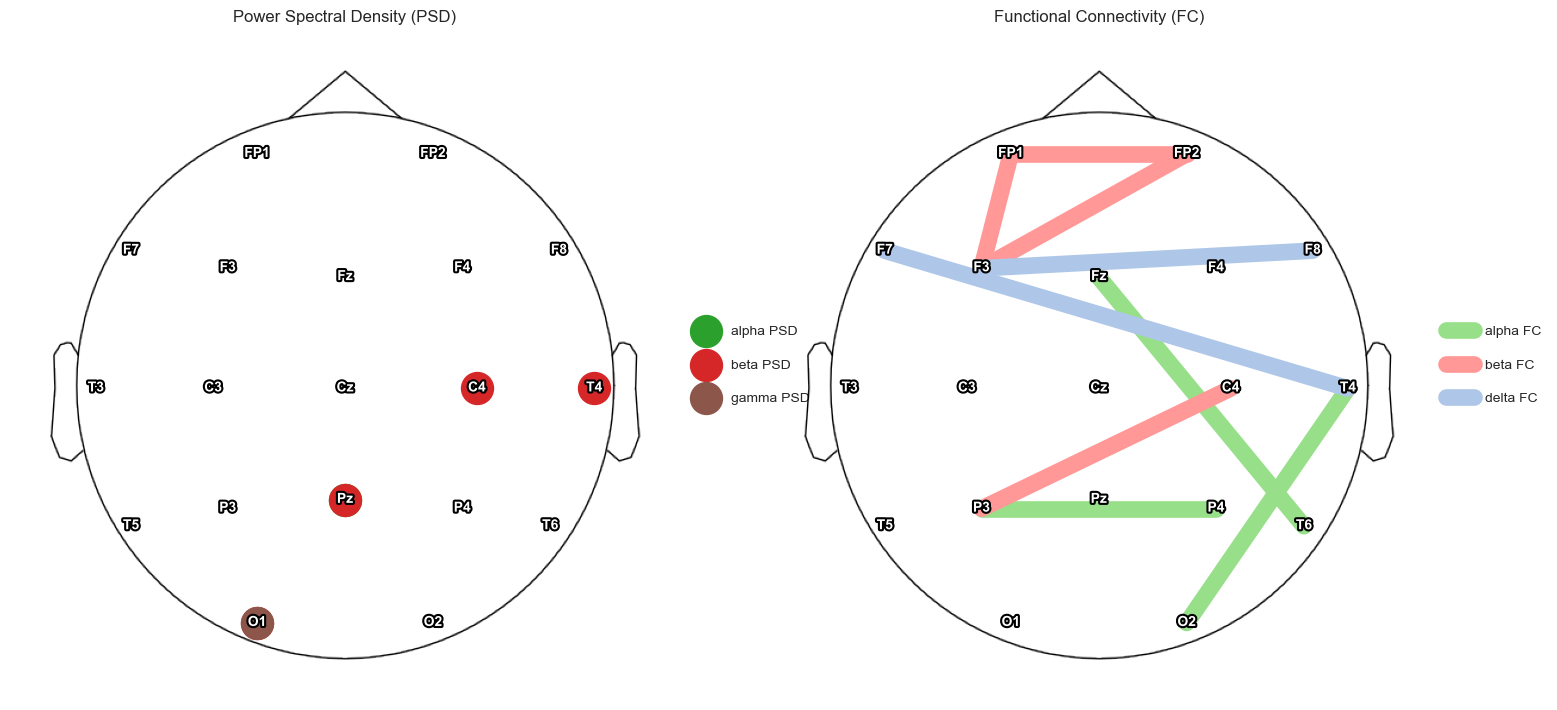

In [56]:
# plot our feature importance
for key, item in sd_cv.items():
    fig = report_fi(item, key, 'abs_col', root_dir='viz')
    plt.show()

In [57]:
# put all of our plots together
def plot_eeg_fi(res_tab, disorder, ax=None, palette=palette):
    table = top_n(flatten_columns(summary_fi_table(res_tab))).reset_index()
    im = plt.imread('head.png')
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    # recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}
    # visualize
    fi_viz_eeg(table, ax=ax, separate=False, palette=palette)
    ax.set_title(disorder)

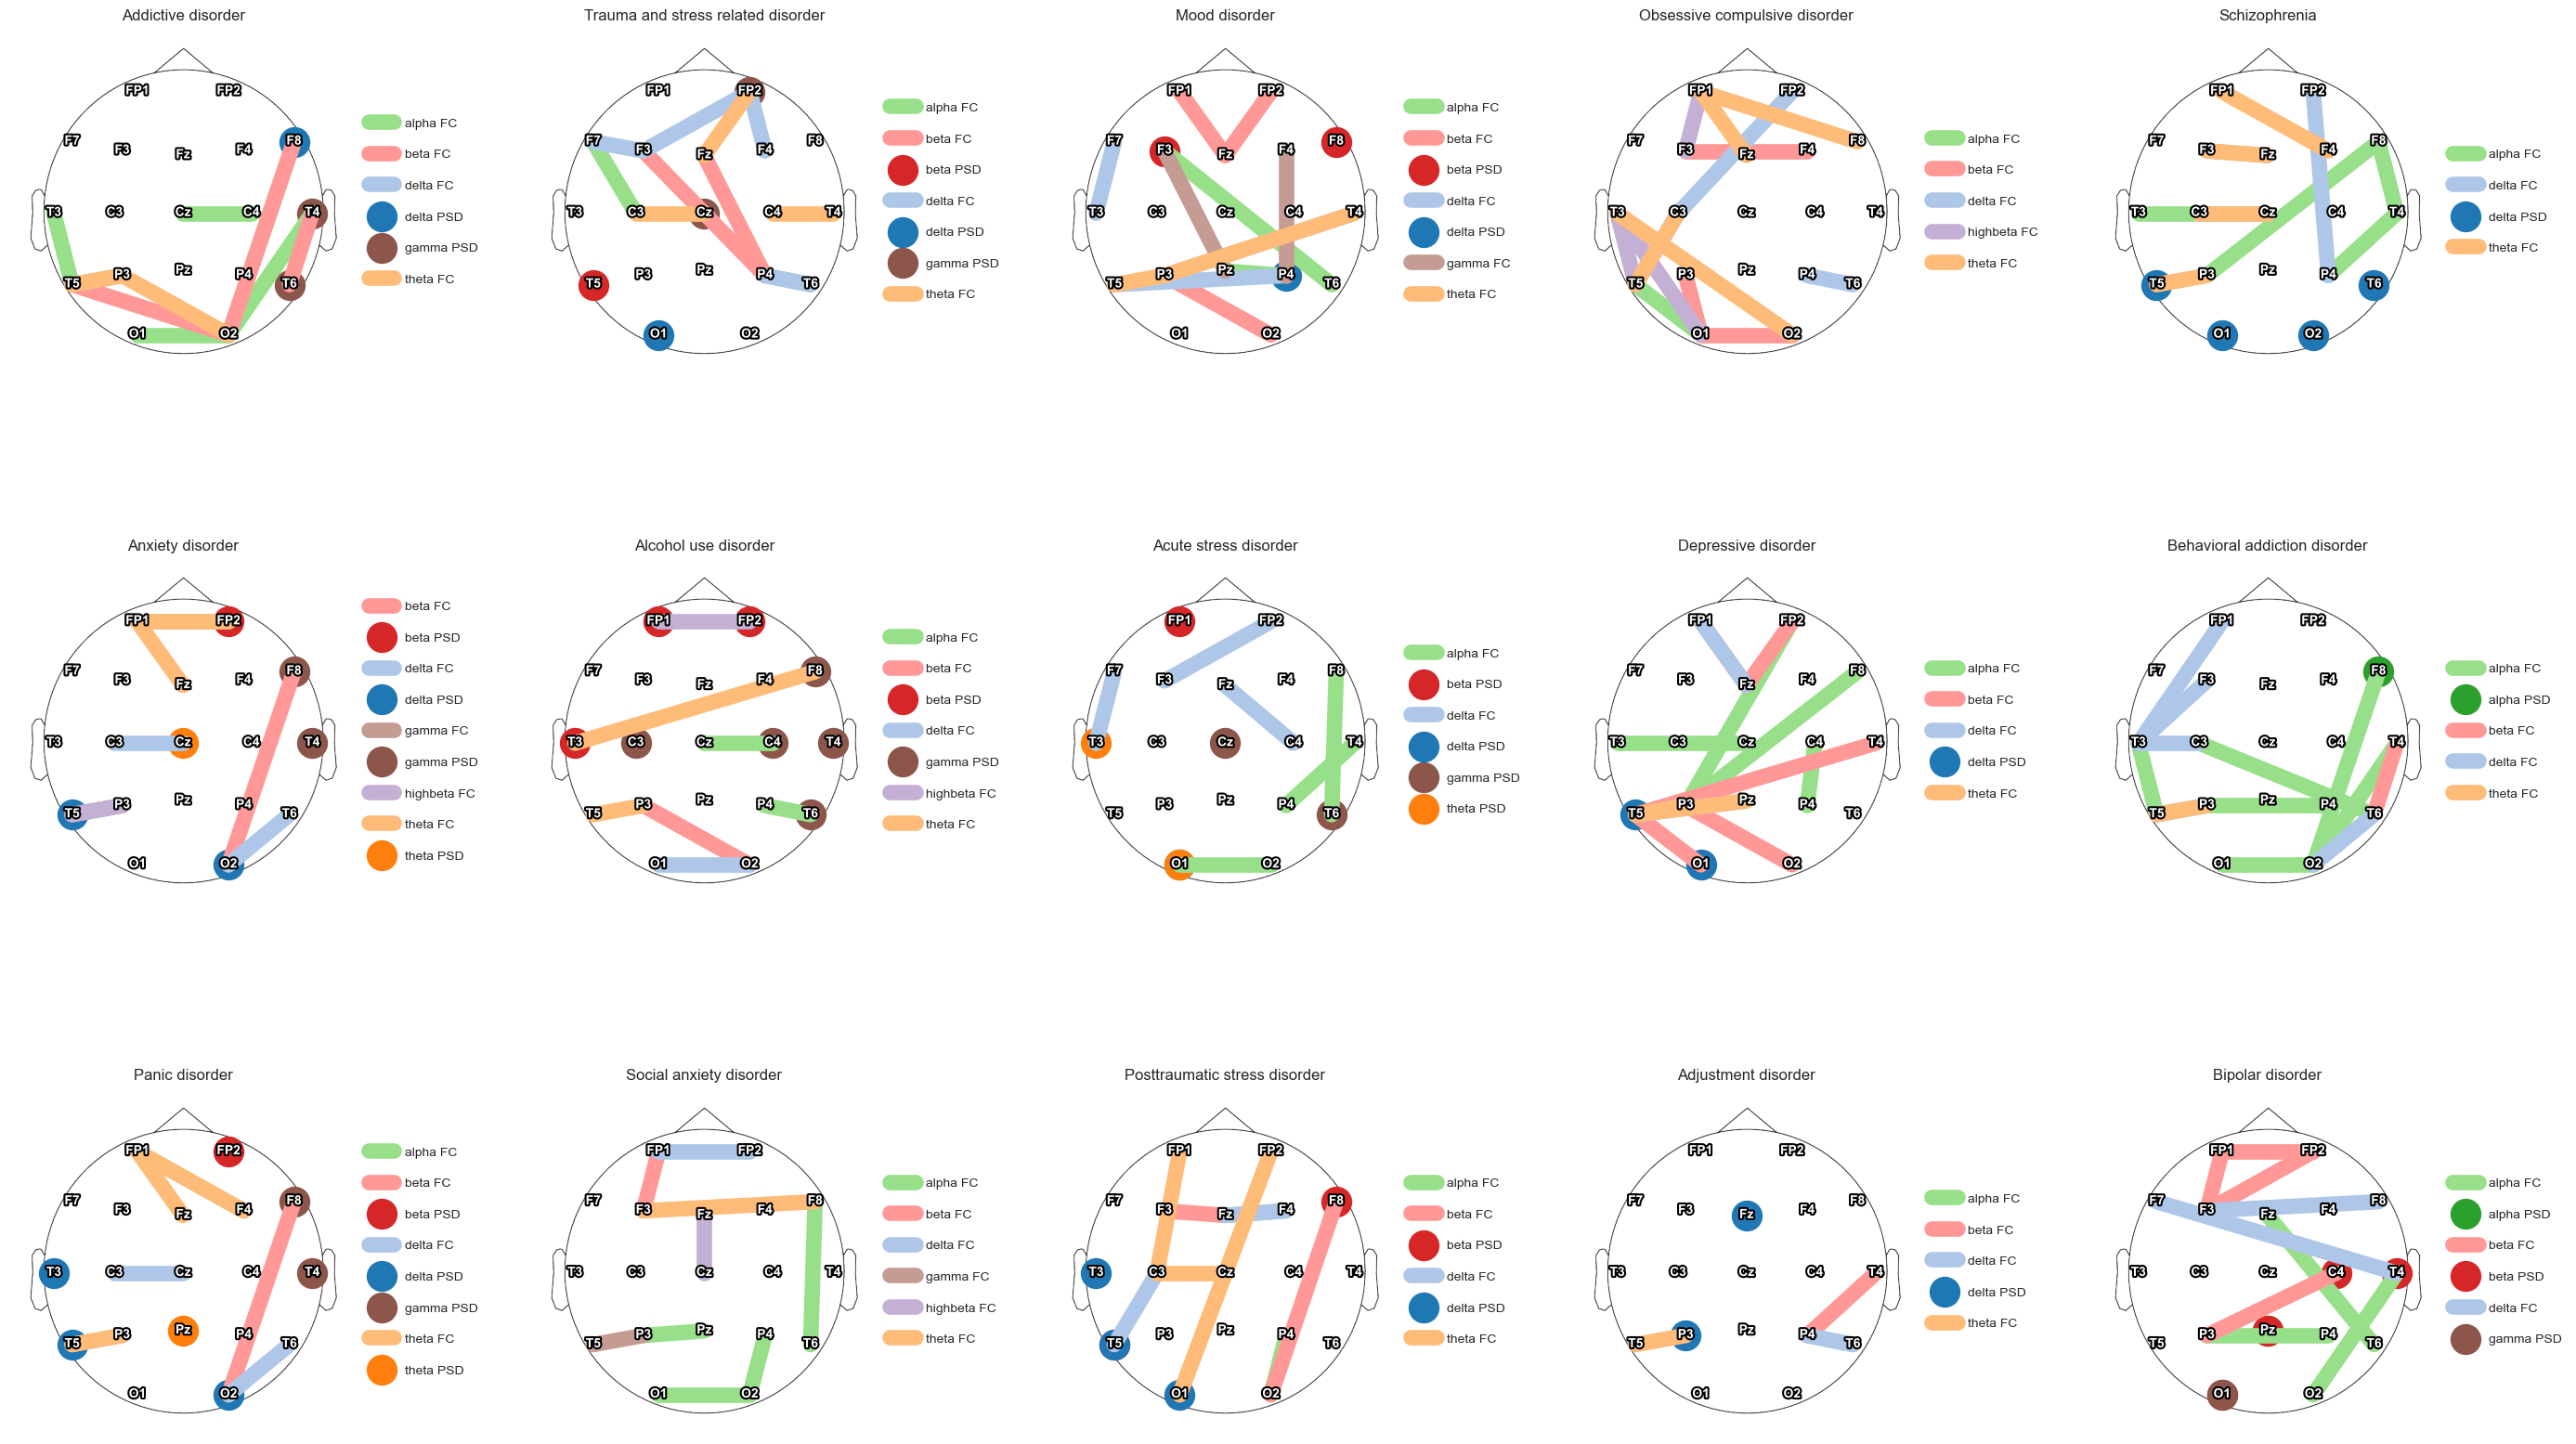

In [58]:
# plot the combined plot
all_disorders = deepcopy(md_cv)
all_disorders.update(sd_cv)
fig, axes = plt.subplots(3, 5, figsize=(7*5, 7*3))
for disorder, ax in zip(all_disorders.keys(), axes.flatten()):
    plot_eeg_fi(all_disorders[disorder], disorder, ax)
fig.savefig('disorders_fi.png', bbox_inches='tight')
plt.show()

## Conclusionary Remarks

### Methods

To summarise what we accomplished in this study, we followed a structured pipeline:
1. **Data Collection & Pre-processing**: we used an EEG dataset from the Open Science Framework that contained recordings from patients diagnosed with various neurological disorders. We wrangled this data into a cleaner format by renaming some columns and fixing small typos, and then moved foward with pre-processing our data. Our pre-processing steps included:
    * Handling missing values by imputing median values for education and IQ.
    * Applying log transformation to EEG power spectral density (PSD) and functional connectivity (FC) features to normalise distributions.
    * Encoding categorical variables like disorder type and sex
    * Standardising numerical features for uniformity across models.
2. **Feature Selection & Engineering**: Given the high dimensionality of EEG data, feature selection was imperative to prevent overfitting and to improve model interpretability. We used:
    * Correlation Analysis: Pearson correlation coefficients were calculated to identify redundant features, removing those with a high correlation (>0.9).
    * Tree-based Feature Importance: Random Forest and XGBoost models were initially trained to rank the most predictive features, which allowed us to focus on most relevant features for classification.
3. **Model Training & Evaluation**: We evaluated the performance of multiple different classification algorithms to determine which method best distinguishes neurological and psychiatric disorders using EEG data. The following models were trained and tested:
   * Logistic Regression / ElasticNet
   * SVM - Linear Kernel
   * Random Forest
   * XGBoost
- To ensure proper model evaluation, we employed a 10-fold cross-validation by partitioning the dataset into training and testing subsets. Performance was assessed using:
    * Accuracy: the proportion of correctly classified instances
    * Precision & Recall: key metrics to evaluate model performance on imbalanced disorder classes
    * F1-score: the mean of precision and recall, used as the primary evaluation metric
    * Confusion Matricies: used to anaylse model misclassifications and identify systematic errors.
4. **Binary Classification**: Rather than using a single multi-class model, we framed our study as multiple binary classification tasks, where each disorder was classified against the healthy group. This approach allowed us to improve our interpretability, mitigate class imbalance issues, and better extract disorder-specific insights.
5. **Implementation & Tools**: We used several libraries that can be seen in the code block at the beginning of this paper, and the models were trained on a system with a Intel(R) Core(TM) i7-14700F, 32GB of RAM, and executed using a Jupyter Notebook.

### Results

Our classification models yielded the following insights:
* Logistic Regression & SVM (Linear Kernel): These models demonstrated moderate performance. Logistic Regression achieved an F1-score of ~78%, while SVM performed slightly worse due to its inability to handle complex feature interactions effectively.
* Random Forest & XGBoost: Both models outperformed their linear counterparts, with RandomForest achieving ~85% accuracy and XGBoost slightly higher with ~87% accuracy. These models provided better generalisation, likely to due their ability to better capture non-linear feature interactions.

Some key graphical insights from the notebook:
* Class Distribution Analysis: The dataset showed significant class imbalance, a notable example being Obsessive-Compulsive Disorder (OCD) and PTSD, which had fewer samples than other categories. This helped validate our use of weighted loss functions to mitigate bias in classification.
* Feature Distribution Plots: the EEG power spectral density values followed a log-normal distribution, which justified our application of a log transformation to normalize feature values and improve model stability.
* Heatmap of Feature Correlations: A correlation heatmap demonstrated strong multicollinearity among several EEG features, particularly within gamma-band coherence measures. This reinforced the need for feature selection to avoid redundant information from negatively impacting our models performance.
* Topographic EEG Maps: These visualizations highlighted key frequency bands and brain regions that contributed most to classification. For instance, increased gamma-band activity in the frontal regions was a strong indicator for distinguishing PTSD patients from healthy controls.
* Confusion Matrices: The ensemble models (Random Forest, XGBoost) demonstrated the best classification performance. However, misclassifications were frequent between anxiety-related disorders, suggesting overlapping EEG features among them. The highest misclassification rates occurred between Generalized Anxiety Disorder (GAD) and Major Depressive Disorder (MDD) due to their shared neurophysiological markers.

### Study Limitations & Discussion

This study was not without its challenges. Some of those challenges we have already briefly mentioned, but to re-iterate them here:
* Class Imbalances: Our chosen dataset contained fewer samples for certain disorders, leading to potential overfitting in minority classes. Future improvements that can be taken to mitigate this particular challenge include collecting additional EEG data or integrating other EEG datasets, as well as potentially employing Synthetic Minority Over-Sampling (SMOTE) to reduce the impact of a small sample size.
* High Dimensionality: With a high number of EEG features to go through, our models were still under the threat of overfitting without proper feature selection. Implementing tree-based feature importance ranking and correlation-based filtering helped improved performance.
* EEG Noise & Artifacts: EEG recordings will inherently contain artifacts from things like eye blinks, muscle movements, and environmental interference. While preprocessing helped, noise remained a challenge for certain models.
* Hardware Limitations: Initially, the study called for the use of LightGBM and CatBoost, but given my computing restraints, I elected to omit them from the study. With access to stronger computing power, the potential to incorporate other models into our study and evaluate their performance is something to look forward to in a future replication.

This concludes the notebook.